/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: divide by zero encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: invalid value encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in log10
  o3n2_ratio = np.log10(oiii_hb / nii_ha)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:267: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = axP.scatter(x_data, y_data, c=galaxy_color_dic

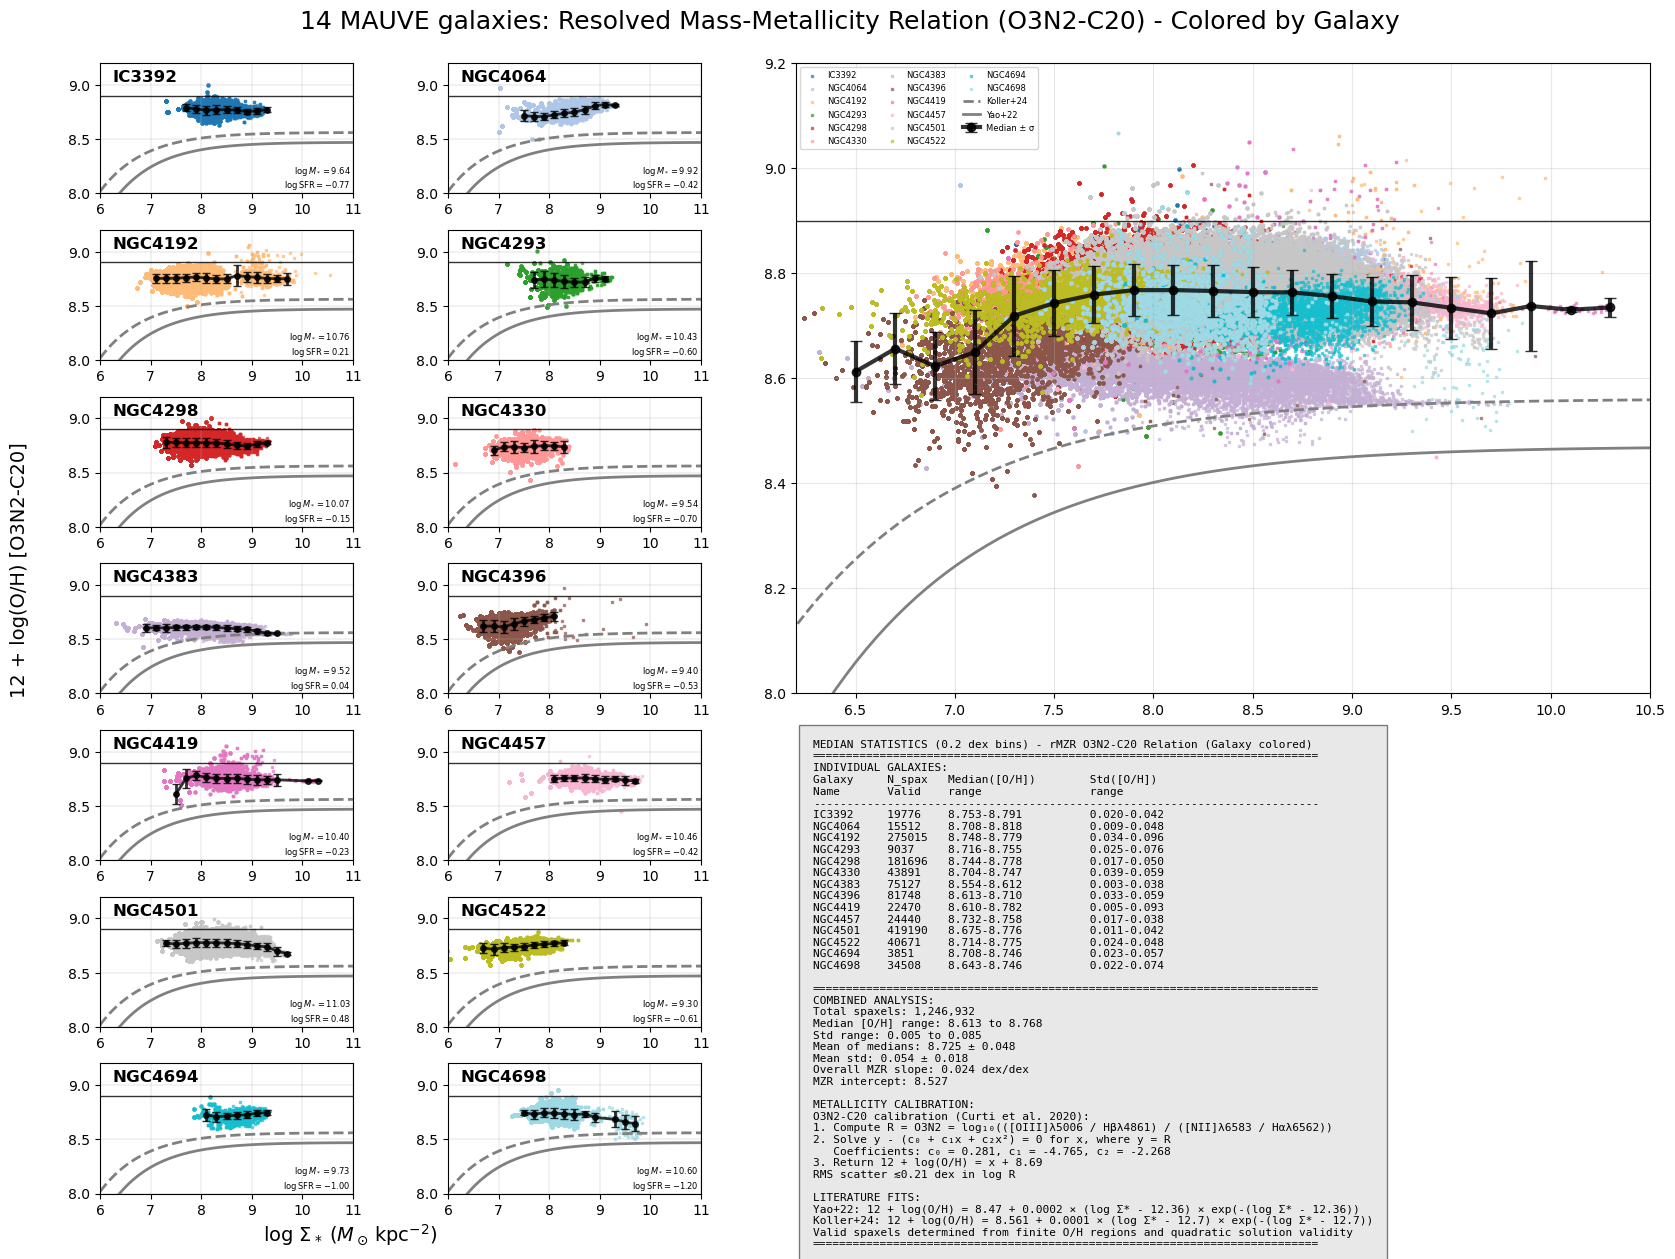

In [1]:
# ------------------------------------------------------------------
# COMPREHENSIVE LAYOUT: Individual galaxies + Combined plot + Statistics (rMZR O3N2-C20 Relation - Galaxy colored)
# 4-column layout: Cols 1-2 = Individual galaxies, Col 3 = Combined plot, Col 4 = Statistics
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy.io import fits
import itertools
import re  # Add this import for regex

# 0 · discover galaxies & colour palette
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]
ngal = len(galaxies)
assert ngal <= 14, "This layout assumes ≤ 14 galaxies."

# Create distinct colors for each galaxy
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, ngal))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

def load_maps(gal):
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR = h['LOGSFR_SURFACE_DENSITY_SF'].data
        # Load emission line fluxes for O3N2 ratio
        hb4861_flux = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        nii6583_flux = h['NII6583_FLUX_corr'].data
        ha6562_flux = h['HA6562_FLUX_corr'].data
        # Load emission line flux errors
        hb4861_flux_err = h['HB4861_FLUX_ERR'].data
        oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data
        nii6583_flux_err = h['NII6583_FLUX_ERR'].data
        ha6562_flux_err = h['HA6562_FLUX_ERR'].data
        # Load valid O/H data to determine good spaxels
        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None
    return sigM, sigSFR, hb4861_flux, oiii5006_flux, nii6583_flux, ha6562_flux, hb4861_flux_err, oiii5006_flux_err, nii6583_flux_err, ha6562_flux_err, oh_d16_sf

# Error propogation for BPT diagrams (sigma of log_10(numerator/denominator))
def bpt_error_propagation(numerator, denominator, numerator_err, denominator_err):
    """
    Calculate the propagated error for the BPT ratio log10(numerator/denominator).
    
    Parameters:
    numerator (np.ndarray): The numerator values.
    denominator (np.ndarray): The denominator values.
    numerator_err (np.ndarray): The error in the numerator.
    denominator_err (np.ndarray): The error in the denominator.
    
    Returns:
    np.ndarray: The propagated error for the BPT ratio.
    """
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = numerator / denominator
        log_ratio = np.log10(ratio)
        log_ratio_err = 1/(np.log(10)) * np.sqrt((numerator_err / numerator)**2 + (denominator_err / denominator)**2)
        return log_ratio_err

def calculate_o3n2_c20_metallicity(hb4861_flux, oiii5006_flux, nii6583_flux, ha6562_flux, 
                                   hb4861_flux_err, oiii5006_flux_err, nii6583_flux_err, ha6562_flux_err, 
                                   oh_d16_sf):
    """Calculate [O/H] using O3N2-C20 calibration from Curti+2020 with error propagation"""
    # Use finite O/H values to determine valid spaxels
    if oh_d16_sf is not None:
        good_mask = np.isfinite(oh_d16_sf)
    else:
        # Fallback: use basic finite checks on emission lines
        good_mask = (np.isfinite(hb4861_flux) & np.isfinite(oiii5006_flux) &
                    np.isfinite(nii6583_flux) & np.isfinite(ha6562_flux) &
                    (hb4861_flux > 0) & (oiii5006_flux > 0) &
                    (nii6583_flux > 0) & (ha6562_flux > 0))
    
    # Additional checks for positive fluxes and finite errors where O/H is valid
    good_mask = (good_mask & (hb4861_flux > 0) & (oiii5006_flux > 0) & (nii6583_flux > 0) & (ha6562_flux > 0) &
                 np.isfinite(hb4861_flux_err) & np.isfinite(oiii5006_flux_err) & 
                 np.isfinite(nii6583_flux_err) & np.isfinite(ha6562_flux_err))
    
    # Initialize output arrays
    oh_o3n2_c20 = np.full_like(hb4861_flux, np.nan)
    oh_o3n2_c20_err = np.full_like(hb4861_flux, np.nan)
    
    # Calculate O3N2 ratio and errors
    oiii_hb = oiii5006_flux / hb4861_flux
    nii_ha = nii6583_flux / ha6562_flux
    o3n2_ratio = np.log10(oiii_hb / nii_ha)
    
    # Calculate errors for the line ratios using error propagation
    oiii_hb_err = bpt_error_propagation(oiii5006_flux, hb4861_flux, oiii5006_flux_err, hb4861_flux_err)
    nii_ha_err = bpt_error_propagation(nii6583_flux, ha6562_flux, nii6583_flux_err, ha6562_flux_err)
    
    # Error for O3N2 = log10(OIII/Hb / NII/Ha) = log10(OIII/Hb) - log10(NII/Ha)
    # Error propagation: sqrt(err1^2 + err2^2) for difference of independent variables
    o3n2_ratio_err = np.sqrt(oiii_hb_err**2 + nii_ha_err**2)
    
    # Apply O3N2-C20 calibration (Curti+2020)
    # Step 1: Compute R = O3N2 and y = log10(R)
    R = o3n2_ratio  # This is already log10(O3N2)
    y = R
    y_err = o3n2_ratio_err
    
    # Step 2: Solve quadratic equation y - (c0 + c1*x + c2*x^2) = 0 for x
    # Coefficients from Curti+2020
    c0 = 0.281
    c1 = -4.765
    c2 = -2.268
    
    # Rearrange to standard form: c2*x^2 + c1*x + (c0 - y) = 0
    # Using quadratic formula: x = (-b ± sqrt(b^2 - 4ac)) / (2a)
    a = c2
    b = c1
    c = c0 - y
    
    # Calculate discriminant
    discriminant = b**2 - 4*a*c
    
    # Only calculate where discriminant is positive
    valid_discriminant = discriminant >= 0
    combined_mask = good_mask & valid_discriminant
    
    if np.any(combined_mask):
        # Use the appropriate root (typically the positive one for metallicity)
        x_solution1 = (-b + np.sqrt(discriminant[combined_mask])) / (2*a)
        x_solution2 = (-b - np.sqrt(discriminant[combined_mask])) / (2*a)
        
        # Choose the solution that gives reasonable metallicity values
        # Typically x should be in the range corresponding to 12+log(O/H) ~ 7.6 to 8.85
        x_final = np.where((x_solution1 >= -1.1) & (x_solution1 <= 1.25), x_solution1, x_solution2)
        
        # Calculate error in x using derivative approach
        # For equation f(x,y) = y - (c0 + c1*x + c2*x^2) = 0
        # df/dx = -(c1 + 2*c2*x), df/dy = 1
        # x_err = |df/dy| * y_err / |df/dx| = y_err / (|c1| + |2*c2*x|)
        derivative_x = np.abs(c1 + 2*c2*x_final)
        x_err = y_err[combined_mask] / derivative_x
        
        # Step 3: Return 12 + log(O/H) = x + 8.69
        oh_o3n2_c20[combined_mask] = x_final + 8.69
        # Add intrinsic fitting error from O3S2-C20 calibration (0.09 dex)
        fitting_err = 0.09  # dex
        oh_o3n2_c20_err[combined_mask] = np.sqrt(x_err**2 + fitting_err**2)

    return oh_o3n2_c20, oh_o3n2_c20_err, combined_mask

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_sfr(galaxy_name):
    """Extract total SFR from SFR log file. Returns log10(M☉/yr) value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total Halpha SFR:.*?in log10 scale:\s*([\d.-]+)\s*log\(M☉/yr\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading SFR log for {galaxy_name}: {e}")
        return None

def calculate_median_statistics(x, y, x_range=(6, 11), bin_width=0.2):
    """Calculate median and std in binned intervals"""
    x_bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)
    x_centers = (x_bins[:-1] + x_bins[1:]) / 2
    
    medians = []
    stds = []
    x_valid = []
    
    for i in range(len(x_bins) - 1):
        mask = (x >= x_bins[i]) & (x < x_bins[i + 1])
        if len(np.unique(x[mask])) >= 10:  # Need at least 10 distinct x values
            y_bin = y[mask]
            medians.append(np.median(y_bin))
            stds.append(np.std(y_bin))
            x_valid.append(x_centers[i])
    
    return np.array(x_valid), np.array(medians), np.array(stds)

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color='gray')
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color='gray')

# 1 · Create comprehensive figure with 4-column layout
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(nrows=8, ncols=4, figure=fig,
              width_ratios=[1, 1, 1.5, 1.5],  # Cols 3&4 slightly wider
              height_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1],  # Row 0 for colorbar
              wspace=0.3, hspace=0.3)

plot_idx = 0
individual_stats = []

# COLUMNS 1-2: Individual galaxy plots
for idx, gal in enumerate(galaxies):
    sigM, sigSFR, hb4861_flux, oiii5006_flux, nii6583_flux, ha6562_flux, hb4861_flux_err, oiii5006_flux_err, nii6583_flux_err, ha6562_flux_err, oh_d16_sf = load_maps(gal)
    oh_o3n2_c20, oh_o3n2_c20_err, good_mask = calculate_o3n2_c20_metallicity(hb4861_flux, oiii5006_flux, nii6583_flux, ha6562_flux, 
                                                                              hb4861_flux_err, oiii5006_flux_err, nii6583_flux_err, ha6562_flux_err, oh_d16_sf)
    
    if not np.any(good_mask):
        print(f"Skipping {gal}: no valid data points")
        continue
    
    row = (plot_idx // 2) + 1  # Start from row 1 (row 0 for colorbar)
    col = plot_idx % 2
    plot_idx += 1

    axP = fig.add_subplot(gs[row, col])
    
    x_data, y_data, sfr_data = sigM[good_mask], oh_o3n2_c20[good_mask], sigSFR[good_mask]
    
    # Calculate median statistics
    x_median, y_median, y_std = calculate_median_statistics(x_data, y_data)
    individual_stats.append((gal, x_median, y_median, y_std, len(x_data)))
    
    # Scatter plot colored by galaxy
    scatter = axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')
    
    # Plot median with error bars
    if len(x_median) > 0:
        axP.errorbar(x_median, y_median, yerr=y_std, fmt='ko-', linewidth=2, 
                    markersize=4, capsize=3, alpha=0.8)
    
    # Add literature fits to individual panels (no legend)
    plot_literature_mzr_fits(axP, show_legend=False)
    
    # Add galaxy name in top left corner
    axP.text(0.05, 0.95, gal, transform=axP.transAxes, fontsize=12, fontweight='bold',
             va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', alpha=0.8, edgecolor='none'))
    
    # Bottom right: total stellar mass and SFR from log files
    total_mass = extract_total_stellar_mass(gal)
    total_sfr = extract_total_sfr(gal)
    
    if total_mass is not None and total_sfr is not None:
        log_text = fr'$\log M_* = {total_mass:.2f}$' '\n' fr'$\log \mathrm{{SFR}} = {total_sfr:.2f}$'
        axP.text(0.99, 0.01, log_text,
                 transform=axP.transAxes, va='bottom', ha='right', fontsize=6,
                 bbox=dict(facecolor='none', alpha=0.8, edgecolor='none', pad=2))
    
    axP.set_xlim(6, 11)
    axP.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
    axP.grid(True, lw=0.25)
    axP.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)      # For individual plots

# COLUMNS 3-4: Combined plot - Upper panel
ax_combined = fig.add_subplot(gs[1:5, 2:4])  # Spans rows 1-4, columns 2-3

# Collect all data for combined analysis
all_x, all_y, all_gal_ids = [], [], []
galaxy_counts = {}

for idx, gal in enumerate(galaxies):
    sigM, sigSFR, hb4861_flux, oiii5006_flux, nii6583_flux, ha6562_flux, hb4861_flux_err, oiii5006_flux_err, nii6583_flux_err, ha6562_flux_err, oh_d16_sf = load_maps(gal)
    oh_o3n2_c20, oh_o3n2_c20_err, good_mask = calculate_o3n2_c20_metallicity(hb4861_flux, oiii5006_flux, nii6583_flux, ha6562_flux, 
                                                                              hb4861_flux_err, oiii5006_flux_err, nii6583_flux_err, ha6562_flux_err, oh_d16_sf)
    
    if np.any(good_mask):
        x_data, y_data = sigM[good_mask], oh_o3n2_c20[good_mask]
        all_x.extend(x_data)
        all_y.extend(y_data)
        all_gal_ids.extend([idx] * len(x_data))  # Store galaxy index for coloring
        galaxy_counts[gal] = len(x_data)
    else:
        galaxy_counts[gal] = 0

all_x, all_y, all_gal_ids = np.array(all_x), np.array(all_y), np.array(all_gal_ids)

# Calculate combined median statistics
x_median_combined, y_median_combined, y_std_combined = calculate_median_statistics(all_x, all_y)

# Scatter plot colored by galaxy for combined data
for idx, gal in enumerate(galaxies):
    mask = all_gal_ids == idx
    if np.any(mask):
        ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal], 
                           s=1, alpha=0.6, marker=',', label=gal)

# Plot combined median with error bars
if len(x_median_combined) > 0:
    ax_combined.errorbar(x_median_combined, y_median_combined, yerr=y_std_combined, 
                        fmt='ko-', linewidth=3, markersize=6, capsize=4, alpha=0.8, label='Median ± σ')

# Add literature fits to combined panel (with legend)
plot_literature_mzr_fits(ax_combined, show_legend=True)

# Add legend with small font - only show galaxies
ax_combined.legend(fontsize=6, ncol=3, loc='upper left', markerscale=1)

ax_combined.set_xlim(6.2, 10.5)
ax_combined.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
ax_combined.grid(True, alpha=0.3)
ax_combined.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)  # For combined plot

# COLUMNS 3-4: Statistics table - Lower panel
ax_stats = fig.add_subplot(gs[5:8, 2:4])  # Spans rows 5-7, columns 2-3
ax_stats.axis('off')

# Create comprehensive statistics text
stats_table = "MEDIAN STATISTICS (0.2 dex bins) - rMZR O3N2-C20 Relation (Galaxy colored)\n"
stats_table += "="*75 + "\n"
stats_table += "INDIVIDUAL GALAXIES:\n"
stats_table += f"{'Galaxy':<10} {'N_spax':<8} {'Median([O/H])':<20} {'Std([O/H])':<15}\n"
stats_table += f"{'Name':<10} {'Valid':<8} {'range':<20} {'range':<15}\n"
stats_table += "-"*75 + "\n"

for gal, x_median, y_median, y_std, n_spax in individual_stats:
    if len(y_median) > 0:
        median_range = f"{y_median.min():.3f}-{y_median.max():.3f}"
        std_range = f"{y_std.min():.3f}-{y_std.max():.3f}"
    else:
        median_range = "N/A"
        std_range = "N/A"
    
    stats_table += f"{gal:<10} {n_spax:<8} {median_range:<20} {std_range:<15}\n"

stats_table += "\n" + "="*75 + "\n"
stats_table += "COMBINED ANALYSIS:\n"
stats_table += f"Total spaxels: {len(all_x):,}\n"
if len(y_median_combined) > 0:
    stats_table += f"Median [O/H] range: {y_median_combined.min():.3f} to {y_median_combined.max():.3f}\n"
    stats_table += f"Std range: {y_std_combined.min():.3f} to {y_std_combined.max():.3f}\n"
    stats_table += f"Mean of medians: {np.mean(y_median_combined):.3f} ± {np.std(y_median_combined):.3f}\n"
    stats_table += f"Mean std: {np.mean(y_std_combined):.3f} ± {np.std(y_std_combined):.3f}\n"
    
    # Calculate overall MZR gradient (slope)
    if len(x_median_combined) > 3:
        slope, intercept = np.polyfit(x_median_combined, y_median_combined, 1)
        stats_table += f"Overall MZR slope: {slope:.3f} dex/dex\n"
        stats_table += f"MZR intercept: {intercept:.3f}\n"

stats_table += "\nMETALLICITY CALIBRATION:\n"
stats_table += "O3N2-C20 calibration (Curti et al. 2020):\n"
stats_table += "1. Compute R = O3N2 = log₁₀(([OIII]λ5006 / Hβλ4861) / ([NII]λ6583 / Hαλ6562))\n"
stats_table += "2. Solve y - (c₀ + c₁x + c₂x²) = 0 for x, where y = R\n"
stats_table += "   Coefficients: c₀ = 0.281, c₁ = -4.765, c₂ = -2.268\n"
stats_table += "3. Return 12 + log(O/H) = x + 8.69\n"
stats_table += "RMS scatter ≲0.21 dex in log R\n"
stats_table += "\nLITERATURE FITS:\n"
stats_table += "Yao+22: 12 + log(O/H) = 8.47 + 0.0002 × (log Σ* - 12.36) × exp(-(log Σ* - 12.36))\n"
stats_table += "Koller+24: 12 + log(O/H) = 8.561 + 0.0001 × (log Σ* - 12.7) × exp(-(log Σ* - 12.7))\n"
stats_table += "Valid spaxels determined from finite O/H regions and quadratic solution validity\n"
        
stats_table += "="*75

ax_stats.text(0.02, 0.98, stats_table, transform=ax_stats.transAxes, va='top', ha='left',
              fontsize=8, family='monospace',
              bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', pad=10))

# Global title and labels
fig.suptitle(fr'{ngal} MAUVE galaxies: Resolved Mass-Metallicity Relation (O3N2-C20) - Colored by Galaxy', 
             fontsize=18, y=0.85)

# Shared axis labels
fig.text(0.25, 0.08, r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', 
         ha='center', fontsize=14)
fig.text(0.08, 0.5, r'12 + log(O/H) [O3N2-C20]', 
         va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.show()

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: divide by zero encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: invalid value encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in log10
  o3n2_ratio = np.log10(oiii_hb / nii_ha)


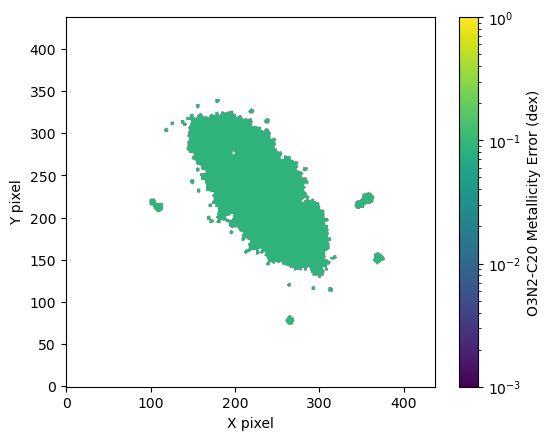

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:91: RuntimeWarning: divide by zero encountered in divide
  nii_ha = nii6583_flux / ha6562_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: invalid value encountered in divide
  o3n2_ratio = np.log10(oiii_hb / nii_ha)


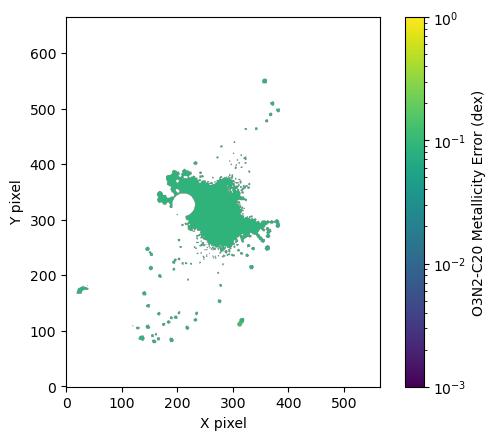

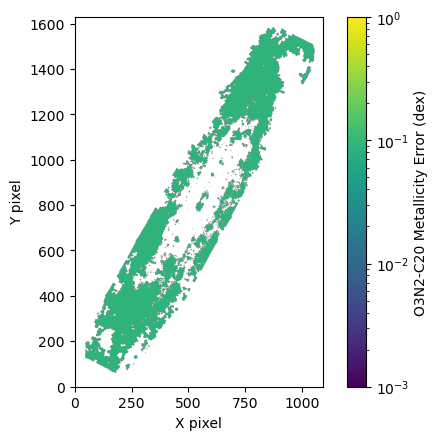

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in divide
  o3n2_ratio = np.log10(oiii_hb / nii_ha)


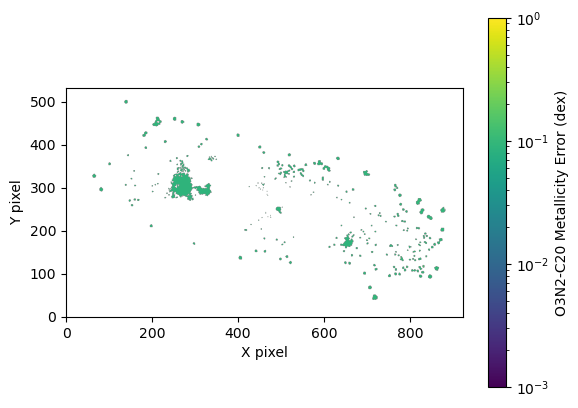

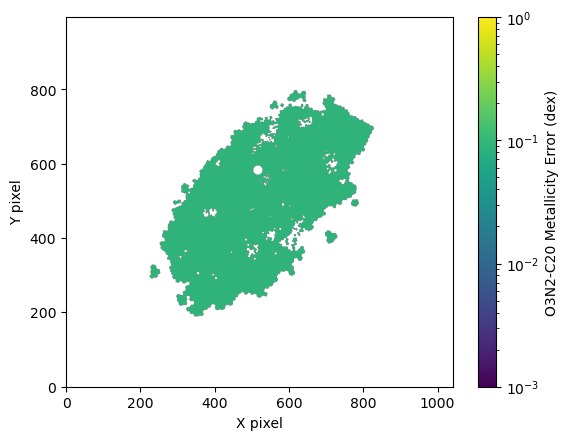

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:91: RuntimeWarning: invalid value encountered in divide
  nii_ha = nii6583_flux / ha6562_flux


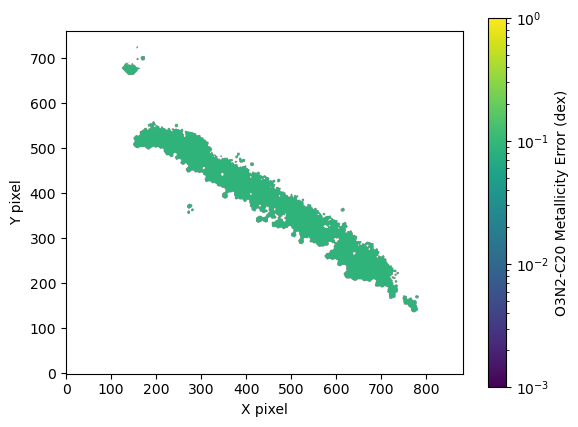

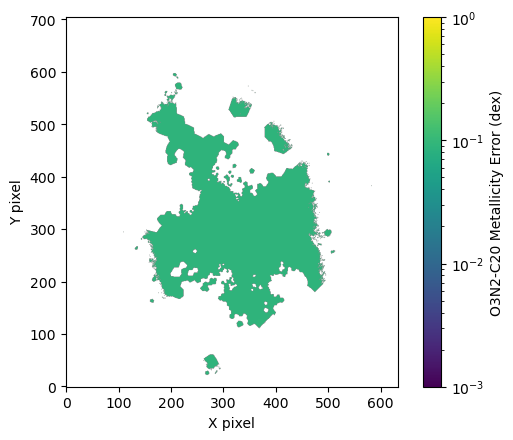

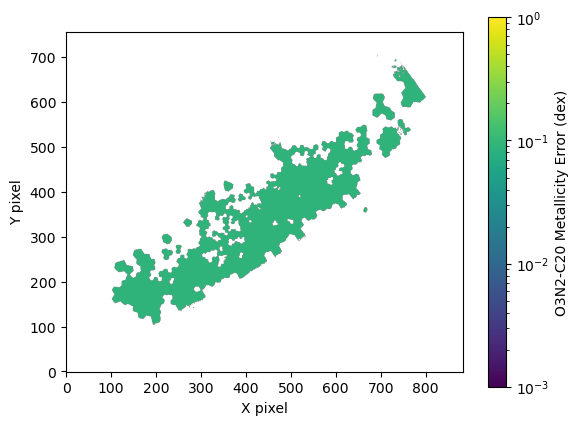

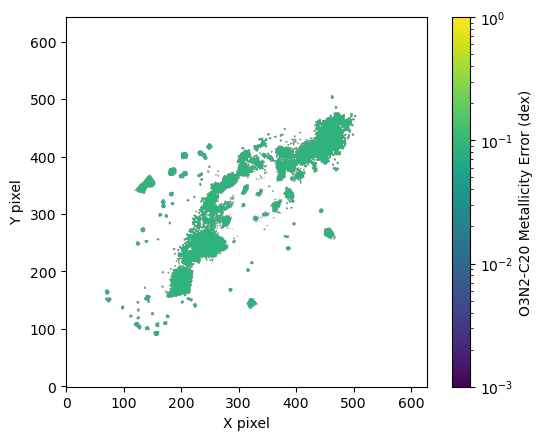

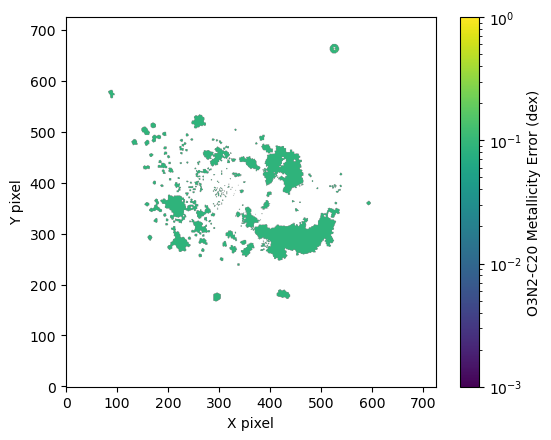

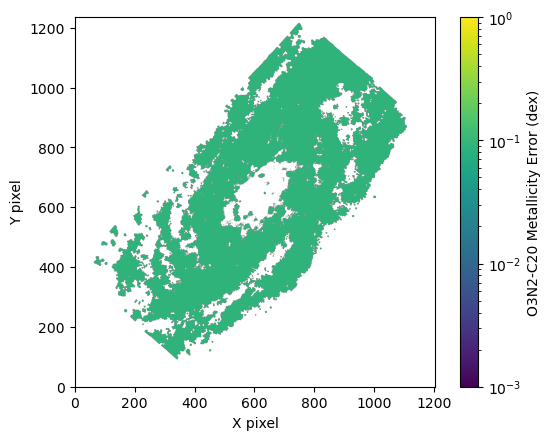

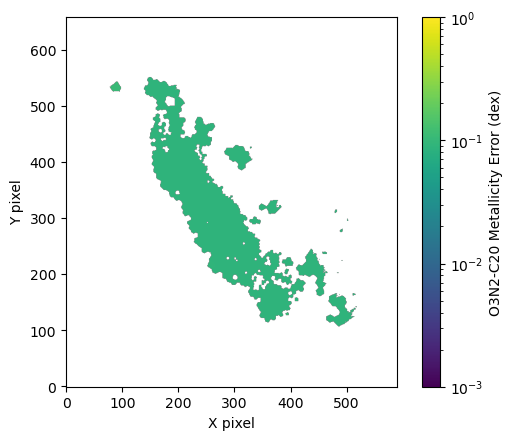

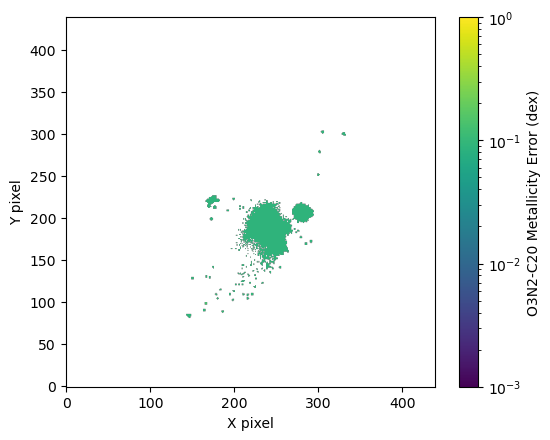

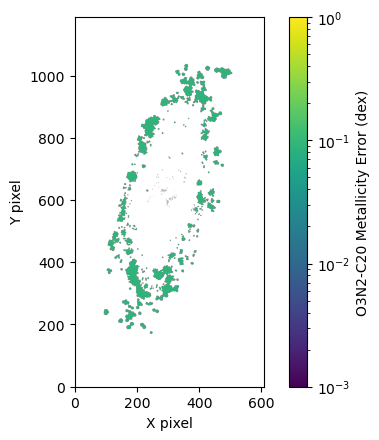

In [2]:
# Show O3N2-C20 Metallicity Error (dex)
for idx, gal in enumerate(galaxies):
    sigM, sigSFR, hb4861_flux, oiii5006_flux, nii6583_flux, ha6562_flux, hb4861_flux_err, oiii5006_flux_err, nii6583_flux_err, ha6562_flux_err, oh_d16_sf = load_maps(gal)
    oh_o3n2_c20, oh_o3n2_c20_err, good_mask = calculate_o3n2_c20_metallicity(hb4861_flux, oiii5006_flux, nii6583_flux, ha6562_flux, 
                                                                              hb4861_flux_err, oiii5006_flux_err, nii6583_flux_err, ha6562_flux_err, oh_d16_sf)
    import matplotlib.colors as colors
    plt.imshow(oh_o3n2_c20_err, origin='lower', cmap='viridis', 
               norm=colors.LogNorm(vmin=0.001, vmax=1))
    plt.colorbar(label='O3N2-C20 Metallicity Error (dex)')
    plt.xlabel('X pixel')
    plt.ylabel('Y pixel')
    plt.show()

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:90: RuntimeWarning: divide by zero encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:90: RuntimeWarning: invalid value encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:93: RuntimeWarning: divide by zero encountered in divide
  sii_hb = sii_total / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: invalid value encountered in divide
  o3s2_ratio = np.log10(oiii_hb / sii_hb)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: divide by zero encountered in log10
  o3s2_ratio = np.log10(oiii_hb / sii_hb)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:280: UserWarning: *c* argument looks like a s

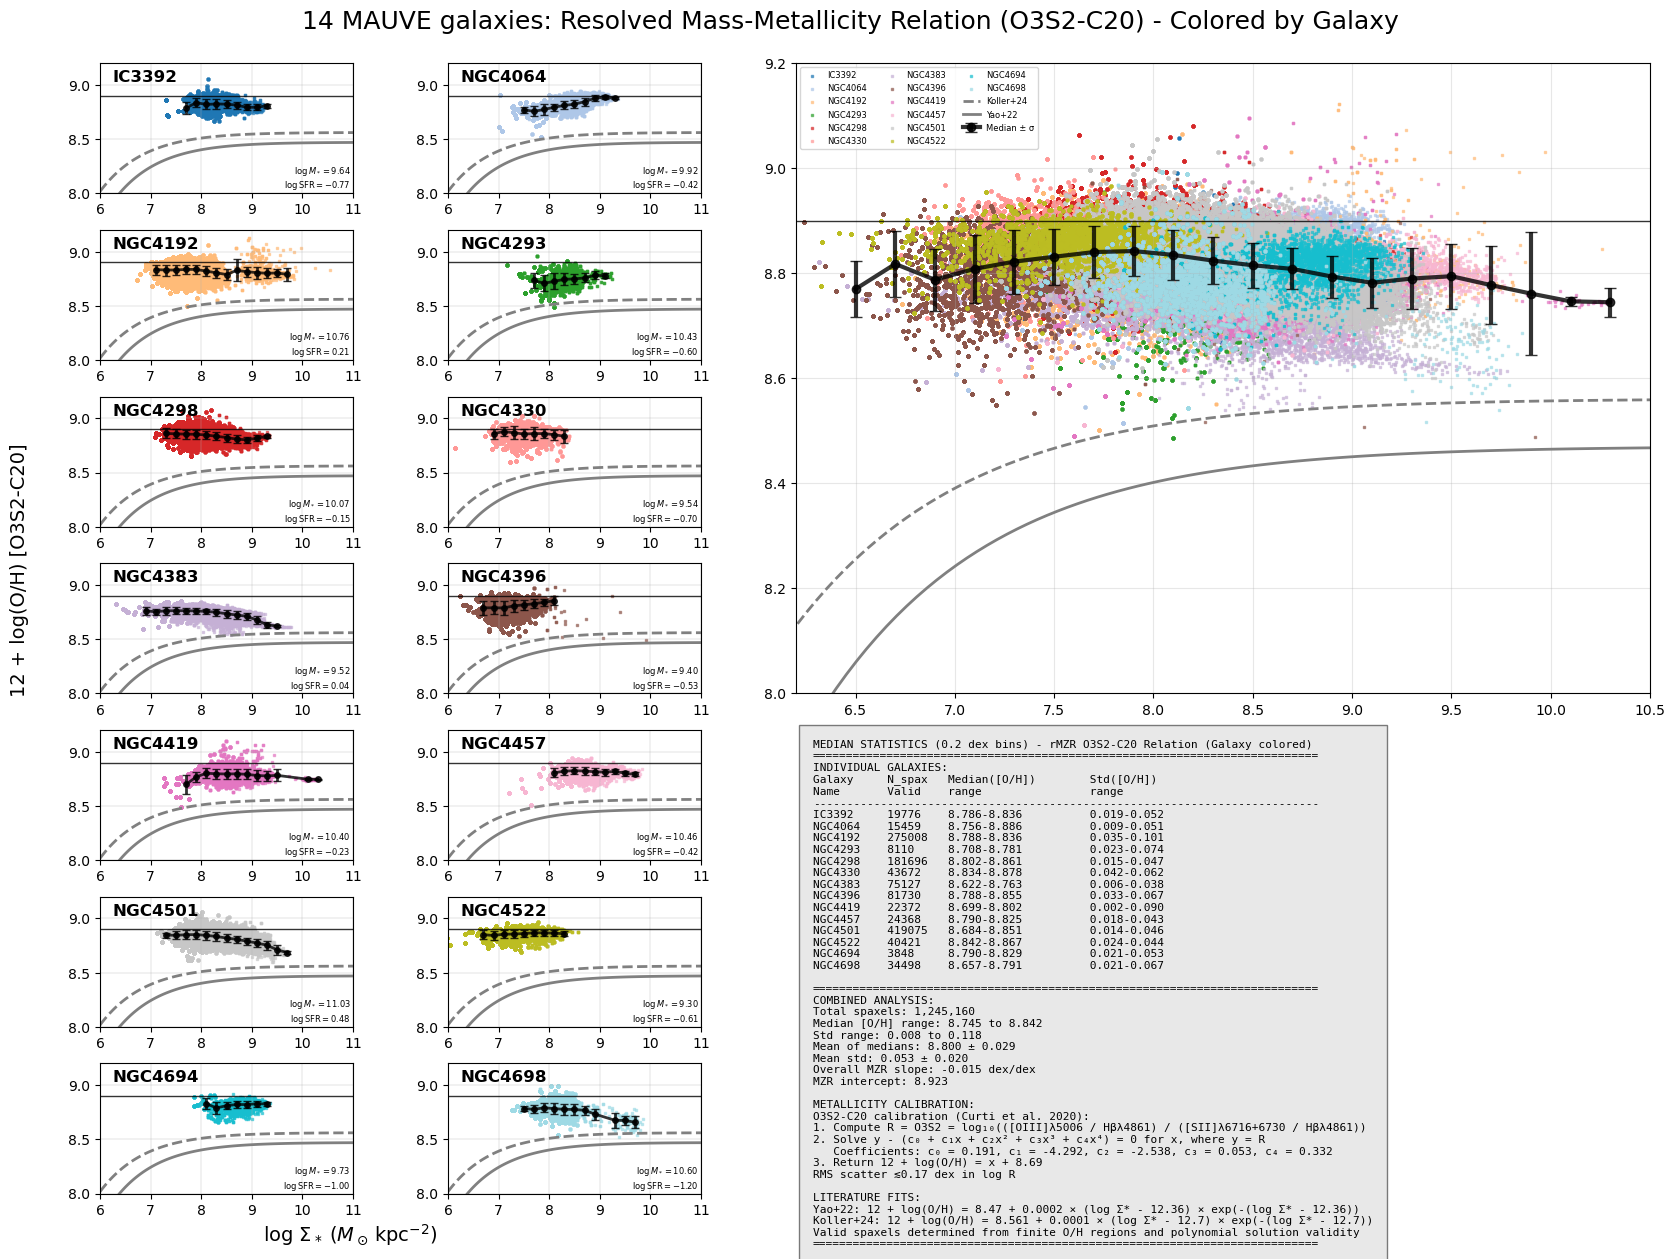

In [3]:
# ------------------------------------------------------------------
# COMPREHENSIVE LAYOUT: Individual galaxies + Combined plot + Statistics (rMZR O3S2-C20 Relation - Galaxy colored)
# 4-column layout: Cols 1-2 = Individual galaxies, Col 3 = Combined plot, Col 4 = Statistics
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy.io import fits
import itertools
import re  # Add this import for regex

# 0 · discover galaxies & colour palette
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]
ngal = len(galaxies)
assert ngal <= 14, "This layout assumes ≤ 14 galaxies."

# Create distinct colors for each galaxy
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, ngal))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

def load_maps(gal):
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR = h['LOGSFR_SURFACE_DENSITY_SF'].data
        # Load emission line fluxes for O3S2 ratio
        hb4861_flux = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux = h['SII6716_FLUX_corr'].data
        sii6730_flux = h['SII6730_FLUX_corr'].data
        # Load emission line flux errors
        hb4861_flux_err = h['HB4861_FLUX_ERR'].data
        oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data
        sii6716_flux_err = h['SII6716_FLUX_ERR'].data
        sii6730_flux_err = h['SII6730_FLUX_ERR'].data
        # Load valid O/H data to determine good spaxels
        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None
    return sigM, sigSFR, hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux, hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf

# Error propogation for BPT diagrams (sigma of log_10(numerator/denominator))
def bpt_error_propagation(numerator, denominator, numerator_err, denominator_err):
    """
    Calculate the propagated error for the BPT ratio log10(numerator/denominator).
    
    Parameters:
    numerator (np.ndarray): The numerator values.
    denominator (np.ndarray): The denominator values.
    numerator_err (np.ndarray): The error in the numerator.
    denominator_err (np.ndarray): The error in the denominator.
    
    Returns:
    np.ndarray: The propagated error for the BPT ratio.
    """
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = numerator / denominator
        log_ratio = np.log10(ratio)
        log_ratio_err = 1/(np.log(10)) * np.sqrt((numerator_err / numerator)**2 + (denominator_err / denominator)**2)
        return log_ratio_err

def calculate_o3s2_c20_metallicity(hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux, 
                                   hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, 
                                   oh_d16_sf):
    """Calculate [O/H] using O3S2-C20 calibration from Curti+2020 with error propagation"""
    # Use finite O/H values to determine valid spaxels
    if oh_d16_sf is not None:
        good_mask = np.isfinite(oh_d16_sf)
    else:
        # Fallback: use basic finite checks on emission lines
        good_mask = (np.isfinite(hb4861_flux) & np.isfinite(oiii5006_flux) &
                    np.isfinite(sii6716_flux) & np.isfinite(sii6730_flux) &
                    (hb4861_flux > 0) & (oiii5006_flux > 0) &
                    (sii6716_flux > 0) & (sii6730_flux > 0))
    
    # Additional checks for positive fluxes and finite errors where O/H is valid
    good_mask = (good_mask & (hb4861_flux > 0) & (oiii5006_flux > 0) & (sii6716_flux > 0) & (sii6730_flux > 0) &
                 np.isfinite(hb4861_flux_err) & np.isfinite(oiii5006_flux_err) & 
                 np.isfinite(sii6716_flux_err) & np.isfinite(sii6730_flux_err))
    
    # Initialize output arrays
    oh_o3s2_c20 = np.full_like(hb4861_flux, np.nan)
    oh_o3s2_c20_err = np.full_like(hb4861_flux, np.nan)
    
    # Calculate line ratios and errors
    oiii_hb = oiii5006_flux / hb4861_flux
    sii_total = sii6716_flux + sii6730_flux  # Total [SII] flux
    sii_total_err = np.sqrt(sii6716_flux_err**2 + sii6730_flux_err**2)  # Error for sum
    sii_hb = sii_total / hb4861_flux
    
    # Calculate O3S2 ratio: ([OIII]/Hβ) / ([SII]/Hβ) = [OIII]/[SII]
    o3s2_ratio = np.log10(oiii_hb / sii_hb)
    
    # Calculate errors for the line ratios using error propagation
    oiii_hb_err = bpt_error_propagation(oiii5006_flux, hb4861_flux, oiii5006_flux_err, hb4861_flux_err)
    sii_hb_err = bpt_error_propagation(sii_total, hb4861_flux, sii_total_err, hb4861_flux_err)
    
    # Error for O3S2 = log10(OIII/Hb / SII/Hb) = log10(OIII/Hb) - log10(SII/Hb)
    # Error propagation: sqrt(err1^2 + err2^2) for difference of independent variables
    o3s2_ratio_err = np.sqrt(oiii_hb_err**2 + sii_hb_err**2)
    
    # Apply O3S2-C20 calibration (Curti+2020)
    # Step 1: Compute R = O3S2 and y = log10(R)
    R = o3s2_ratio  # This is already log10(O3S2)
    y = R
    y_err = o3s2_ratio_err
    
    # Step 2: Solve polynomial equation y - (c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4) = 0 for x
    # Coefficients from Curti+2020 for O3S2
    c0 = 0.191
    c1 = -4.292
    c2 = -2.538
    c3 = 0.053
    c4 = 0.332
    
    # This is now a 4th order polynomial: c4*x^4 + c3*x^3 + c2*x^2 + c1*x + (c0 - y) = 0
    # We need to solve this numerically for each valid spaxel
    combined_mask = np.copy(good_mask)
    
    if np.any(good_mask):
        valid_indices = np.where(good_mask)
        for i in range(len(valid_indices[0])):
            idx_y, idx_x = valid_indices[0][i], valid_indices[1][i]
            y_val = y[idx_y, idx_x]
            y_err_val = y_err[idx_y, idx_x]
            
            # Polynomial coefficients for numpy.roots (highest degree first)
            poly_coeffs = [c4, c3, c2, c1, (c0 - y_val)]
            roots = np.roots(poly_coeffs)
            
            # Select the real root that gives reasonable metallicity values
            real_roots = roots[np.isreal(roots)].real
            if len(real_roots) > 0:
                # Choose root that gives reasonable x values (around -1 to 1 for typical metallicities)
                reasonable_roots = real_roots[(real_roots >= -2) & (real_roots <= 2)]
                if len(reasonable_roots) > 0:
                    x_final = reasonable_roots[0]  # Take first reasonable root
                    
                    # Calculate error in x using derivative approach
                    # For equation f(x,y) = y - (c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4) = 0
                    # df/dx = -(c1 + 2*c2*x + 3*c3*x^2 + 4*c4*x^3), df/dy = 1
                    # x_err = |df/dy| * y_err / |df/dx| = y_err / (|c1| + |2*c2*x| + |3*c3*x^2| + |4*c4*x^3|)
                    derivative_x = (np.abs(c1 + 2*c2*x_final + 3*c3*x_final**2 + 4*c4*x_final**3))
                    x_err = y_err_val / derivative_x
                    
                    oh_o3s2_c20[idx_y, idx_x] = x_final + 8.69
                    # Add intrinsic fitting error from O3S2-C20 calibration (0.11 dex)
                    fitting_err = 0.11  # dex
                    oh_o3s2_c20_err[idx_y, idx_x] = np.sqrt(x_err**2 + fitting_err**2)
                else:
                    combined_mask[idx_y, idx_x] = False
            else:
                combined_mask[idx_y, idx_x] = False
    
    # Update the combined mask to only include spaxels where we found valid solutions
    combined_mask = combined_mask & np.isfinite(oh_o3s2_c20)
    
    return oh_o3s2_c20, oh_o3s2_c20_err, combined_mask

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_sfr(galaxy_name):
    """Extract total SFR from SFR log file. Returns log10(M☉/yr) value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total Halpha SFR:.*?in log10 scale:\s*([\d.-]+)\s*log\(M☉/yr\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading SFR log for {galaxy_name}: {e}")
        return None

def calculate_median_statistics(x, y, x_range=(6, 11), bin_width=0.2):
    """Calculate median and std in binned intervals"""
    x_bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)
    x_centers = (x_bins[:-1] + x_bins[1:]) / 2
    
    medians = []
    stds = []
    x_valid = []
    
    for i in range(len(x_bins) - 1):
        mask = (x >= x_bins[i]) & (x < x_bins[i + 1])
        if len(np.unique(x[mask])) >= 10:  # Need at least 10 distinct x values
            y_bin = y[mask]
            medians.append(np.median(y_bin))
            stds.append(np.std(y_bin))
            x_valid.append(x_centers[i])
    
    return np.array(x_valid), np.array(medians), np.array(stds)

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)
    
    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]
    
    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color='gray')
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color='gray')

# 1 · Create comprehensive figure with 4-column layout
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(nrows=8, ncols=4, figure=fig,
              width_ratios=[1, 1, 1.5, 1.5],  # Cols 3&4 slightly wider
              height_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1],  # Row 0 for colorbar
              wspace=0.3, hspace=0.3)

plot_idx = 0
individual_stats = []

# COLUMNS 1-2: Individual galaxy plots
for idx, gal in enumerate(galaxies):
    sigM, sigSFR, hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux, hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf = load_maps(gal)
    oh_o3s2_c20, oh_o3s2_c20_err, good_mask = calculate_o3s2_c20_metallicity(hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux, 
                                                                              hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf)
    
    if not np.any(good_mask):
        print(f"Skipping {gal}: no valid data points")
        continue
    
    row = (plot_idx // 2) + 1  # Start from row 1 (row 0 for colorbar)
    col = plot_idx % 2
    plot_idx += 1

    axP = fig.add_subplot(gs[row, col])
    
    x_data, y_data, sfr_data = sigM[good_mask], oh_o3s2_c20[good_mask], sigSFR[good_mask]
    
    # Calculate median statistics
    x_median, y_median, y_std = calculate_median_statistics(x_data, y_data)
    individual_stats.append((gal, x_median, y_median, y_std, len(x_data)))
    
    # Scatter plot colored by galaxy
    scatter = axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')
    
    # Plot median with error bars
    if len(x_median) > 0:
        axP.errorbar(x_median, y_median, yerr=y_std, fmt='ko-', linewidth=2, 
                    markersize=4, capsize=3, alpha=0.8)
    
    # Add literature fits to individual panels (no legend)
    plot_literature_mzr_fits(axP, show_legend=False)
    
    # Add galaxy name in top left corner
    axP.text(0.05, 0.95, gal, transform=axP.transAxes, fontsize=12, fontweight='bold',
             va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', alpha=0.8, edgecolor='none'))
    
    # Bottom right: total stellar mass and SFR from log files
    total_mass = extract_total_stellar_mass(gal)
    total_sfr = extract_total_sfr(gal)
    
    if total_mass is not None and total_sfr is not None:
        log_text = fr'$\log M_* = {total_mass:.2f}$' '\n' fr'$\log \mathrm{{SFR}} = {total_sfr:.2f}$'
        axP.text(0.99, 0.01, log_text,
                 transform=axP.transAxes, va='bottom', ha='right', fontsize=6,
                 bbox=dict(facecolor='none', alpha=0.8, edgecolor='none', pad=2))
    
    axP.set_xlim(6, 11)
    axP.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
    axP.grid(True, lw=0.25)
    axP.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)      # For individual plots

# COLUMNS 3-4: Combined plot - Upper panel
ax_combined = fig.add_subplot(gs[1:5, 2:4])  # Spans rows 1-4, columns 2-3

# Collect all data for combined analysis
all_x, all_y, all_gal_ids = [], [], []
galaxy_counts = {}

for idx, gal in enumerate(galaxies):
    sigM, sigSFR, hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux, hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf = load_maps(gal)
    oh_o3s2_c20, oh_o3s2_c20_err, good_mask = calculate_o3s2_c20_metallicity(hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux, 
                                                                              hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf)
    
    if np.any(good_mask):
        x_data, y_data = sigM[good_mask], oh_o3s2_c20[good_mask]
        all_x.extend(x_data)
        all_y.extend(y_data)
        all_gal_ids.extend([idx] * len(x_data))  # Store galaxy index for coloring
        galaxy_counts[gal] = len(x_data)
    else:
        galaxy_counts[gal] = 0

all_x, all_y, all_gal_ids = np.array(all_x), np.array(all_y), np.array(all_gal_ids)

# Calculate combined median statistics
x_median_combined, y_median_combined, y_std_combined = calculate_median_statistics(all_x, all_y)

# Scatter plot colored by galaxy for combined data
for idx, gal in enumerate(galaxies):
    mask = all_gal_ids == idx
    if np.any(mask):
        ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal], 
                           s=1, alpha=0.6, marker=',', label=gal)

# Plot combined median with error bars
if len(x_median_combined) > 0:
    ax_combined.errorbar(x_median_combined, y_median_combined, yerr=y_std_combined, 
                        fmt='ko-', linewidth=3, markersize=6, capsize=4, alpha=0.8, label='Median ± σ')

# Add literature fits to combined panel (with legend)
plot_literature_mzr_fits(ax_combined, show_legend=True)

# Add legend with small font - only show galaxies
ax_combined.legend(fontsize=6, ncol=3, loc='upper left', markerscale=1)

ax_combined.set_xlim(6.2, 10.5)
ax_combined.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
ax_combined.grid(True, alpha=0.3)
ax_combined.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)  # For combined plot

# COLUMNS 3-4: Statistics table - Lower panel
ax_stats = fig.add_subplot(gs[5:8, 2:4])  # Spans rows 5-7, columns 2-3
ax_stats.axis('off')

# Create comprehensive statistics text
stats_table = "MEDIAN STATISTICS (0.2 dex bins) - rMZR O3S2-C20 Relation (Galaxy colored)\n"
stats_table += "="*75 + "\n"
stats_table += "INDIVIDUAL GALAXIES:\n"
stats_table += f"{'Galaxy':<10} {'N_spax':<8} {'Median([O/H])':<20} {'Std([O/H])':<15}\n"
stats_table += f"{'Name':<10} {'Valid':<8} {'range':<20} {'range':<15}\n"
stats_table += "-"*75 + "\n"

for gal, x_median, y_median, y_std, n_spax in individual_stats:
    if len(y_median) > 0:
        median_range = f"{y_median.min():.3f}-{y_median.max():.3f}"
        std_range = f"{y_std.min():.3f}-{y_std.max():.3f}"
    else:
        median_range = "N/A"
        std_range = "N/A"
    
    stats_table += f"{gal:<10} {n_spax:<8} {median_range:<20} {std_range:<15}\n"

stats_table += "\n" + "="*75 + "\n"
stats_table += "COMBINED ANALYSIS:\n"
stats_table += f"Total spaxels: {len(all_x):,}\n"
if len(y_median_combined) > 0:
    stats_table += f"Median [O/H] range: {y_median_combined.min():.3f} to {y_median_combined.max():.3f}\n"
    stats_table += f"Std range: {y_std_combined.min():.3f} to {y_std_combined.max():.3f}\n"
    stats_table += f"Mean of medians: {np.mean(y_median_combined):.3f} ± {np.std(y_median_combined):.3f}\n"
    stats_table += f"Mean std: {np.mean(y_std_combined):.3f} ± {np.std(y_std_combined):.3f}\n"
    
    # Calculate overall MZR gradient (slope)
    if len(x_median_combined) > 3:
        slope, intercept = np.polyfit(x_median_combined, y_median_combined, 1)
        stats_table += f"Overall MZR slope: {slope:.3f} dex/dex\n"
        stats_table += f"MZR intercept: {intercept:.3f}\n"

stats_table += "\nMETALLICITY CALIBRATION:\n"
stats_table += "O3S2-C20 calibration (Curti et al. 2020):\n"
stats_table += "1. Compute R = O3S2 = log₁₀(([OIII]λ5006 / Hβλ4861) / ([SII]λ6716+6730 / Hβλ4861))\n"
stats_table += "2. Solve y - (c₀ + c₁x + c₂x² + c₃x³ + c₄x⁴) = 0 for x, where y = R\n"
stats_table += "   Coefficients: c₀ = 0.191, c₁ = -4.292, c₂ = -2.538, c₃ = 0.053, c₄ = 0.332\n"
stats_table += "3. Return 12 + log(O/H) = x + 8.69\n"
stats_table += "RMS scatter ≲0.17 dex in log R\n"
stats_table += "\nLITERATURE FITS:\n"
stats_table += "Yao+22: 12 + log(O/H) = 8.47 + 0.0002 × (log Σ* - 12.36) × exp(-(log Σ* - 12.36))\n"
stats_table += "Koller+24: 12 + log(O/H) = 8.561 + 0.0001 × (log Σ* - 12.7) × exp(-(log Σ* - 12.7))\n"
stats_table += "Valid spaxels determined from finite O/H regions and polynomial solution validity\n"
        
stats_table += "="*75

ax_stats.text(0.02, 0.98, stats_table, transform=ax_stats.transAxes, va='top', ha='left',
              fontsize=8, family='monospace',
              bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', pad=10))

# Global title and labels
fig.suptitle(fr'{ngal} MAUVE galaxies: Resolved Mass-Metallicity Relation (O3S2-C20) - Colored by Galaxy', 
             fontsize=18, y=0.85)

# Shared axis labels
fig.text(0.25, 0.08, r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', 
         ha='center', fontsize=14)
fig.text(0.08, 0.5, r'12 + log(O/H) [O3S2-C20]', 
         va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.show()

In [4]:
# # Show O3S2-C20 Metallicity Error (dex)
# for idx, gal in enumerate(galaxies):
#     sigM, sigSFR, hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux, hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf = load_maps(gal)
#     oh_o3s2_c20, oh_o3s2_c20_err, good_mask = calculate_o3s2_c20_metallicity(hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux, 
#                                                                               hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf)
#     import matplotlib.colors as colors
#     plt.imshow(oh_o3s2_c20_err, origin='lower', cmap='viridis', 
#                norm=colors.LogNorm(vmin=0.001, vmax=0.1))
#     plt.colorbar(label='O3S2-C20 Metallicity Error (dex)')
#     plt.xlabel('X pixel')
#     plt.ylabel('Y pixel')
#     plt.show()

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2718720312.py:296: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2718720312.py:357: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal],
/var/folders/r

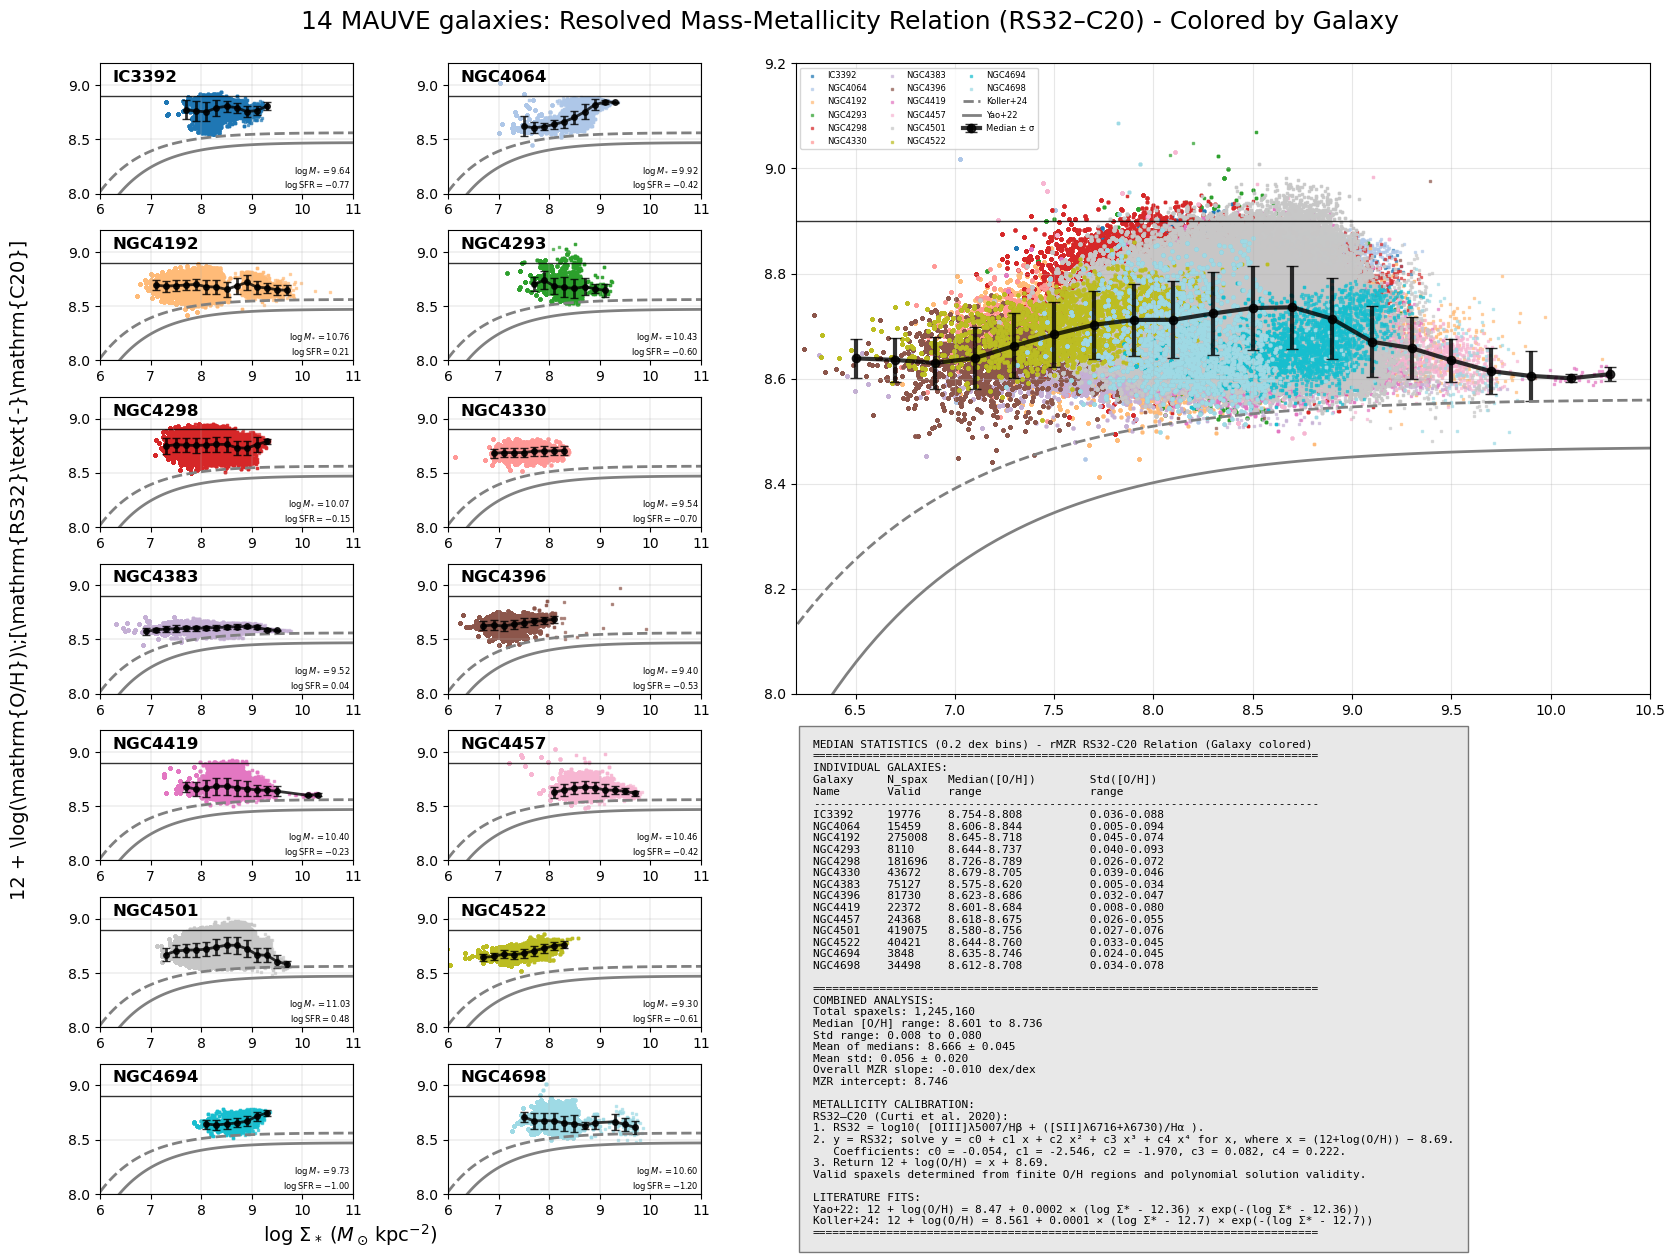

In [5]:
# ------------------------------------------------------------------
# COMPREHENSIVE LAYOUT: Individual galaxies + Combined plot + Statistics (rMZR RS32-C20 Relation - Galaxy colored)
# 4-column layout: Cols 1-2 = Individual galaxies, Col 3 = Combined plot, Col 4 = Statistics
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy.io import fits
import itertools
import re  # Add this import for regex

# 0 · discover galaxies & colour palette
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]
ngal = len(galaxies)
assert ngal <= 14, "This layout assumes ≤ 14 galaxies."

# Create distinct colors for each galaxy
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, ngal))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

def load_maps(gal):
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR        = h['LOGSFR_SURFACE_DENSITY_SF'].data
        hb4861_flux   = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux  = h['SII6716_FLUX_corr'].data
        sii6730_flux  = h['SII6730_FLUX_corr'].data
        # Load flux errors
        hb4861_flux_err   = h['HB4861_FLUX_ERR'].data
        oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data
        sii6716_flux_err  = h['SII6716_FLUX_ERR'].data
        sii6730_flux_err  = h['SII6730_FLUX_ERR'].data

        # --- Hα: try a few common extension names (kept minimal & robust) ---
        ha_key_candidates = (
            'HA6563_FLUX_corr', 'HA6562_FLUX_corr',
            'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr'
        )
        ha_err_key_candidates = (
            'HA6563_FLUX_ERR', 'HA6562_FLUX_ERR',
            'HALPHA6563_FLUX_ERR', 'HALPHA_FLUX_ERR'
        )
        ha6563_flux = None
        ha6563_flux_err = None
        for k in ha_key_candidates:
            if k in h:
                ha6563_flux = h[k].data
                break
        for k in ha_err_key_candidates:
            if k in h:
                ha6563_flux_err = h[k].data
                break
        if ha6563_flux is None:
            raise KeyError(f"No Hα flux HDU found for {gal}. Tried: {ha_key_candidates}")
        if ha6563_flux_err is None:
            raise KeyError(f"No Hα flux error HDU found for {gal}. Tried: {ha_err_key_candidates}")

        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None
    return sigM, sigSFR, hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux, hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, ha6563_flux_err, oh_d16_sf

# Error propogation for BPT diagrams (sigma of log_10(numerator/denominator))
def bpt_error_propagation(numerator, denominator, numerator_err, denominator_err):
    """
    Calculate the propagated error for the BPT ratio log10(numerator/denominator).
    
    Parameters:
    numerator (np.ndarray): The numerator values.
    denominator (np.ndarray): The denominator values.
    numerator_err (np.ndarray): The error in the numerator.
    denominator_err (np.ndarray): The error in the denominator.
    
    Returns:
    np.ndarray: The propagated error for the BPT ratio.
    """
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = numerator / denominator
        log_ratio = np.log10(ratio)
        log_ratio_err = 1/(np.log(10)) * np.sqrt((numerator_err / numerator)**2 + (denominator_err / denominator)**2)
        return log_ratio_err

def calculate_rs32_c20_metallicity(hb4861_flux, ha6563_flux,
                                   oiii5006_flux, sii6716_flux, sii6730_flux,
                                   hb4861_flux_err, ha6563_flux_err,
                                   oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err,
                                   oh_d16_sf,
                                   coeffs=(-0.054, -2.546, -1.970, 0.082, 0.222)):
    """
    RS32–C20 calibration (Curti+2020; user-provided coefficients) with error propagation:
      RS32 = log10( [OIII]/Hβ + ([SII]6716+6730)/Hα )
      Let y = RS32 and x = (12+log(O/H)) - 8.69
      Then: y = c0 + c1 x + c2 x^2 + c3 x^3 + c4 x^4
      Solve per spaxel for x, return 12+log(O/H) = x + 8.69
    """
    c0, c1, c2, c3, c4 = coeffs

    # Good spaxels: prefer finite O/H mask if present; enforce positive, finite fluxes and errors
    if oh_d16_sf is not None:
        good_mask = np.isfinite(oh_d16_sf)
    else:
        good_mask = np.ones_like(hb4861_flux, dtype=bool)

    pos = (
        np.isfinite(hb4861_flux) & np.isfinite(ha6563_flux) &
        np.isfinite(oiii5006_flux) & np.isfinite(sii6716_flux) & np.isfinite(sii6730_flux) &
        np.isfinite(hb4861_flux_err) & np.isfinite(ha6563_flux_err) &
        np.isfinite(oiii5006_flux_err) & np.isfinite(sii6716_flux_err) & np.isfinite(sii6730_flux_err) &
        (hb4861_flux > 0) & (ha6563_flux > 0) &
        (oiii5006_flux > 0) & (sii6716_flux > 0) & (sii6730_flux > 0)
    )
    good_mask &= pos

    oh_rs32_c20 = np.full_like(hb4861_flux, np.nan, dtype=float)
    oh_rs32_c20_err = np.full_like(hb4861_flux, np.nan, dtype=float)

    if np.any(good_mask):
        # RS32 (linear inside the log): [OIII]/Hβ + [SII]/Hα
        oiii_hb = oiii5006_flux[good_mask] / hb4861_flux[good_mask]
        sii_total = sii6716_flux[good_mask] + sii6730_flux[good_mask]
        sii_total_err = np.sqrt(sii6716_flux_err[good_mask]**2 + sii6730_flux_err[good_mask]**2)
        sii_ha = sii_total / ha6563_flux[good_mask]
        
        r_lin = oiii_hb + sii_ha
        r_lin = np.where(r_lin > 0, r_lin, np.nan)
        y = np.log10(r_lin)
        
        # Calculate errors for the line ratios using error propagation
        oiii_hb_err = bpt_error_propagation(oiii5006_flux[good_mask], hb4861_flux[good_mask], 
                                            oiii5006_flux_err[good_mask], hb4861_flux_err[good_mask])
        sii_ha_err = bpt_error_propagation(sii_total, ha6563_flux[good_mask], 
                                           sii_total_err, ha6563_flux_err[good_mask])
        
        # Error for RS32 = log10(OIII/Hb + SII/Ha)
        # For f = A + B, df = sqrt(dA^2 + dB^2)
        # For g = log10(f), dg = (1/ln(10)) * df/f
        r_lin_err = np.sqrt(oiii_hb_err**2 + sii_ha_err**2)
        y_err = (1/np.log(10)) * (r_lin_err / r_lin)

        # Solve quartic per valid pixel:
        # c4*x^4 + c3*x^3 + c2*x^2 + c1*x + (c0 - y) = 0
        idxs = np.argwhere(good_mask)
        for idx_in_good, (iy, ix) in enumerate(idxs):
            y_val = y[idx_in_good]
            y_err_val = y_err[idx_in_good]
            if not np.isfinite(y_val):
                continue
            roots = np.roots([c4, c3, c2, c1, (c0 - y_val)])
            real = roots[np.isreal(roots)].real
            if real.size:
                # Sensible metallicity range for Te-anchored scales:
                # 12+log(O/H) ~ 8.0–8.9 ⇒ x = (12+log(O/H))-8.69 ∈ [-0.7, +0.3]
                phys = real[(real >= -0.7) & (real <= 0.3)]
                cand = phys if phys.size else real  # fallback if nothing in phys range
                # choose the root that best reproduces y
                y_pred = c0 + c1*cand + c2*cand**2 + c3*cand**3 + c4*cand**4
                x_final = cand[np.argmin(np.abs(y_pred - y_val))]
                
                # Calculate error in x using derivative approach
                # For equation f(x,y) = y - (c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4) = 0
                # df/dx = -(c1 + 2*c2*x + 3*c3*x^2 + 4*c4*x^3), df/dy = 1
                # x_err = |df/dy| * y_err / |df/dx| = y_err / (|c1| + |2*c2*x| + |3*c3*x^2| + |4*c4*x^3|)
                derivative_x = (np.abs(c1 + 2*c2*x_final + 3*c3*x_final**2 + 4*c4*x_final**3))
                x_err = y_err_val / derivative_x
                
                oh_rs32_c20[iy, ix] = x_final + 8.69
                # Add intrinsic fitting error from RS32-C20 calibration (0.08 dex)
                fitting_err = 0.08  # dex
                oh_rs32_c20_err[iy, ix] = np.sqrt(x_err**2 + fitting_err**2)

    combined_mask = good_mask & np.isfinite(oh_rs32_c20)
    return oh_rs32_c20, oh_rs32_c20_err, combined_mask

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_sfr(galaxy_name):
    """Extract total SFR from SFR log file. Returns log10(M☉/yr) value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total Halpha SFR:.*?in log10 scale:\s*([\d.-]+)\s*log\(M☉/yr\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading SFR log for {galaxy_name}: {e}")
        return None

def calculate_median_statistics(x, y, x_range=(6, 11), bin_width=0.2):
    """Calculate median and std in binned intervals"""
    x_bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)
    x_centers = (x_bins[:-1] + x_bins[1:]) / 2

    medians = []
    stds = []
    x_valid = []

    for i in range(len(x_bins) - 1):
        mask = (x >= x_bins[i]) & (x < x_bins[i + 1])
        if len(np.unique(x[mask])) >= 10:  # Need at least 10 distinct x values
            y_bin = y[mask]
            medians.append(np.median(y_bin))
            stds.append(np.std(y_bin))
            x_valid.append(x_centers[i])

    return np.array(x_valid), np.array(medians), np.array(stds)

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)

    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]

    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color='gray')
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color='gray')

# 1 · Create comprehensive figure with 4-column layout
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(nrows=8, ncols=4, figure=fig,
              width_ratios=[1, 1, 1.5, 1.5],  # Cols 3&4 slightly wider
              height_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1],  # Row 0 for colorbar
              wspace=0.3, hspace=0.3)

plot_idx = 0
individual_stats = []

# COLUMNS 1-2: Individual galaxy plots
for idx, gal in enumerate(galaxies):
    sigM, sigSFR, hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux, hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, ha6563_flux_err, oh_d16_sf = load_maps(gal)
    oh_rs32_c20, oh_rs32_c20_err, good_mask = calculate_rs32_c20_metallicity(
        hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, ha6563_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )

    if not np.any(good_mask):
        print(f"Skipping {gal}: no valid data points")
        continue

    row = (plot_idx // 2) + 1  # Start from row 1 (row 0 for colorbar)
    col = plot_idx % 2
    plot_idx += 1

    axP = fig.add_subplot(gs[row, col])

    x_data, y_data, sfr_data = sigM[good_mask], oh_rs32_c20[good_mask], sigSFR[good_mask]

    # Calculate median statistics
    x_median, y_median, y_std = calculate_median_statistics(x_data, y_data)
    individual_stats.append((gal, x_median, y_median, y_std, len(x_data)))

    # Scatter plot colored by galaxy
    axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')

    # Plot median with error bars
    if len(x_median) > 0:
        axP.errorbar(x_median, y_median, yerr=y_std, fmt='ko-', linewidth=2,
                     markersize=4, capsize=3, alpha=0.8)

    # Add literature fits to individual panels (no legend)
    plot_literature_mzr_fits(axP, show_legend=False)

    # Add galaxy name in top left corner
    axP.text(0.05, 0.95, gal, transform=axP.transAxes, fontsize=12, fontweight='bold',
             va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', alpha=0.8, edgecolor='none'))

    # Bottom right: total stellar mass and SFR from log files
    total_mass = extract_total_stellar_mass(gal)
    total_sfr = extract_total_sfr(gal)

    if total_mass is not None and total_sfr is not None:
        log_text = fr'$\log M_* = {total_mass:.2f}$' '\n' fr'$\log \mathrm{{SFR}} = {total_sfr:.2f}$'
        axP.text(0.99, 0.01, log_text,
                 transform=axP.transAxes, va='bottom', ha='right', fontsize=6,
                 bbox=dict(facecolor='none', alpha=0.8, edgecolor='none', pad=2))

    axP.set_xlim(6, 11)
    axP.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
    axP.grid(True, lw=0.25)
    axP.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)      # For individual plots

# COLUMNS 3-4: Combined plot - Upper panel
ax_combined = fig.add_subplot(gs[1:5, 2:4])  # Spans rows 1-4, columns 2-3

# Collect all data for combined analysis
all_x, all_y, all_gal_ids = [], [], []
galaxy_counts = {}

for idx, gal in enumerate(galaxies):
    sigM, sigSFR, hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux, hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, ha6563_flux_err, oh_d16_sf = load_maps(gal)
    oh_rs32_c20, oh_rs32_c20_err, good_mask = calculate_rs32_c20_metallicity(
        hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, ha6563_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )

    if np.any(good_mask):
        x_data, y_data = sigM[good_mask], oh_rs32_c20[good_mask]
        all_x.extend(x_data)
        all_y.extend(y_data)
        all_gal_ids.extend([idx] * len(x_data))  # Store galaxy index for coloring
        galaxy_counts[gal] = len(x_data)
    else:
        galaxy_counts[gal] = 0

all_x, all_y, all_gal_ids = np.array(all_x), np.array(all_y), np.array(all_gal_ids)

# Calculate combined median statistics
x_median_combined, y_median_combined, y_std_combined = calculate_median_statistics(all_x, all_y)

# Scatter plot colored by galaxy for combined data
for idx, gal in enumerate(galaxies):
    mask = all_gal_ids == idx
    if np.any(mask):
        ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal],
                            s=1, alpha=0.6, marker=',', label=gal)

# Plot combined median with error bars
if len(x_median_combined) > 0:
    ax_combined.errorbar(x_median_combined, y_median_combined, yerr=y_std_combined,
                         fmt='ko-', linewidth=3, markersize=6, capsize=4, alpha=0.8, label='Median ± σ')

# Add literature fits to combined panel (with legend)
plot_literature_mzr_fits(ax_combined, show_legend=True)

# Add legend with small font - only show galaxies
ax_combined.legend(fontsize=6, ncol=3, loc='upper left', markerscale=1)

ax_combined.set_xlim(6.2, 10.5)
ax_combined.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
ax_combined.grid(True, alpha=0.3)
ax_combined.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)  # For combined plot

# COLUMNS 3-4: Statistics table - Lower panel
ax_stats = fig.add_subplot(gs[5:8, 2:4])  # Spans rows 5-7, columns 2-3
ax_stats.axis('off')

# Create comprehensive statistics text
stats_table = "MEDIAN STATISTICS (0.2 dex bins) - rMZR RS32-C20 Relation (Galaxy colored)\n"
stats_table += "="*75 + "\n"
stats_table += "INDIVIDUAL GALAXIES:\n"
stats_table += f"{'Galaxy':<10} {'N_spax':<8} {'Median([O/H])':<20} {'Std([O/H])':<15}\n"
stats_table += f"{'Name':<10} {'Valid':<8} {'range':<20} {'range':<15}\n"
stats_table += "-"*75 + "\n"

for gal, x_median, y_median, y_std, n_spax in individual_stats:
    if len(y_median) > 0:
        median_range = f"{y_median.min():.3f}-{y_median.max():.3f}"
        std_range = f"{y_std.min():.3f}-{y_std.max():.3f}"
    else:
        median_range = "N/A"
        std_range = "N/A"
    stats_table += f"{gal:<10} {n_spax:<8} {median_range:<20} {std_range:<15}\n"

stats_table += "\n" + "="*75 + "\n"
stats_table += "COMBINED ANALYSIS:\n"
stats_table += f"Total spaxels: {len(all_x):,}\n"
if len(y_median_combined) > 0:
    stats_table += f"Median [O/H] range: {y_median_combined.min():.3f} to {y_median_combined.max():.3f}\n"
    stats_table += f"Std range: {y_std_combined.min():.3f} to {y_std_combined.max():.3f}\n"
    stats_table += f"Mean of medians: {np.mean(y_median_combined):.3f} ± {np.std(y_median_combined):.3f}\n"
    stats_table += f"Mean std: {np.mean(y_std_combined):.3f} ± {np.std(y_std_combined):.3f}\n"

    # Overall MZR gradient (slope)
    if len(x_median_combined) > 3:
        slope, intercept = np.polyfit(x_median_combined, y_median_combined, 1)
        stats_table += f"Overall MZR slope: {slope:.3f} dex/dex\n"
        stats_table += f"MZR intercept: {intercept:.3f}\n"

stats_table += "\nMETALLICITY CALIBRATION:\n"
stats_table += "RS32–C20 (Curti et al. 2020):\n"
stats_table += "1. RS32 = log10( [OIII]λ5007/Hβ + ([SII]λ6716+λ6730)/Hα ).\n"
stats_table += "2. y = RS32; solve y = c0 + c1 x + c2 x² + c3 x³ + c4 x⁴ for x, where x = (12+log(O/H)) − 8.69.\n"
stats_table += "   Coefficients: c0 = -0.054, c1 = -2.546, c2 = -1.970, c3 = 0.082, c4 = 0.222.\n"
stats_table += "3. Return 12 + log(O/H) = x + 8.69.\n"
stats_table += "Valid spaxels determined from finite O/H regions and polynomial solution validity.\n"

stats_table += "\nLITERATURE FITS:\n"
stats_table += "Yao+22: 12 + log(O/H) = 8.47 + 0.0002 × (log Σ* - 12.36) × exp(-(log Σ* - 12.36))\n"
stats_table += "Koller+24: 12 + log(O/H) = 8.561 + 0.0001 × (log Σ* - 12.7) × exp(-(log Σ* - 12.7))\n"
stats_table += "="*75

ax_stats.text(0.02, 0.98, stats_table, transform=ax_stats.transAxes, va='top', ha='left',
              fontsize=8, family='monospace',
              bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', pad=10))

# Global title and labels
fig.suptitle(fr'{ngal} MAUVE galaxies: Resolved Mass-Metallicity Relation (RS32–C20) - Colored by Galaxy',
             fontsize=18, y=0.85)

# Shared axis labels
fig.text(0.25, 0.08, r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$',
         ha='center', fontsize=14)
fig.text(0.08, 0.5, r'12 + \log(\mathrm{O/H})\;[\mathrm{RS32}\text{-}\mathrm{C20}]',
         va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.show()


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1436797788.py:271: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1436797788.py:331: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal],
/var/folders/r

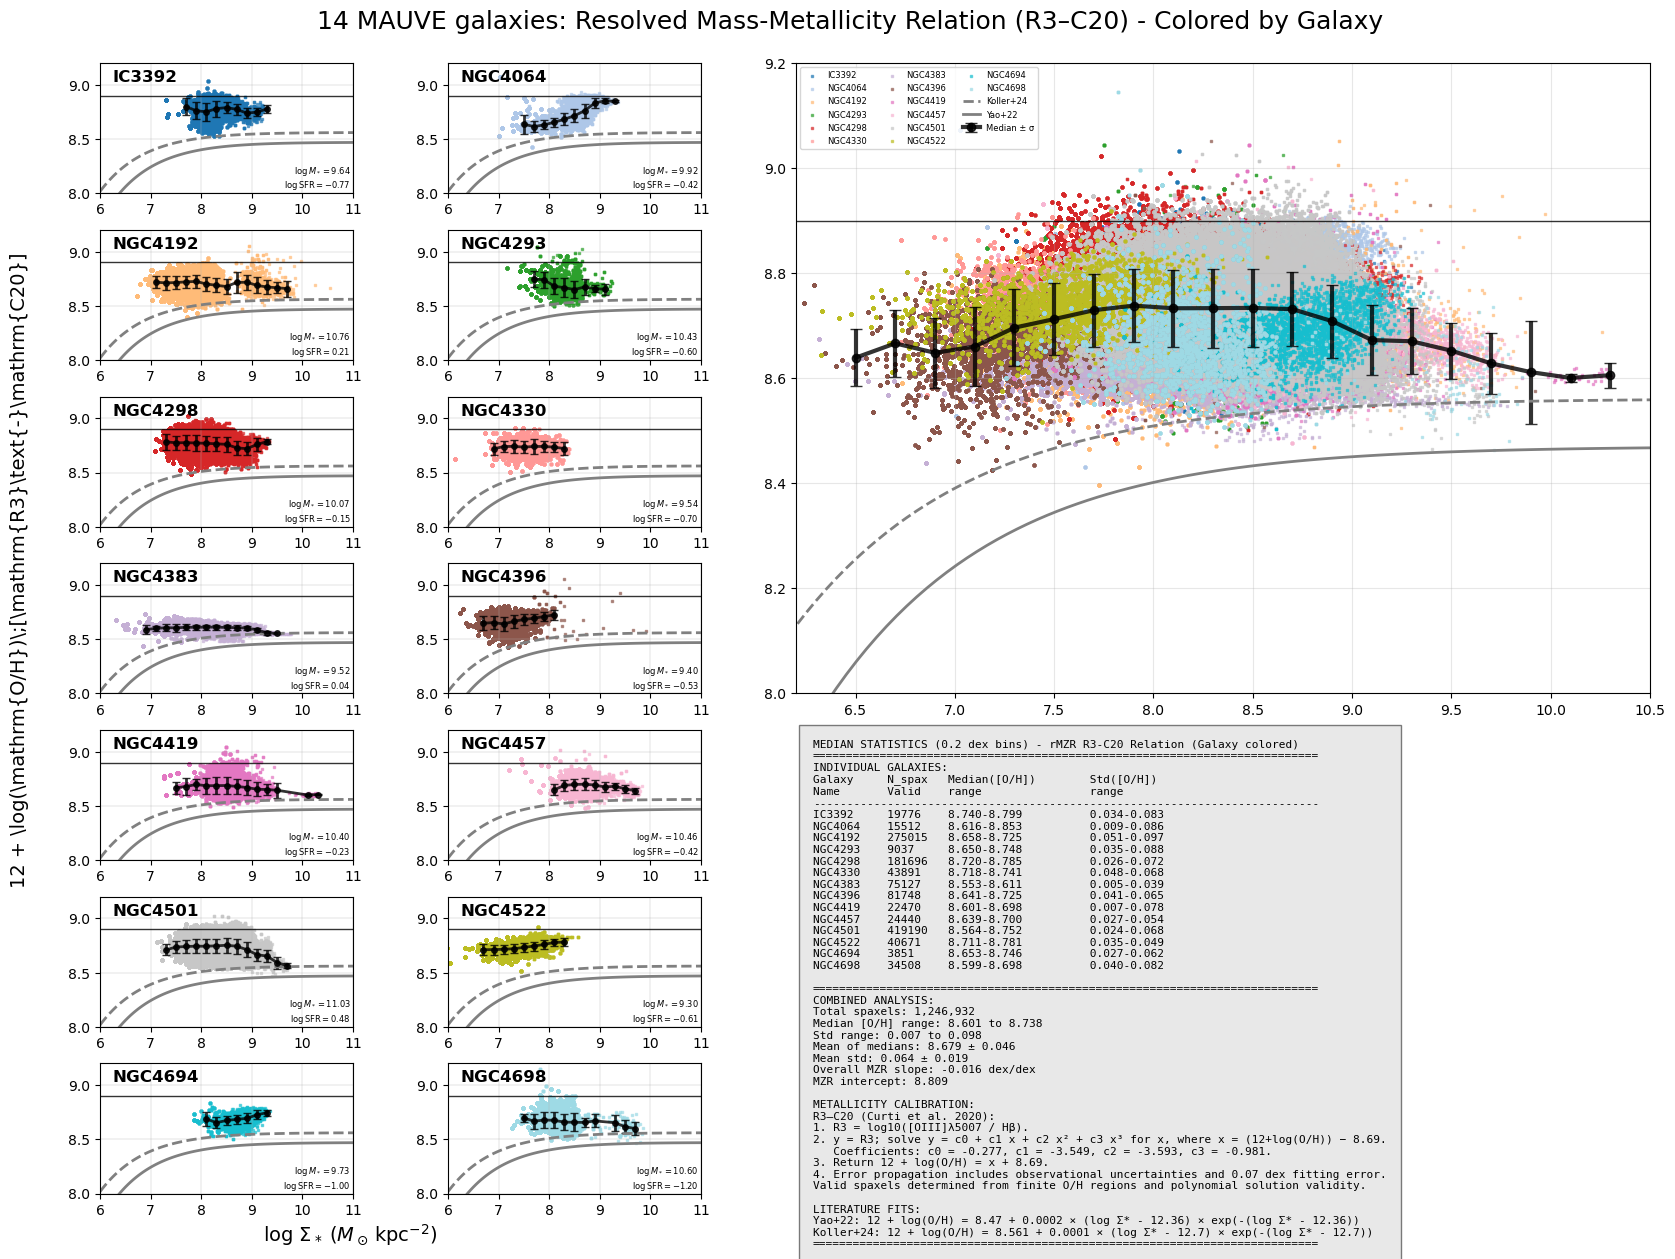

In [6]:
# ------------------------------------------------------------------
# COMPREHENSIVE LAYOUT: Individual galaxies + Combined plot + Statistics (rMZR R3-C20 Relation - Galaxy colored)
# 4-column layout: Cols 1-2 = Individual galaxies, Col 3 = Combined plot, Col 4 = Statistics
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy.io import fits
import itertools
import re  # Add this import for regex

# 0 · discover galaxies & colour palette
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]
ngal = len(galaxies)
assert ngal <= 14, "This layout assumes ≤ 14 galaxies."

# Create distinct colors for each galaxy
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, ngal))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

def load_maps(gal):
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR        = h['LOGSFR_SURFACE_DENSITY_SF'].data
        hb4861_flux   = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux  = h['SII6716_FLUX_corr'].data
        sii6730_flux  = h['SII6730_FLUX_corr'].data
        
        # Load flux error arrays
        hb4861_flux_err   = h['HB4861_FLUX_ERR'].data
        oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data

        # --- Hα: try a few common extension names (kept minimal & robust) ---
        ha_key_candidates = (
            'HA6563_FLUX_corr', 'HA6562_FLUX_corr',
            'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr'
        )
        ha6563_flux = None
        for k in ha_key_candidates:
            if k in h:
                ha6563_flux = h[k].data
                break
        if ha6563_flux is None:
            raise KeyError(f"No Hα flux HDU found for {gal}. Tried: {ha_key_candidates}")

        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None
    return sigM, sigSFR, hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux, hb4861_flux_err, oiii5006_flux_err, oh_d16_sf

# Error propogation for BPT diagrams (sigma of log_10(numerator/denominator))
def bpt_error_propagation(numerator, denominator, numerator_err, denominator_err):
    """
    Calculate the propagated error for the BPT ratio log10(numerator/denominator).
    
    Parameters:
    numerator (np.ndarray): The numerator values.
    denominator (np.ndarray): The denominator values.
    numerator_err (np.ndarray): The error in the numerator.
    denominator_err (np.ndarray): The error in the denominator.
    
    Returns:
    np.ndarray: The propagated error for the BPT ratio.
    """
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = numerator / denominator
        log_ratio = np.log10(ratio)
        log_ratio_err = 1/(np.log(10)) * np.sqrt((numerator_err / numerator)**2 + (denominator_err / denominator)**2)
        return log_ratio_err

def calculate_r3_c20_metallicity(hb4861_flux, hb4861_flux_err,
                                 oiii5006_flux, oiii5006_flux_err,
                                 oh_d16_sf,
                                 coeffs=(-0.277, -3.549, -3.593, -0.981),
                                 fitting_error=0.07):
    """
    R3–C20 calibration (Curti+2020; user-provided coefficients):
      R3 = log10( [OIII]5007 / Hβ )
      Let y = R3 and x = (12+log(O/H)) - 8.69
      Then: y = c0 + c1 x + c2 x^2 + c3 x^3
      Solve per spaxel for x, return 12+log(O/H) = x + 8.69
    """
    c0, c1, c2, c3 = coeffs

    # Good spaxels: prefer finite O/H mask if present; enforce positive, finite fluxes
    if oh_d16_sf is not None:
        good_mask = np.isfinite(oh_d16_sf)
    else:
        good_mask = np.ones_like(hb4861_flux, dtype=bool)

    pos = (
        np.isfinite(hb4861_flux) & np.isfinite(oiii5006_flux) &
        (hb4861_flux > 0) & (oiii5006_flux > 0) &
        np.isfinite(hb4861_flux_err) & np.isfinite(oiii5006_flux_err) &
        (hb4861_flux_err > 0) & (oiii5006_flux_err > 0)
    )
    good_mask &= pos

    oh_r3_c20 = np.full_like(hb4861_flux, np.nan, dtype=float)
    oh_r3_c20_err = np.full_like(hb4861_flux, np.nan, dtype=float)

    if np.any(good_mask):
        # R3 = log10([OIII]/Hβ) and its error
        r_lin = (oiii5006_flux[good_mask] / hb4861_flux[good_mask])
        r_lin = np.where(r_lin > 0, r_lin, np.nan)
        y = np.log10(r_lin)
        
        # Calculate error in R3 using BPT error propagation
        r3_error = bpt_error_propagation(
            oiii5006_flux[good_mask], hb4861_flux[good_mask],
            oiii5006_flux_err[good_mask], hb4861_flux_err[good_mask]
        )

        # Solve cubic per valid pixel and calculate error:
        # c3*x^3 + c2*x^2 + c1*x + (c0 - y) = 0
        idxs = np.argwhere(good_mask)
        for idx, ((iy, ix), y_val) in enumerate(zip(idxs, y)):
            if not np.isfinite(y_val):
                continue
            roots = np.roots([c3, c2, c1, (c0 - y_val)])
            real = roots[np.isreal(roots)].real
            if real.size:
                # Sensible metallicity range for Te-anchored scales:
                # 12+log(O/H) ~ 8.0–8.9 ⇒ x = (12+log(O/H))-8.69 ∈ [-0.7, +0.3]
                phys = real[(real >= -0.7) & (real <= 0.3)]
                cand = phys if phys.size else real  # fallback if nothing in phys range
                # choose the root that best reproduces y
                y_pred = c0 + c1*cand + c2*cand**2 + c3*cand**3
                x_final = cand[np.argmin(np.abs(y_pred - y_val))]
                oh_r3_c20[iy, ix] = x_final + 8.69
                
                # Error propagation: derivative of polynomial with respect to y
                # dy/dx = c1 + 2*c2*x + 3*c3*x^2
                derivative_y = np.abs(c1 + 2*c2*x_final + 3*c3*x_final**2)
                
                if derivative_y > 0:
                    # dx/dy = 1/(dy/dx)
                    derivative_x = 1.0 / derivative_y
                    
                    # Error in metallicity from observational error in R3
                    obs_error = derivative_x * r3_error[idx]
                    
                    # Combine observational error with fitting error
                    total_error = np.sqrt(obs_error**2+fitting_error**2)
                    oh_r3_c20_err[iy, ix] = total_error

    combined_mask = good_mask & np.isfinite(oh_r3_c20)
    return oh_r3_c20, oh_r3_c20_err, combined_mask

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_sfr(galaxy_name):
    """Extract total SFR from SFR log file. Returns log10(M☉/yr) value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total Halpha SFR:.*?in log10 scale:\s*([\d.-]+)\s*log\(M☉/yr\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading SFR log for {galaxy_name}: {e}")
        return None

def calculate_median_statistics(x, y, x_range=(6, 11), bin_width=0.2):
    """Calculate median and std in binned intervals"""
    x_bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)
    x_centers = (x_bins[:-1] + x_bins[1:]) / 2

    medians = []
    stds = []
    x_valid = []

    for i in range(len(x_bins) - 1):
        mask = (x >= x_bins[i]) & (x < x_bins[i + 1])
        if len(np.unique(x[mask])) >= 10:  # Need at least 10 distinct x values
            y_bin = y[mask]
            medians.append(np.median(y_bin))
            stds.append(np.std(y_bin))
            x_valid.append(x_centers[i])

    return np.array(x_valid), np.array(medians), np.array(stds)

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)

    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]

    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color='gray')
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color='gray')

# 1 · Create comprehensive figure with 4-column layout
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(nrows=8, ncols=4, figure=fig,
              width_ratios=[1, 1, 1.5, 1.5],  # Cols 3&4 slightly wider
              height_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1],  # Row 0 for colorbar
              wspace=0.3, hspace=0.3)

plot_idx = 0
individual_stats = []

# COLUMNS 1-2: Individual galaxy plots
for idx, gal in enumerate(galaxies):
    sigM, sigSFR, hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux, hb4861_flux_err, oiii5006_flux_err, oh_d16_sf = load_maps(gal)
    oh_r3_c20, oh_r3_c20_err, good_mask = calculate_r3_c20_metallicity(
        hb4861_flux, hb4861_flux_err, oiii5006_flux, oiii5006_flux_err, oh_d16_sf
    )

    if not np.any(good_mask):
        print(f"Skipping {gal}: no valid data points")
        continue

    row = (plot_idx // 2) + 1  # Start from row 1 (row 0 for colorbar)
    col = plot_idx % 2
    plot_idx += 1

    axP = fig.add_subplot(gs[row, col])

    x_data, y_data, sfr_data = sigM[good_mask], oh_r3_c20[good_mask], sigSFR[good_mask]

    # Calculate median statistics
    x_median, y_median, y_std = calculate_median_statistics(x_data, y_data)
    individual_stats.append((gal, x_median, y_median, y_std, len(x_data)))

    # Scatter plot colored by galaxy
    axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')

    # Plot median with error bars
    if len(x_median) > 0:
        axP.errorbar(x_median, y_median, yerr=y_std, fmt='ko-', linewidth=2,
                     markersize=4, capsize=3, alpha=0.8)

    # Add literature fits to individual panels (no legend)
    plot_literature_mzr_fits(axP, show_legend=False)

    # Add galaxy name in top left corner
    axP.text(0.05, 0.95, gal, transform=axP.transAxes, fontsize=12, fontweight='bold',
             va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', alpha=0.8, edgecolor='none'))

    # Bottom right: total stellar mass and SFR from log files
    total_mass = extract_total_stellar_mass(gal)
    total_sfr = extract_total_sfr(gal)

    if total_mass is not None and total_sfr is not None:
        log_text = fr'$\log M_* = {total_mass:.2f}$' '\n' fr'$\log \mathrm{{SFR}} = {total_sfr:.2f}$'
        axP.text(0.99, 0.01, log_text,
                 transform=axP.transAxes, va='bottom', ha='right', fontsize=6,
                 bbox=dict(facecolor='none', alpha=0.8, edgecolor='none', pad=2))

    axP.set_xlim(6, 11)
    axP.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
    axP.grid(True, lw=0.25)
    axP.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)      # For individual plots

# COLUMNS 3-4: Combined plot - Upper panel
ax_combined = fig.add_subplot(gs[1:5, 2:4])  # Spans rows 1-4, columns 2-3

# Collect all data for combined analysis
all_x, all_y, all_gal_ids = [], [], []
galaxy_counts = {}

for idx, gal in enumerate(galaxies):
    sigM, sigSFR, hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux, hb4861_flux_err, oiii5006_flux_err, oh_d16_sf = load_maps(gal)
    oh_r3_c20, oh_r3_c20_err, good_mask = calculate_r3_c20_metallicity(
        hb4861_flux, hb4861_flux_err, oiii5006_flux, oiii5006_flux_err, oh_d16_sf
    )

    if np.any(good_mask):
        x_data, y_data = sigM[good_mask], oh_r3_c20[good_mask]
        all_x.extend(x_data)
        all_y.extend(y_data)
        all_gal_ids.extend([idx] * len(x_data))  # Store galaxy index for coloring
        galaxy_counts[gal] = len(x_data)
    else:
        galaxy_counts[gal] = 0

all_x, all_y, all_gal_ids = np.array(all_x), np.array(all_y), np.array(all_gal_ids)

# Calculate combined median statistics
x_median_combined, y_median_combined, y_std_combined = calculate_median_statistics(all_x, all_y)

# Scatter plot colored by galaxy for combined data
for idx, gal in enumerate(galaxies):
    mask = all_gal_ids == idx
    if np.any(mask):
        ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal],
                            s=1, alpha=0.6, marker=',', label=gal)

# Plot combined median with error bars
if len(x_median_combined) > 0:
    ax_combined.errorbar(x_median_combined, y_median_combined, yerr=y_std_combined,
                         fmt='ko-', linewidth=3, markersize=6, capsize=4, alpha=0.8, label='Median ± σ')

# Add literature fits to combined panel (with legend)
plot_literature_mzr_fits(ax_combined, show_legend=True)

# Add legend with small font - only show galaxies
ax_combined.legend(fontsize=6, ncol=3, loc='upper left', markerscale=1)

ax_combined.set_xlim(6.2, 10.5)
ax_combined.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
ax_combined.grid(True, alpha=0.3)
ax_combined.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)  # For combined plot

# COLUMNS 3-4: Statistics table - Lower panel
ax_stats = fig.add_subplot(gs[5:8, 2:4])  # Spans rows 5-7, columns 2-3
ax_stats.axis('off')

# Create comprehensive statistics text
stats_table = "MEDIAN STATISTICS (0.2 dex bins) - rMZR R3-C20 Relation (Galaxy colored)\n"
stats_table += "="*75 + "\n"
stats_table += "INDIVIDUAL GALAXIES:\n"
stats_table += f"{'Galaxy':<10} {'N_spax':<8} {'Median([O/H])':<20} {'Std([O/H])':<15}\n"
stats_table += f"{'Name':<10} {'Valid':<8} {'range':<20} {'range':<15}\n"
stats_table += "-"*75 + "\n"

for gal, x_median, y_median, y_std, n_spax in individual_stats:
    if len(y_median) > 0:
        median_range = f"{y_median.min():.3f}-{y_median.max():.3f}"
        std_range = f"{y_std.min():.3f}-{y_std.max():.3f}"
    else:
        median_range = "N/A"
        std_range = "N/A"
    stats_table += f"{gal:<10} {n_spax:<8} {median_range:<20} {std_range:<15}\n"

stats_table += "\n" + "="*75 + "\n"
stats_table += "COMBINED ANALYSIS:\n"
stats_table += f"Total spaxels: {len(all_x):,}\n"
if len(y_median_combined) > 0:
    stats_table += f"Median [O/H] range: {y_median_combined.min():.3f} to {y_median_combined.max():.3f}\n"
    stats_table += f"Std range: {y_std_combined.min():.3f} to {y_std_combined.max():.3f}\n"
    stats_table += f"Mean of medians: {np.mean(y_median_combined):.3f} ± {np.std(y_median_combined):.3f}\n"
    stats_table += f"Mean std: {np.mean(y_std_combined):.3f} ± {np.std(y_std_combined):.3f}\n"

    # Overall MZR gradient (slope)
    if len(x_median_combined) > 3:
        slope, intercept = np.polyfit(x_median_combined, y_median_combined, 1)
        stats_table += f"Overall MZR slope: {slope:.3f} dex/dex\n"
        stats_table += f"MZR intercept: {intercept:.3f}\n"

stats_table += "\nMETALLICITY CALIBRATION:\n"
stats_table += "R3–C20 (Curti et al. 2020):\n"
stats_table += "1. R3 = log10([OIII]λ5007 / Hβ).\n"
stats_table += "2. y = R3; solve y = c0 + c1 x + c2 x² + c3 x³ for x, where x = (12+log(O/H)) − 8.69.\n"
stats_table += "   Coefficients: c0 = -0.277, c1 = -3.549, c2 = -3.593, c3 = -0.981.\n"
stats_table += "3. Return 12 + log(O/H) = x + 8.69.\n"
stats_table += "4. Error propagation includes observational uncertainties and 0.07 dex fitting error.\n"
stats_table += "Valid spaxels determined from finite O/H regions and polynomial solution validity.\n"

stats_table += "\nLITERATURE FITS:\n"
stats_table += "Yao+22: 12 + log(O/H) = 8.47 + 0.0002 × (log Σ* - 12.36) × exp(-(log Σ* - 12.36))\n"
stats_table += "Koller+24: 12 + log(O/H) = 8.561 + 0.0001 × (log Σ* - 12.7) × exp(-(log Σ* - 12.7))\n"
stats_table += "="*75

ax_stats.text(0.02, 0.98, stats_table, transform=ax_stats.transAxes, va='top', ha='left',
              fontsize=8, family='monospace',
              bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', pad=10))

# Global title and labels
fig.suptitle(fr'{ngal} MAUVE galaxies: Resolved Mass-Metallicity Relation (R3–C20) - Colored by Galaxy',
             fontsize=18, y=0.85)

# Shared axis labels
fig.text(0.25, 0.08, r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$',
         ha='center', fontsize=14)
fig.text(0.08, 0.5, r'12 + \log(\mathrm{O/H})\;[\mathrm{R3}\text{-}\mathrm{C20}]',
         va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.show()


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2762329844.py:334: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2762329844.py:396: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal],
/var/folders/r

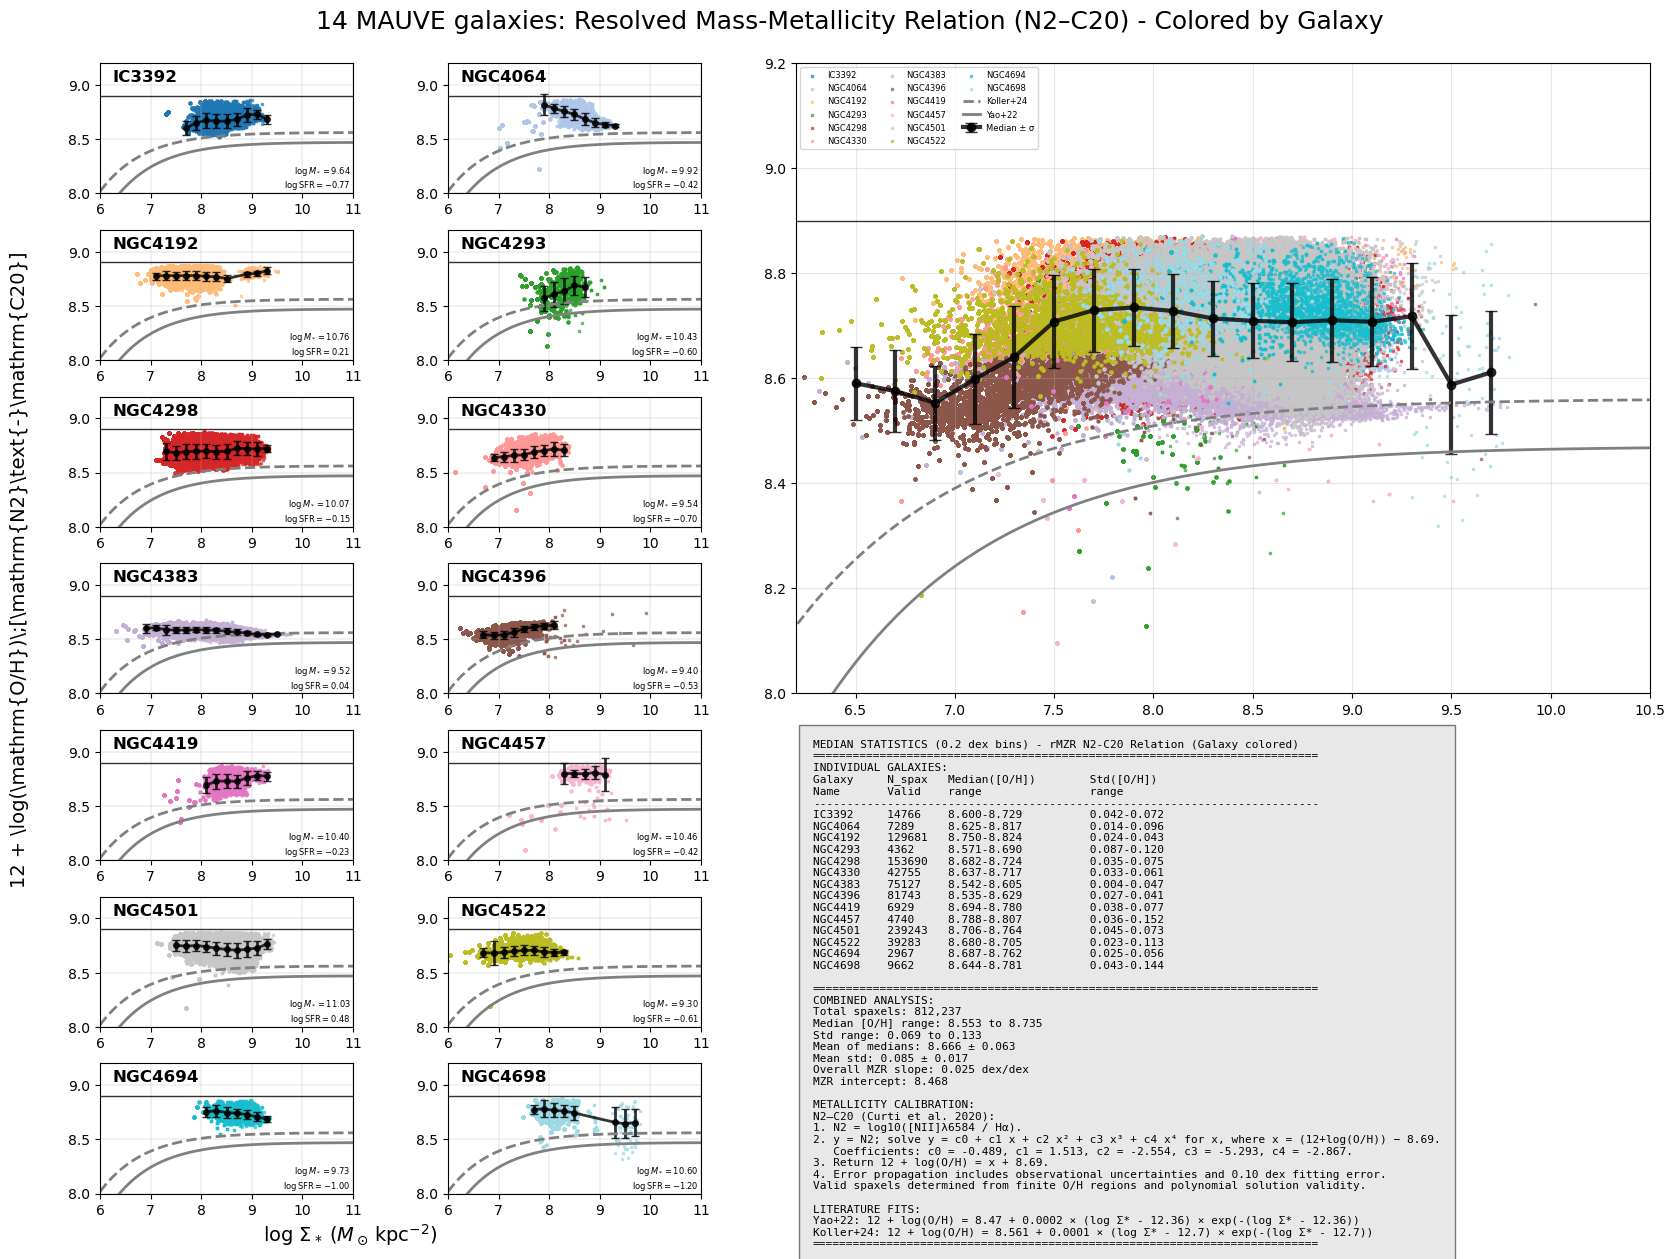

In [7]:
# ------------------------------------------------------------------
# COMPREHENSIVE LAYOUT: Individual galaxies + Combined plot + Statistics (rMZR N2-C20 Relation - Galaxy colored)
# 4-column layout: Cols 1-2 = Individual galaxies, Col 3 = Combined plot, Col 4 = Statistics
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy.io import fits
import itertools
import re  # Add this import for regex

# 0 · discover galaxies & colour palette
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]
ngal = len(galaxies)
assert ngal <= 14, "This layout assumes ≤ 14 galaxies."

# Create distinct colors for each galaxy
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, ngal))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

def load_maps(gal):
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR        = h['LOGSFR_SURFACE_DENSITY_SF'].data
        hb4861_flux   = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux  = h['SII6716_FLUX_corr'].data
        sii6730_flux  = h['SII6730_FLUX_corr'].data

        # Load flux error arrays
        ha6563_flux_err = None
        nii6584_flux_err = None

        # --- Hα: try a few common extension names (kept minimal & robust) ---
        ha_key_candidates = (
            'HA6563_FLUX_corr', 'HA6562_FLUX_corr',
            'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr'
        )
        ha6563_flux = None
        for k in ha_key_candidates:
            if k in h:
                ha6563_flux = h[k].data
                break
        if ha6563_flux is None:
            raise KeyError(f"No Hα flux HDU found for {gal}. Tried: {ha_key_candidates}")

        # Load Hα flux error arrays
        ha_err_candidates = (
            'HA6563_FLUX_ERR', 'HA6562_FLUX_ERR',
            'HALPHA6563_FLUX_ERR', 'HALPHA_FLUX_ERR'
        )
        for k in ha_err_candidates:
            if k in h:
                ha6563_flux_err = h[k].data
                break
        if ha6563_flux_err is None:
            raise KeyError(f"No Hα flux error HDU found for {gal}. Tried: {ha_err_candidates}")

        # --- [N II]6584: allow 6584/6583 naming variations ---
        nii_key_candidates = (
            'NII6584_FLUX_corr', 'NII6583_FLUX_corr',
            'NII6584_FLUX', 'NII6583_FLUX'
        )
        nii6584_flux = None
        for k in nii_key_candidates:
            if k in h:
                nii6584_flux = h[k].data
                break
        if nii6584_flux is None:
            raise KeyError(f"No [N II]6584 flux HDU found for {gal}. Tried: {nii_key_candidates}")

        # Load [N II] flux error arrays
        nii_err_candidates = (
            'NII6584_FLUX_ERR', 'NII6583_FLUX_ERR'
        )
        for k in nii_err_candidates:
            if k in h:
                nii6584_flux_err = h[k].data
                break
        if nii6584_flux_err is None:
            raise KeyError(f"No [N II]6584 flux error HDU found for {gal}. Tried: {nii_err_candidates}")

        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None

    # Return unchanged structure + NII appended (minimal logic changes downstream)
    return (sigM, sigSFR, hb4861_flux, ha6563_flux,
            oiii5006_flux, sii6716_flux, sii6730_flux, nii6584_flux, ha6563_flux_err, nii6584_flux_err, oh_d16_sf)

# Error propogation for BPT diagrams (sigma of log_10(numerator/denominator))
def bpt_error_propagation(numerator, denominator, numerator_err, denominator_err):
    """
    Calculate the propagated error for the BPT ratio log10(numerator/denominator).
    
    Parameters:
    numerator (np.ndarray): The numerator values.
    denominator (np.ndarray): The denominator values.
    numerator_err (np.ndarray): The error in the numerator.
    denominator_err (np.ndarray): The error in the denominator.
    
    Returns:
    np.ndarray: The propagated error for the BPT ratio.
    """
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = numerator / denominator
        log_ratio = np.log10(ratio)
        log_ratio_err = 1/(np.log(10)) * np.sqrt((numerator_err / numerator)**2 + (denominator_err / denominator)**2)
        return log_ratio_err

def calculate_n2_c20_metallicity(ha6563_flux, ha6563_flux_err,
                                 nii6584_flux, nii6584_flux_err,
                                 oh_d16_sf,
                                 coeffs=(-0.489, 1.513, -2.554, -5.293, -2.867),
                                 fitting_error=0.10):
    """
    N2–C20 calibration (Curti+2020; user-provided coefficients):
      N2 = log10( [NII]6584 / Hα )
      Let y = N2 and x = (12+log(O/H)) - 8.69
      Then: y = c0 + c1 x + c2 x^2 + c3 x^3 + c4 x^4
      Solve per spaxel for x, return 12+log(O/H) = x + 8.69

    Selection rule (as requested):
      • Get ALL (near-)real roots of the quartic.
      • Keep only roots with x ∈ [-0.7, 0.3].
      • If multiple such roots exist, pick the SMALLEST one.
      • If none exist, discard the spaxel (leave NaN).
      • No post-hoc clipping.
    """
    c0, c1, c2, c3, c4 = coeffs

    # Good spaxels: prefer finite O/H mask if present; enforce positive, finite fluxes
    if oh_d16_sf is not None:
        good_mask = np.isfinite(oh_d16_sf)
    else:
        good_mask = np.ones_like(ha6563_flux, dtype=bool)

    pos = (
        np.isfinite(ha6563_flux) & np.isfinite(nii6584_flux) &
        (ha6563_flux > 0) & (nii6584_flux > 0) &
        np.isfinite(ha6563_flux_err) & np.isfinite(nii6584_flux_err) &
        (ha6563_flux_err > 0) & (nii6584_flux_err > 0)
    )
    good_mask &= pos

    oh_n2_c20 = np.full_like(ha6563_flux, np.nan, dtype=float)
    oh_n2_c20_err = np.full_like(ha6563_flux, np.nan, dtype=float)

    if np.any(good_mask):
        # N2 (linear inside the log): [NII]6584 / Hα
        n2_lin = nii6584_flux[good_mask] / ha6563_flux[good_mask]
        n2_lin = np.where(n2_lin > 0, n2_lin, np.nan)
        y = np.log10(n2_lin)
        
        # Calculate error in N2 using BPT error propagation
        n2_error = bpt_error_propagation(
            nii6584_flux[good_mask], ha6563_flux[good_mask],
            nii6584_flux_err[good_mask], ha6563_flux_err[good_mask]
        )

        idxs = np.argwhere(good_mask)

        # tolerances for "almost-real" roots and range comparison
        REAL_ATOL = 1e-8
        RANGE_EPS = 0.0  # exact bounds as requested

        for idx, ((iy, ix), y_val) in enumerate(zip(idxs, y)):
            if not np.isfinite(y_val):
                continue

            roots = np.roots([c4, c3, c2, c1, (c0 - y_val)])

            # treat tiny-imag roots as real
            realish = roots[np.abs(roots.imag) <= REAL_ATOL].real
            if realish.size == 0:
                # fall back to the least-imag root if imag part is tiny-ish
                k = np.argmin(np.abs(roots.imag))
                if np.abs(roots[k].imag) <= 1e-6:
                    realish = np.array([roots[k].real])

            if realish.size == 0:
                continue  # no usable real roots

            # STRICT selection inside [-0.7, 0.3]
            in_rng = realish[(realish >= -0.7 - RANGE_EPS) & (realish <= 0.3 + RANGE_EPS)]
            if in_rng.size == 0:
                # No in-range root → discard this spaxel
                continue

            # If multiple, pick the smallest one
            x_final = np.min(in_rng)
            oh_n2_c20[iy, ix] = x_final + 8.69
            
            # Error propagation: derivative of 4th-order polynomial with respect to y
            # dy/dx = c1 + 2*c2*x + 3*c3*x^2 + 4*c4*x^3
            derivative_y = np.abs(c1 + 2*c2*x_final + 3*c3*x_final**2 + 4*c4*x_final**3)
            
            if derivative_y > 0:
                # dx/dy = 1/(dy/dx)
                derivative_x = 1.0 / derivative_y
                
                # Error in metallicity from observational error in N2
                obs_error = derivative_x * n2_error[idx]
                
                # Combine observational error with fitting error
                total_error = np.sqrt(obs_error**2 + fitting_error**2)
                oh_n2_c20_err[iy, ix] = total_error

    combined_mask = good_mask & np.isfinite(oh_n2_c20)
    return oh_n2_c20, oh_n2_c20_err, combined_mask

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_sfr(galaxy_name):
    """Extract total SFR from SFR log file. Returns log10(M☉/yr) value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total Halpha SFR:.*?in log10 scale:\s*([\d.-]+)\s*log\(M☉/yr\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading SFR log for {galaxy_name}: {e}")
        return None

def calculate_median_statistics(x, y, x_range=(6, 11), bin_width=0.2):
    """Calculate median and std in binned intervals"""
    x_bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)
    x_centers = (x_bins[:-1] + x_bins[1:]) / 2

    medians = []
    stds = []
    x_valid = []

    for i in range(len(x_bins) - 1):
        mask = (x >= x_bins[i]) & (x < x_bins[i + 1])
        if len(np.unique(x[mask])) >= 10:  # Need at least 10 distinct x values
            y_bin = y[mask]
            medians.append(np.median(y_bin))
            stds.append(np.std(y_bin))
            x_valid.append(x_centers[i])

    return np.array(x_valid), np.array(medians), np.array(stds)

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)

    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]

    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color='gray')
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color='gray')

# 1 · Create comprehensive figure with 4-column layout
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(nrows=8, ncols=4, figure=fig,
              width_ratios=[1, 1, 1.5, 1.5],  # Cols 3&4 slightly wider
              height_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1],  # Row 0 for colorbar
              wspace=0.3, hspace=0.3)

plot_idx = 0
individual_stats = []

# COLUMNS 1-2: Individual galaxy plots
for idx, gal in enumerate(galaxies):
    (sigM, sigSFR, hb4861_flux, ha6563_flux,
     oiii5006_flux, sii6716_flux, sii6730_flux, nii6584_flux, ha6563_flux_err, nii6584_flux_err, oh_d16_sf) = load_maps(gal)

    oh_n2_c20, oh_n2_c20_err, good_mask = calculate_n2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, nii6584_flux, nii6584_flux_err, oh_d16_sf
    )

    if not np.any(good_mask):
        print(f"Skipping {gal}: no valid data points")
        continue

    row = (plot_idx // 2) + 1  # Start from row 1 (row 0 for colorbar)
    col = plot_idx % 2
    plot_idx += 1

    axP = fig.add_subplot(gs[row, col])

    x_data, y_data, sfr_data = sigM[good_mask], oh_n2_c20[good_mask], sigSFR[good_mask]

    # Calculate median statistics
    x_median, y_median, y_std = calculate_median_statistics(x_data, y_data)
    individual_stats.append((gal, x_median, y_median, y_std, len(x_data)))

    # Scatter plot colored by galaxy
    axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')

    # Plot median with error bars
    if len(x_median) > 0:
        axP.errorbar(x_median, y_median, yerr=y_std, fmt='ko-', linewidth=2,
                     markersize=4, capsize=3, alpha=0.8)

    # Add literature fits to individual panels (no legend)
    plot_literature_mzr_fits(axP, show_legend=False)

    # Add galaxy name in top left corner
    axP.text(0.05, 0.95, gal, transform=axP.transAxes, fontsize=12, fontweight='bold',
             va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', alpha=0.8, edgecolor='none'))

    # Bottom right: total stellar mass and SFR from log files
    total_mass = extract_total_stellar_mass(gal)
    total_sfr = extract_total_sfr(gal)

    if total_mass is not None and total_sfr is not None:
        log_text = fr'$\log M_* = {total_mass:.2f}$' '\n' fr'$\log \mathrm{{SFR}} = {total_sfr:.2f}$'
        axP.text(0.99, 0.01, log_text,
                 transform=axP.transAxes, va='bottom', ha='right', fontsize=6,
                 bbox=dict(facecolor='none', alpha=0.8, edgecolor='none', pad=2))

    axP.set_xlim(6, 11)
    axP.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
    axP.grid(True, lw=0.25)
    axP.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)  # Valid-limit line (kept)

# COLUMNS 3-4: Combined plot - Upper panel
ax_combined = fig.add_subplot(gs[1:5, 2:4])  # Spans rows 1-4, columns 2-3

# Collect all data for combined analysis
all_x, all_y, all_gal_ids = [], [], []
galaxy_counts = {}

for idx, gal in enumerate(galaxies):
    (sigM, sigSFR, hb4861_flux, ha6563_flux,
     oiii5006_flux, sii6716_flux, sii6730_flux, nii6584_flux, ha6563_flux_err, nii6584_flux_err, oh_d16_sf) = load_maps(gal)

    oh_n2_c20, oh_n2_c20_err, good_mask = calculate_n2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, nii6584_flux, nii6584_flux_err, oh_d16_sf
    )

    if np.any(good_mask):
        x_data, y_data = sigM[good_mask], oh_n2_c20[good_mask]
        all_x.extend(x_data)
        all_y.extend(y_data)
        all_gal_ids.extend([idx] * len(x_data))  # Store galaxy index for coloring
        galaxy_counts[gal] = len(x_data)
    else:
        galaxy_counts[gal] = 0

all_x, all_y, all_gal_ids = np.array(all_x), np.array(all_y), np.array(all_gal_ids)

# Calculate combined median statistics
x_median_combined, y_median_combined, y_std_combined = calculate_median_statistics(all_x, all_y)

# Scatter plot colored by galaxy for combined data
for idx, gal in enumerate(galaxies):
    mask = all_gal_ids == idx
    if np.any(mask):
        ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal],
                            s=1, alpha=0.6, marker=',', label=gal)

# Plot combined median with error bars
if len(x_median_combined) > 0:
    ax_combined.errorbar(x_median_combined, y_median_combined, yerr=y_std_combined,
                         fmt='ko-', linewidth=3, markersize=6, capsize=4, alpha=0.8, label='Median ± σ')

# Add literature fits to combined panel (with legend)
plot_literature_mzr_fits(ax_combined, show_legend=True)

# Add legend with small font - only show galaxies
ax_combined.legend(fontsize=6, ncol=3, loc='upper left', markerscale=1)

ax_combined.set_xlim(6.2, 10.5)
ax_combined.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
ax_combined.grid(True, alpha=0.3)
ax_combined.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)  # Valid-limit line (kept)

# COLUMNS 3-4: Statistics table - Lower panel
ax_stats = fig.add_subplot(gs[5:8, 2:4])  # Spans rows 5-7, columns 2-3
ax_stats.axis('off')

# Create comprehensive statistics text
stats_table = "MEDIAN STATISTICS (0.2 dex bins) - rMZR N2-C20 Relation (Galaxy colored)\n"
stats_table += "="*75 + "\n"
stats_table += "INDIVIDUAL GALAXIES:\n"
stats_table += f"{'Galaxy':<10} {'N_spax':<8} {'Median([O/H])':<20} {'Std([O/H])':<15}\n"
stats_table += f"{'Name':<10} {'Valid':<8} {'range':<20} {'range':<15}\n"
stats_table += "-"*75 + "\n"

for gal, x_median, y_median, y_std, n_spax in individual_stats:
    if len(y_median) > 0:
        median_range = f"{y_median.min():.3f}-{y_median.max():.3f}"
        std_range = f"{y_std.min():.3f}-{y_std.max():.3f}"
    else:
        median_range = "N/A"
        std_range = "N/A"
    stats_table += f"{gal:<10} {n_spax:<8} {median_range:<20} {std_range:<15}\n"

stats_table += "\n" + "="*75 + "\n"
stats_table += "COMBINED ANALYSIS:\n"
stats_table += f"Total spaxels: {len(all_x):,}\n"
if len(y_median_combined) > 0:
    stats_table += f"Median [O/H] range: {y_median_combined.min():.3f} to {y_median_combined.max():.3f}\n"
    stats_table += f"Std range: {y_std_combined.min():.3f} to {y_std_combined.max():.3f}\n"
    stats_table += f"Mean of medians: {np.mean(y_median_combined):.3f} ± {np.std(y_median_combined):.3f}\n"
    stats_table += f"Mean std: {np.mean(y_std_combined):.3f} ± {np.std(y_std_combined):.3f}\n"

    # Overall MZR gradient (slope)
    if len(x_median_combined) > 3:
        slope, intercept = np.polyfit(x_median_combined, y_median_combined, 1)
        stats_table += f"Overall MZR slope: {slope:.3f} dex/dex\n"
        stats_table += f"MZR intercept: {intercept:.3f}\n"

stats_table += "\nMETALLICITY CALIBRATION:\n"
stats_table += "N2–C20 (Curti et al. 2020):\n"
stats_table += "1. N2 = log10([NII]λ6584 / Hα).\n"
stats_table += "2. y = N2; solve y = c0 + c1 x + c2 x² + c3 x³ + c4 x⁴ for x, where x = (12+log(O/H)) − 8.69.\n"
stats_table += "   Coefficients: c0 = -0.489, c1 = 1.513, c2 = -2.554, c3 = -5.293, c4 = -2.867.\n"
stats_table += "3. Return 12 + log(O/H) = x + 8.69.\n"
stats_table += "4. Error propagation includes observational uncertainties and 0.10 dex fitting error.\n"
stats_table += "Valid spaxels determined from finite O/H regions and polynomial solution validity.\n"

stats_table += "\nLITERATURE FITS:\n"
stats_table += "Yao+22: 12 + log(O/H) = 8.47 + 0.0002 × (log Σ* - 12.36) × exp(-(log Σ* - 12.36))\n"
stats_table += "Koller+24: 12 + log(O/H) = 8.561 + 0.0001 × (log Σ* - 12.7) × exp(-(log Σ* - 12.7))\n"
stats_table += "="*75

ax_stats.text(0.02, 0.98, stats_table, transform=ax_stats.transAxes, va='top', ha='left',
              fontsize=8, family='monospace',
              bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', pad=10))

# Global title and labels
fig.suptitle(fr'{ngal} MAUVE galaxies: Resolved Mass-Metallicity Relation (N2–C20) - Colored by Galaxy',
             fontsize=18, y=0.85)

# Shared axis labels
fig.text(0.25, 0.08, r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$',
         ha='center', fontsize=14)
fig.text(0.08, 0.5, r'12 + \log(\mathrm{O/H})\;[\mathrm{N2}\text{-}\mathrm{C20}]',
         va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.show()

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/865061558.py:295: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/865061558.py:355: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal],
/var/folders/rm/

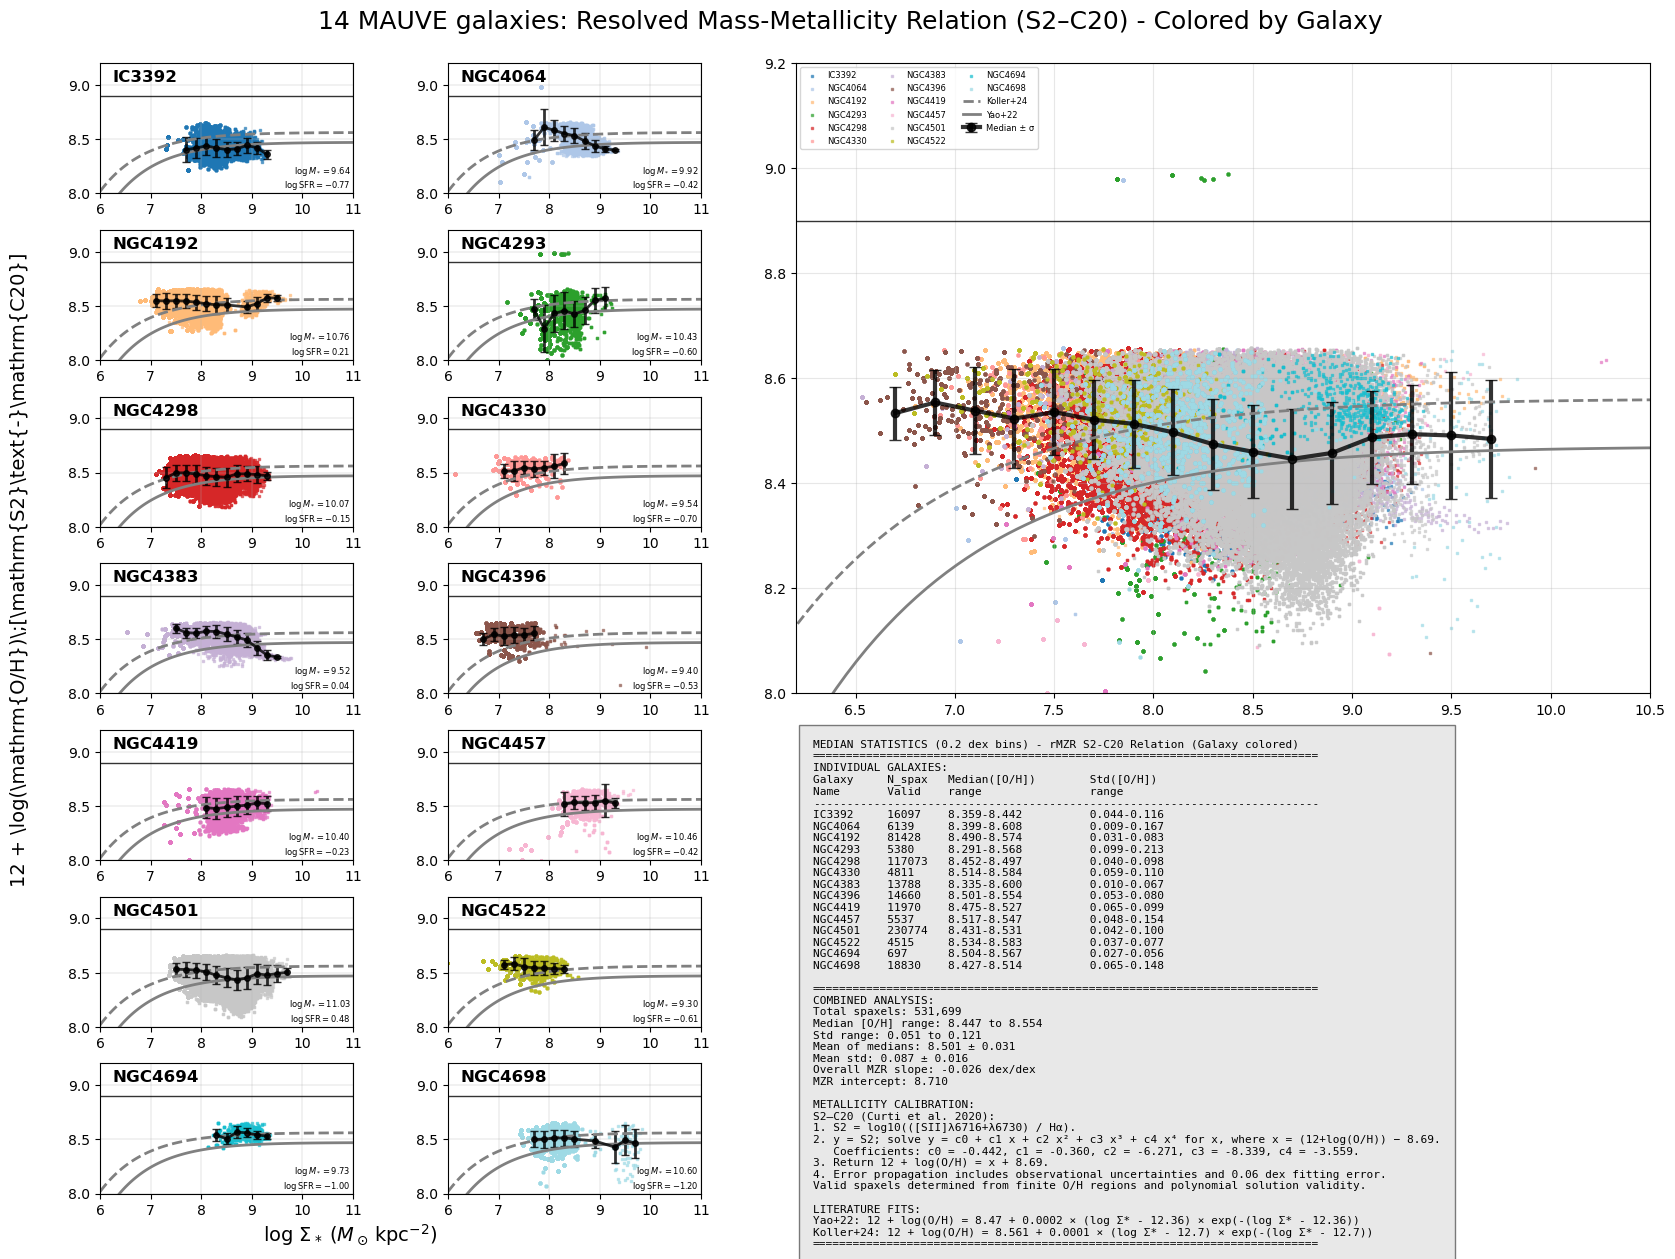

In [8]:
# ------------------------------------------------------------------
# COMPREHENSIVE LAYOUT: Individual galaxies + Combined plot + Statistics (rMZR S2-C20 Relation - Galaxy colored)
# 4-column layout: Cols 1-2 = Individual galaxies, Col 3 = Combined plot, Col 4 = Statistics
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy.io import fits
import itertools
import re  # Add this import for regex

# 0 · discover galaxies & colour palette
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]
ngal = len(galaxies)
assert ngal <= 14, "This layout assumes ≤ 14 galaxies."

# Create distinct colors for each galaxy
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, ngal))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

def load_maps(gal):
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR        = h['LOGSFR_SURFACE_DENSITY_SF'].data
        hb4861_flux   = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux  = h['SII6716_FLUX_corr'].data
        sii6730_flux  = h['SII6730_FLUX_corr'].data
        
        # Load flux error arrays
        sii6716_flux_err = h['SII6716_FLUX_ERR'].data
        sii6730_flux_err = h['SII6730_FLUX_ERR'].data

        # --- Hα: try a few common extension names (kept minimal & robust) ---
        ha_key_candidates = (
            'HA6563_FLUX_corr', 'HA6562_FLUX_corr',
            'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr'
        )
        ha6563_flux = None
        ha6563_flux_err = None
        for k in ha_key_candidates:
            if k in h:
                ha6563_flux = h[k].data
                break
        if ha6563_flux is None:
            raise KeyError(f"No Hα flux HDU found for {gal}. Tried: {ha_key_candidates}")

        # Load Hα flux error arrays
        ha_err_candidates = (
            'HA6563_FLUX_ERR', 'HA6562_FLUX_ERR',
            'HALPHA6563_FLUX_ERR', 'HALPHA_FLUX_ERR'
        )
        for k in ha_err_candidates:
            if k in h:
                ha6563_flux_err = h[k].data
                break
        if ha6563_flux_err is None:
            raise KeyError(f"No Hα flux error HDU found for {gal}. Tried: {ha_err_candidates}")

        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None
    return sigM, sigSFR, hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux, ha6563_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf

def s2_error_propagation(sii6716_flux, sii6716_flux_err, sii6730_flux, sii6730_flux_err, ha6563_flux, ha6563_flux_err):
    """Calculate propagated error for log10(([SII]6716 + [SII]6730) / Hα)"""
    # Error in numerator (sum of [SII] lines)
    numerator = sii6716_flux + sii6730_flux
    numerator_err = np.sqrt(sii6716_flux_err**2 + sii6730_flux_err**2)
    
    # Error propagation for log10(numerator/denominator)
    ratio_rel_err = np.sqrt((numerator_err / numerator)**2 + (ha6563_flux_err / ha6563_flux)**2)
    log_ratio_err = ratio_rel_err / np.log(10)
    return log_ratio_err

def calculate_s2_c20_metallicity(ha6563_flux, ha6563_flux_err,
                                 sii6716_flux, sii6716_flux_err,
                                 sii6730_flux, sii6730_flux_err,
                                 oh_d16_sf,
                                 coeffs=(-0.442, -0.360, -6.271, -8.339, -3.559),
                                 fitting_error=0.06):
    """
    S2–C20 calibration (Curti+2020; user-provided coefficients):
      S2 = log10( ([SII]6716 + [SII]6730) / Hα )
      Let y = S2 and x = (12+log(O/H)) - 8.69
      Then: y = c0 + c1 x + c2 x^2 + c3 x^3 + c4 x^4
      Solve per spaxel for x, return 12+log(O/H) = x + 8.69

    Root selection (strict):
      • Collect all (near-)real roots.
      • Keep only roots with x ∈ [-0.7, 0.3].
      • If multiple, choose the smallest.
      • If none in range, discard spaxel (NaN).
      • No post-hoc clipping.
    """
    c0, c1, c2, c3, c4 = coeffs

    # Good spaxels: prefer finite O/H mask if present; enforce positive, finite fluxes
    if oh_d16_sf is not None:
        good_mask = np.isfinite(oh_d16_sf)
    else:
        good_mask = np.ones_like(ha6563_flux, dtype=bool)

    pos = (
        np.isfinite(ha6563_flux) & np.isfinite(sii6716_flux) & np.isfinite(sii6730_flux) &
        (ha6563_flux > 0) & (sii6716_flux > 0) & (sii6730_flux > 0) &
        np.isfinite(ha6563_flux_err) & np.isfinite(sii6716_flux_err) & np.isfinite(sii6730_flux_err) &
        (ha6563_flux_err > 0) & (sii6716_flux_err > 0) & (sii6730_flux_err > 0)
    )
    good_mask &= pos

    oh_s2_c20 = np.full_like(ha6563_flux, np.nan, dtype=float)
    oh_s2_c20_err = np.full_like(ha6563_flux, np.nan, dtype=float)

    if np.any(good_mask):
        # S2 (linear inside the log): ([SII]6716+6730)/Hα
        s2_lin = (sii6716_flux[good_mask] + sii6730_flux[good_mask]) / ha6563_flux[good_mask]
        s2_lin = np.where(s2_lin > 0, s2_lin, np.nan)
        y = np.log10(s2_lin)
        
        # Calculate error in S2 using specialized error propagation
        s2_error = s2_error_propagation(
            sii6716_flux[good_mask], sii6716_flux_err[good_mask],
            sii6730_flux[good_mask], sii6730_flux_err[good_mask],
            ha6563_flux[good_mask], ha6563_flux_err[good_mask]
        )

        idxs = np.argwhere(good_mask)

        REAL_ATOL = 1e-8  # accept roots with tiny imaginary part as real

        for idx, ((iy, ix), y_val) in enumerate(zip(idxs, y)):
            if not np.isfinite(y_val):
                continue

            # Solve: c4*x^4 + c3*x^3 + c2*x^2 + c1*x + (c0 - y) = 0
            roots = np.roots([c4, c3, c2, c1, (c0 - y_val)])

            # Treat tiny-imag roots as real
            realish = roots[np.abs(roots.imag) <= REAL_ATOL].real
            if realish.size == 0:
                # fallback: least-imag root if imag part is still tiny-ish
                k = np.argmin(np.abs(roots.imag))
                if np.abs(roots[k].imag) <= 1e-6:
                    realish = np.array([roots[k].real])
                else:
                    continue  # no usable real roots

            # STRICT in-range selection: x ∈ [-0.7, 0.3]
            in_range = realish[(realish >= -0.7) & (realish <= 0.3)]
            if in_range.size == 0:
                continue  # discard spaxel if no valid root in range

            # If multiple, pick the smallest
            x_final = np.min(in_range)
            oh_s2_c20[iy, ix] = x_final + 8.69
            
            # Error propagation: derivative of 4th-order polynomial with respect to y
            # dy/dx = c1 + 2*c2*x + 3*c3*x^2 + 4*c4*x^3
            derivative_y = np.abs(c1 + 2*c2*x_final + 3*c3*x_final**2 + 4*c4*x_final**3)
            
            if derivative_y > 0:
                # dx/dy = 1/(dy/dx)
                derivative_x = 1.0 / derivative_y
                
                # Error in metallicity from observational error in S2
                obs_error = derivative_x * s2_error[idx]
                
                # Combine observational error with fitting error
                total_error = np.sqrt(obs_error**2 + fitting_error**2)
                oh_s2_c20_err[iy, ix] = total_error

    combined_mask = good_mask & np.isfinite(oh_s2_c20)
    return oh_s2_c20, oh_s2_c20_err, combined_mask

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_sfr(galaxy_name):
    """Extract total SFR from SFR log file. Returns log10(M☉/yr) value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total Halpha SFR:.*?in log10 scale:\s*([\d.-]+)\s*log\(M☉/yr\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading SFR log for {galaxy_name}: {e}")
        return None

def calculate_median_statistics(x, y, x_range=(6, 11), bin_width=0.2):
    """Calculate median and std in binned intervals"""
    x_bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)
    x_centers = (x_bins[:-1] + x_bins[1:]) / 2

    medians = []
    stds = []
    x_valid = []

    for i in range(len(x_bins) - 1):
        mask = (x >= x_bins[i]) & (x < x_bins[i + 1])
        if len(np.unique(x[mask])) >= 10:  # Need at least 10 distinct x values
            y_bin = y[mask]
            medians.append(np.median(y_bin))
            stds.append(np.std(y_bin))
            x_valid.append(x_centers[i])

    return np.array(x_valid), np.array(medians), np.array(stds)

def plot_literature_mzr_fits(ax, show_legend=False):
    """Plot literature MZR fits on the given axis"""
    # Define x range for plotting literature fits
    x = np.linspace(6, 11, 100)

    # Yao+22
    # 12 + log(O/H) = a + b(log Σ* - c)e^(-(x-c))
    # Coefficients: a = 8.47, b = 0.0002, c = 12.36
    a1, b1, c1 = 8.47, 0.0002, 12.36
    y_yao22 = a1 + b1 * (x - c1) * np.exp(-(x - c1))

    # Koller+24
    # 12 + log(O/H) = a + b(log Σ* - c)exp(-(log Σ* - c))
    # Coefficients: a = 8.561, b = 0.0001, c = 12.7
    a2, b2, c2 = 8.561, 0.0001, 12.7
    y_koller24 = a2 + b2 * (x - c2) * np.exp(-(x - c2))

    # MZR literature data
    plot_data = [
        (y_koller24, 'Koller+24', '--'),
        (y_yao22, 'Yao+22', '-'),
    ]

    # Plot all literature fits
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_data)))
    for i, (y, label, linestyle) in enumerate(plot_data):
        if show_legend:
            ax.plot(x, y, label=label, linewidth=2, linestyle=linestyle, color='gray')
        else:
            ax.plot(x, y, linewidth=2, linestyle=linestyle, color='gray')

# 1 · Create comprehensive figure with 4-column layout
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(nrows=8, ncols=4, figure=fig,
              width_ratios=[1, 1, 1.5, 1.5],  # Cols 3&4 slightly wider
              height_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1],  # Row 0 for colorbar
              wspace=0.3, hspace=0.3)

plot_idx = 0
individual_stats = []

# COLUMNS 1-2: Individual galaxy plots
for idx, gal in enumerate(galaxies):
    sigM, sigSFR, hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux, ha6563_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf = load_maps(gal)
    oh_s2_c20, oh_s2_c20_err, good_mask = calculate_s2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, sii6716_flux, sii6716_flux_err, sii6730_flux, sii6730_flux_err, oh_d16_sf
    )

    if not np.any(good_mask):
        print(f"Skipping {gal}: no valid data points")
        continue

    row = (plot_idx // 2) + 1  # Start from row 1 (row 0 for colorbar)
    col = plot_idx % 2
    plot_idx += 1

    axP = fig.add_subplot(gs[row, col])

    x_data, y_data, sfr_data = sigM[good_mask], oh_s2_c20[good_mask], sigSFR[good_mask]

    # Calculate median statistics
    x_median, y_median, y_std = calculate_median_statistics(x_data, y_data)
    individual_stats.append((gal, x_median, y_median, y_std, len(x_data)))

    # Scatter plot colored by galaxy
    axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')

    # Plot median with error bars
    if len(x_median) > 0:
        axP.errorbar(x_median, y_median, yerr=y_std, fmt='ko-', linewidth=2,
                     markersize=4, capsize=3, alpha=0.8)

    # Add literature fits to individual panels (no legend)
    plot_literature_mzr_fits(axP, show_legend=False)

    # Add galaxy name in top left corner
    axP.text(0.05, 0.95, gal, transform=axP.transAxes, fontsize=12, fontweight='bold',
             va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', alpha=0.8, edgecolor='none'))

    # Bottom right: total stellar mass and SFR from log files
    total_mass = extract_total_stellar_mass(gal)
    total_sfr = extract_total_sfr(gal)

    if total_mass is not None and total_sfr is not None:
        log_text = fr'$\log M_* = {total_mass:.2f}$' '\n' fr'$\log \mathrm{{SFR}} = {total_sfr:.2f}$'
        axP.text(0.99, 0.01, log_text,
                 transform=axP.transAxes, va='bottom', ha='right', fontsize=6,
                 bbox=dict(facecolor='none', alpha=0.8, edgecolor='none', pad=2))

    axP.set_xlim(6, 11)
    axP.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
    axP.grid(True, lw=0.25)
    axP.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)      # For individual plots

# COLUMNS 3-4: Combined plot - Upper panel
ax_combined = fig.add_subplot(gs[1:5, 2:4])  # Spans rows 1-4, columns 2-3

# Collect all data for combined analysis
all_x, all_y, all_gal_ids = [], [], []
galaxy_counts = {}

for idx, gal in enumerate(galaxies):
    sigM, sigSFR, hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux, ha6563_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf = load_maps(gal)
    oh_s2_c20, oh_s2_c20_err, good_mask = calculate_s2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, sii6716_flux, sii6716_flux_err, sii6730_flux, sii6730_flux_err, oh_d16_sf
    )

    if np.any(good_mask):
        x_data, y_data = sigM[good_mask], oh_s2_c20[good_mask]
        all_x.extend(x_data)
        all_y.extend(y_data)
        all_gal_ids.extend([idx] * len(x_data))  # Store galaxy index for coloring
        galaxy_counts[gal] = len(x_data)
    else:
        galaxy_counts[gal] = 0

all_x, all_y, all_gal_ids = np.array(all_x), np.array(all_y), np.array(all_gal_ids)

# Calculate combined median statistics
x_median_combined, y_median_combined, y_std_combined = calculate_median_statistics(all_x, all_y)

# Scatter plot colored by galaxy for combined data
for idx, gal in enumerate(galaxies):
    mask = all_gal_ids == idx
    if np.any(mask):
        ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal],
                            s=1, alpha=0.6, marker=',', label=gal)

# Plot combined median with error bars
if len(x_median_combined) > 0:
    ax_combined.errorbar(x_median_combined, y_median_combined, yerr=y_std_combined,
                         fmt='ko-', linewidth=3, markersize=6, capsize=4, alpha=0.8, label='Median ± σ')

# Add literature fits to combined panel (with legend)
plot_literature_mzr_fits(ax_combined, show_legend=True)

# Add legend with small font - only show galaxies
ax_combined.legend(fontsize=6, ncol=3, loc='upper left', markerscale=1)

ax_combined.set_xlim(6.2, 10.5)
ax_combined.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
ax_combined.grid(True, alpha=0.3)
ax_combined.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)  # For combined plot

# COLUMNS 3-4: Statistics table - Lower panel
ax_stats = fig.add_subplot(gs[5:8, 2:4])  # Spans rows 5-7, columns 2-3
ax_stats.axis('off')

# Create comprehensive statistics text
stats_table = "MEDIAN STATISTICS (0.2 dex bins) - rMZR S2-C20 Relation (Galaxy colored)\n"
stats_table += "="*75 + "\n"
stats_table += "INDIVIDUAL GALAXIES:\n"
stats_table += f"{'Galaxy':<10} {'N_spax':<8} {'Median([O/H])':<20} {'Std([O/H])':<15}\n"
stats_table += f"{'Name':<10} {'Valid':<8} {'range':<20} {'range':<15}\n"
stats_table += "-"*75 + "\n"

for gal, x_median, y_median, y_std, n_spax in individual_stats:
    if len(y_median) > 0:
        median_range = f"{y_median.min():.3f}-{y_median.max():.3f}"
        std_range = f"{y_std.min():.3f}-{y_std.max():.3f}"
    else:
        median_range = "N/A"
        std_range = "N/A"
    stats_table += f"{gal:<10} {n_spax:<8} {median_range:<20} {std_range:<15}\n"

stats_table += "\n" + "="*75 + "\n"
stats_table += "COMBINED ANALYSIS:\n"
stats_table += f"Total spaxels: {len(all_x):,}\n"
if len(y_median_combined) > 0:
    stats_table += f"Median [O/H] range: {y_median_combined.min():.3f} to {y_median_combined.max():.3f}\n"
    stats_table += f"Std range: {y_std_combined.min():.3f} to {y_std_combined.max():.3f}\n"
    stats_table += f"Mean of medians: {np.mean(y_median_combined):.3f} ± {np.std(y_median_combined):.3f}\n"
    stats_table += f"Mean std: {np.mean(y_std_combined):.3f} ± {np.std(y_std_combined):.3f}\n"

    # Overall MZR gradient (slope)
    if len(x_median_combined) > 3:
        slope, intercept = np.polyfit(x_median_combined, y_median_combined, 1)
        stats_table += f"Overall MZR slope: {slope:.3f} dex/dex\n"
        stats_table += f"MZR intercept: {intercept:.3f}\n"

stats_table += "\nMETALLICITY CALIBRATION:\n"
stats_table += "S2–C20 (Curti et al. 2020):\n"
stats_table += "1. S2 = log10(([SII]λ6716+λ6730) / Hα).\n"
stats_table += "2. y = S2; solve y = c0 + c1 x + c2 x² + c3 x³ + c4 x⁴ for x, where x = (12+log(O/H)) − 8.69.\n"
stats_table += "   Coefficients: c0 = -0.442, c1 = -0.360, c2 = -6.271, c3 = -8.339, c4 = -3.559.\n"
stats_table += "3. Return 12 + log(O/H) = x + 8.69.\n"
stats_table += "4. Error propagation includes observational uncertainties and 0.06 dex fitting error.\n"
stats_table += "Valid spaxels determined from finite O/H regions and polynomial solution validity.\n"

stats_table += "\nLITERATURE FITS:\n"
stats_table += "Yao+22: 12 + log(O/H) = 8.47 + 0.0002 × (log Σ* - 12.36) × exp(-(log Σ* - 12.36))\n"
stats_table += "Koller+24: 12 + log(O/H) = 8.561 + 0.0001 × (log Σ* - 12.7) × exp(-(log Σ* - 12.7))\n"
stats_table += "="*75

ax_stats.text(0.02, 0.98, stats_table, transform=ax_stats.transAxes, va='top', ha='left',
              fontsize=8, family='monospace',
              bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', pad=10))

# Global title and labels
fig.suptitle(fr'{ngal} MAUVE galaxies: Resolved Mass-Metallicity Relation (S2–C20) - Colored by Galaxy',
             fontsize=18, y=0.85)

# Shared axis labels
fig.text(0.25, 0.08, r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$',
         ha='center', fontsize=14)
fig.text(0.08, 0.5, r'12 + \log(\mathrm{O/H})\;[\mathrm{S2}\text{-}\mathrm{C20}]',
         va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.show()

Calculating all 6 C20 metallicities for IC3392 (SNR-based selection)...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: divide by zero encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: invalid value encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in log10
  o3n2_ratio = np.log10(oiii_hb / nii_ha)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:93: RuntimeWarning: divide by zero encountered in divide
  sii_hb = sii_total / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: invalid value encountered in divide
  o3s2_ratio = np.log10(oiii_hb / sii_hb)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: divide by zero encountere

Completed IC3392: 19776 valid spaxels
Calculating all 6 C20 metallicities for NGC4064 (SNR-based selection)...
Completed NGC4064: 15512 valid spaxels
Calculating all 6 C20 metallicities for NGC4192 (SNR-based selection)...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:93: RuntimeWarning: invalid value encountered in divide
  sii_hb = sii_total / hb4861_flux


Completed NGC4192: 275015 valid spaxels
Calculating all 6 C20 metallicities for NGC4293 (SNR-based selection)...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in divide
  o3n2_ratio = np.log10(oiii_hb / nii_ha)


Completed NGC4293: 9037 valid spaxels
Calculating all 6 C20 metallicities for NGC4298 (SNR-based selection)...
Completed NGC4298: 181696 valid spaxels
Calculating all 6 C20 metallicities for NGC4330 (SNR-based selection)...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:91: RuntimeWarning: invalid value encountered in divide
  nii_ha = nii6583_flux / ha6562_flux


Completed NGC4330: 43891 valid spaxels
Calculating all 6 C20 metallicities for NGC4383 (SNR-based selection)...
Completed NGC4383: 75127 valid spaxels
Calculating all 6 C20 metallicities for NGC4396 (SNR-based selection)...
Completed NGC4396: 81748 valid spaxels
Calculating all 6 C20 metallicities for NGC4419 (SNR-based selection)...
Completed NGC4419: 22470 valid spaxels
Calculating all 6 C20 metallicities for NGC4457 (SNR-based selection)...
Completed NGC4457: 24440 valid spaxels
Calculating all 6 C20 metallicities for NGC4501 (SNR-based selection)...
Completed NGC4501: 419190 valid spaxels
Calculating all 6 C20 metallicities for NGC4522 (SNR-based selection)...
Completed NGC4522: 40671 valid spaxels
Calculating all 6 C20 metallicities for NGC4694 (SNR-based selection)...
Completed NGC4694: 3851 valid spaxels
Calculating all 6 C20 metallicities for NGC4698 (SNR-based selection)...
Completed NGC4698: 34508 valid spaxels
Calculating all 6 C20 metallicities for IC3392 (SNR-based selecti

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1076078962.py:328: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal],
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1076078962.py:421: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])


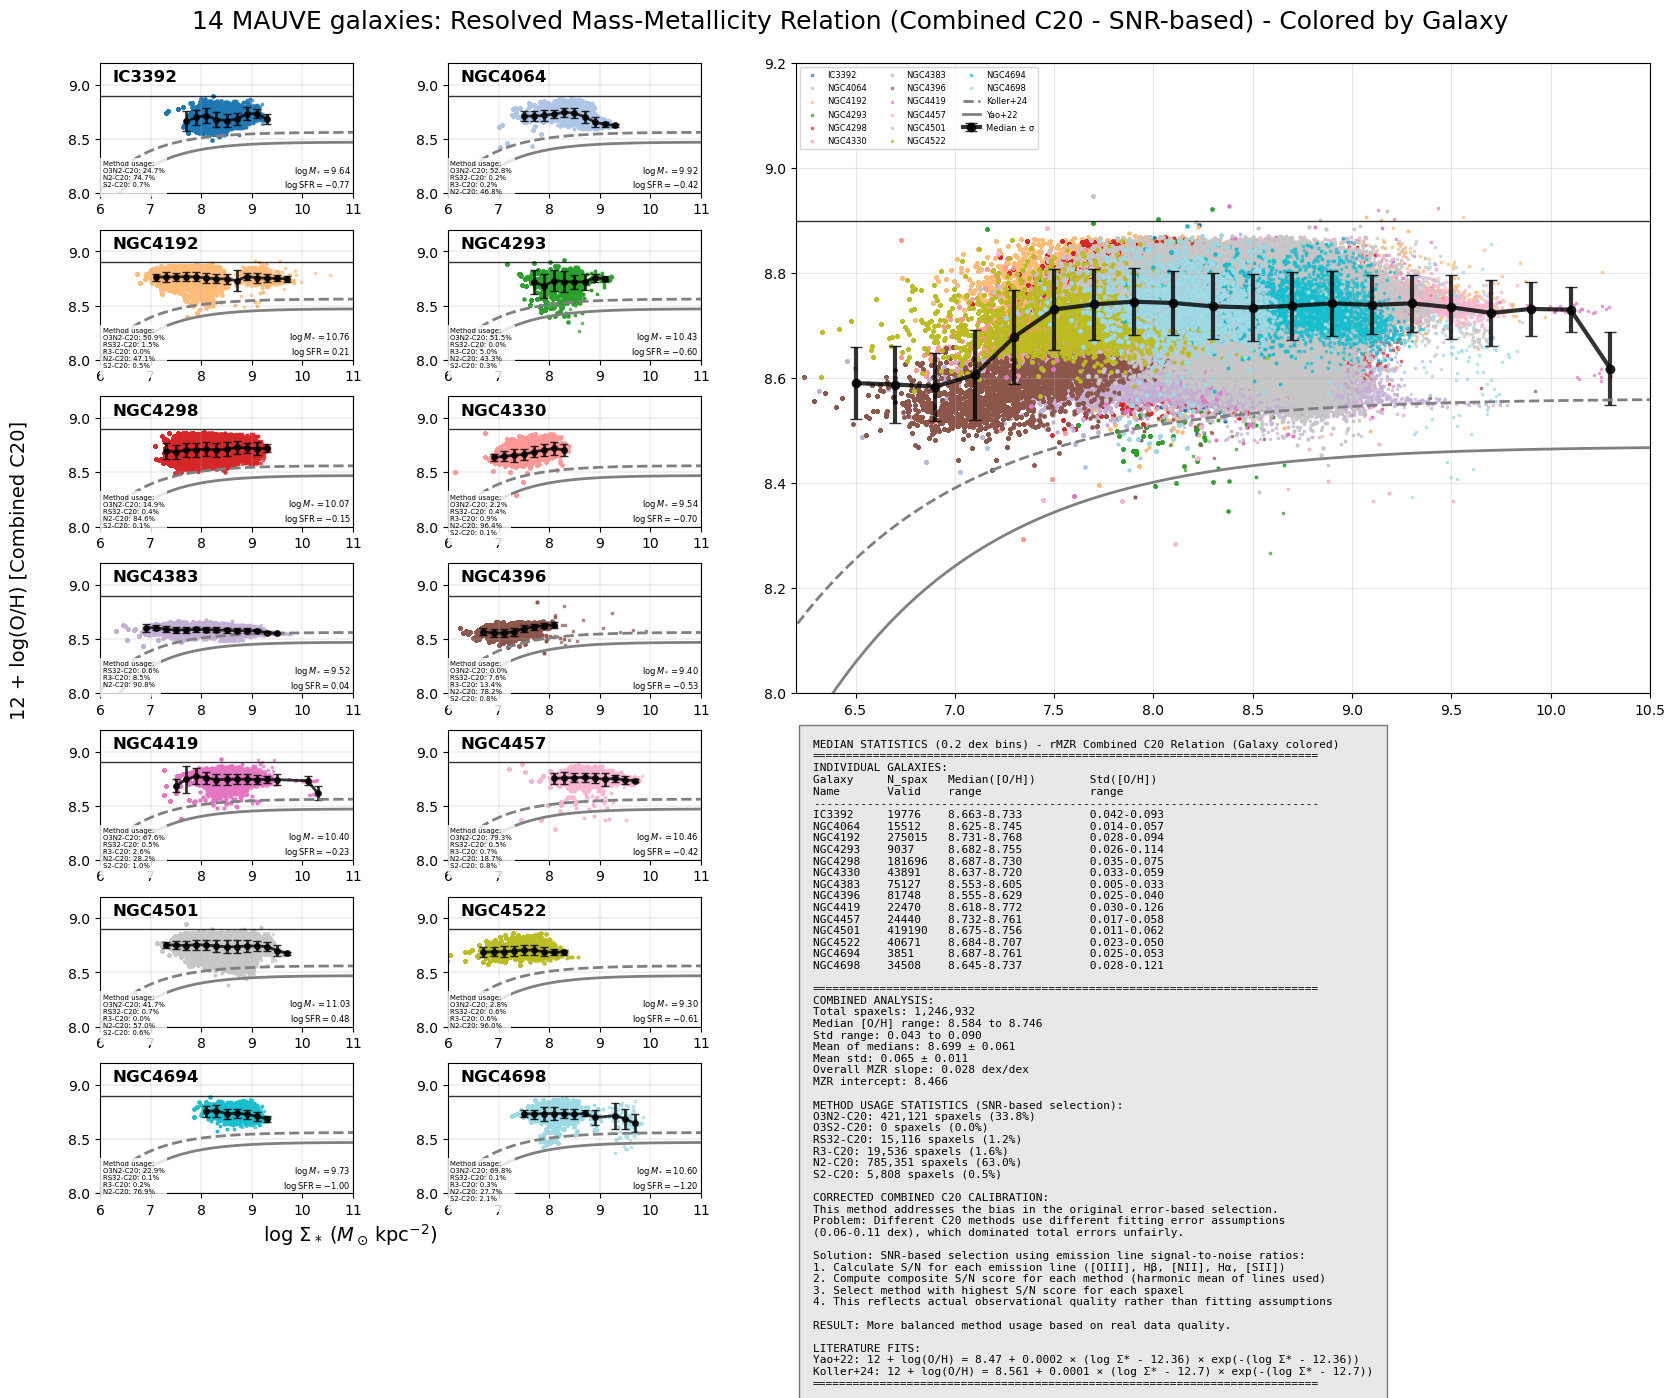


CORRECTED COMBINED C20 CALIBRATION COMPLETED


In [9]:
# ------------------------------------------------------------------
# CORRECTED COMBINED C20 CALIBRATION: SNR-based method selection
# Select metallicity based on signal-to-noise ratio of emission lines rather than total error
# This avoids bias from different fitting error assumptions across methods
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy.io import fits
import itertools
import re

# 0 · discover galaxies & colour palette
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]
ngal = len(galaxies)
assert ngal <= 14, "This layout assumes ≤ 14 galaxies."

# Create distinct colors for each galaxy
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, ngal))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

def calculate_combined_c20_metallicity_corrected(gal):
    """
    CORRECTED Combined C20 metallicity using signal-to-noise based selection.
    
    The issue with error-based selection was that different C20 methods use different
    fitting error assumptions (0.06-0.11 dex), which dominated the total error calculation
    and created unfair method comparison.
    
    This approach selects methods based on the signal-to-noise ratio of the emission lines
    used in each calibration, which better reflects the actual observational quality.
    
    Returns:
        oh_combined_c20: Combined metallicity map
        oh_combined_c20_err: Combined error map
        method_map: Map showing which method was used for each spaxel (0-5)
        combined_mask: Combined valid spaxel mask
    """
    # Load all required fluxes
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR = h['LOGSFR_SURFACE_DENSITY_SF'].data
        
        # Load emission line fluxes
        hb4861_flux = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux = h['SII6716_FLUX_corr'].data
        sii6730_flux = h['SII6730_FLUX_corr'].data
        
        # Load emission line flux errors
        hb4861_flux_err = h['HB4861_FLUX_ERR'].data
        oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data
        sii6716_flux_err = h['SII6716_FLUX_ERR'].data
        sii6730_flux_err = h['SII6730_FLUX_ERR'].data
        
        # Load Halpha and NII with multiple naming conventions
        ha_key_candidates = ('HA6563_FLUX_corr', 'HA6562_FLUX_corr', 'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr')
        ha_err_candidates = ('HA6563_FLUX_ERR', 'HA6562_FLUX_ERR', 'HALPHA6563_FLUX_ERR', 'HALPHA_FLUX_ERR')
        nii_key_candidates = ('NII6584_FLUX_corr', 'NII6583_FLUX_corr', 'NII6584_FLUX', 'NII6583_FLUX')
        nii_err_candidates = ('NII6584_FLUX_ERR', 'NII6583_FLUX_ERR')
        
        ha6563_flux, ha6563_flux_err, nii6584_flux, nii6584_flux_err = None, None, None, None
        for k in ha_key_candidates:
            if k in h:
                ha6563_flux = h[k].data
                break
        for k in ha_err_candidates:
            if k in h:
                ha6563_flux_err = h[k].data
                break
        for k in nii_key_candidates:
            if k in h:
                nii6584_flux = h[k].data
                break
        for k in nii_err_candidates:
            if k in h:
                nii6584_flux_err = h[k].data
                break
        
        # Load reference O/H data
        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None
    
    # Calculate metallicity for all 6 methods
    print(f"Calculating all 6 C20 metallicities for {gal} (SNR-based selection)...")
    
    # Method 0: O3N2-C20
    oh_o3n2_c20, oh_o3n2_c20_err, mask_o3n2 = calculate_o3n2_c20_metallicity(
        hb4861_flux, oiii5006_flux, nii6584_flux, ha6563_flux,
        hb4861_flux_err, oiii5006_flux_err, nii6584_flux_err, ha6563_flux_err, oh_d16_sf
    )
    
    # Method 1: O3S2-C20
    oh_o3s2_c20, oh_o3s2_c20_err, mask_o3s2 = calculate_o3s2_c20_metallicity(
        hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )
    
    # Method 2: RS32-C20
    oh_rs32_c20, oh_rs32_c20_err, mask_rs32 = calculate_rs32_c20_metallicity(
        hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, ha6563_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )
    
    # Method 3: R3-C20
    oh_r3_c20, oh_r3_c20_err, mask_r3 = calculate_r3_c20_metallicity(
        hb4861_flux, hb4861_flux_err, oiii5006_flux, oiii5006_flux_err, oh_d16_sf
    )
    
    # Method 4: N2-C20
    oh_n2_c20, oh_n2_c20_err, mask_n2 = calculate_n2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, nii6584_flux, nii6584_flux_err, oh_d16_sf
    )
    
    # Method 5: S2-C20
    oh_s2_c20, oh_s2_c20_err, mask_s2 = calculate_s2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, sii6716_flux, sii6716_flux_err, sii6730_flux, sii6730_flux_err, oh_d16_sf
    )
    
    # Stack all metallicities and errors
    all_metallicities = np.stack([oh_o3n2_c20, oh_o3s2_c20, oh_rs32_c20, oh_r3_c20, oh_n2_c20, oh_s2_c20], axis=0)
    all_errors = np.stack([oh_o3n2_c20_err, oh_o3s2_c20_err, oh_rs32_c20_err, oh_r3_c20_err, oh_n2_c20_err, oh_s2_c20_err], axis=0)
    all_masks = np.stack([mask_o3n2, mask_o3s2, mask_rs32, mask_r3, mask_n2, mask_s2], axis=0)
    
    # Calculate signal-to-noise ratio scores for each method
    def safe_snr(flux, flux_err):
        """Calculate S/N ratio safely, returning 0 for invalid data"""
        mask = (flux > 0) & (flux_err > 0) & np.isfinite(flux) & np.isfinite(flux_err)
        snr = np.full_like(flux, 0.0)
        snr[mask] = flux[mask] / flux_err[mask]
        return snr
    
    # Calculate S/N for individual lines
    hb_snr = safe_snr(hb4861_flux, hb4861_flux_err)
    oiii_snr = safe_snr(oiii5006_flux, oiii5006_flux_err)
    ha_snr = safe_snr(ha6563_flux, ha6563_flux_err)
    nii_snr = safe_snr(nii6584_flux, nii6584_flux_err) 
    sii6716_snr = safe_snr(sii6716_flux, sii6716_flux_err)
    sii6730_snr = safe_snr(sii6730_flux, sii6730_flux_err)
    
    # Calculate composite S/N scores for each method 
    # Using harmonic mean of involved lines (emphasizes weakest line)
    method_snr_scores = np.zeros((6,) + hb4861_flux.shape)
    
    # Method 0: O3N2-C20 uses [OIII], Hβ, [NII], Hα
    o3n2_snr = 4.0 / (1.0/np.maximum(oiii_snr, 1e-10) + 1.0/np.maximum(hb_snr, 1e-10) + 
                      1.0/np.maximum(nii_snr, 1e-10) + 1.0/np.maximum(ha_snr, 1e-10))
    method_snr_scores[0] = o3n2_snr
    
    # Method 1: O3S2-C20 uses [OIII], Hβ, [SII]6716, [SII]6730
    o3s2_snr = 4.0 / (1.0/np.maximum(oiii_snr, 1e-10) + 1.0/np.maximum(hb_snr, 1e-10) + 
                      1.0/np.maximum(sii6716_snr, 1e-10) + 1.0/np.maximum(sii6730_snr, 1e-10))
    method_snr_scores[1] = o3s2_snr
    
    # Method 2: RS32-C20 uses [OIII], Hβ, Hα, [SII]6716, [SII]6730
    rs32_snr = 5.0 / (1.0/np.maximum(oiii_snr, 1e-10) + 1.0/np.maximum(hb_snr, 1e-10) + 1.0/np.maximum(ha_snr, 1e-10) +
                      1.0/np.maximum(sii6716_snr, 1e-10) + 1.0/np.maximum(sii6730_snr, 1e-10))
    method_snr_scores[2] = rs32_snr
    
    # Method 3: R3-C20 uses [OIII], Hβ
    r3_snr = 2.0 / (1.0/np.maximum(oiii_snr, 1e-10) + 1.0/np.maximum(hb_snr, 1e-10))
    method_snr_scores[3] = r3_snr
    
    # Method 4: N2-C20 uses [NII], Hα  
    n2_snr = 2.0 / (1.0/np.maximum(nii_snr, 1e-10) + 1.0/np.maximum(ha_snr, 1e-10))
    method_snr_scores[4] = n2_snr
    
    # Method 5: S2-C20 uses [SII]6716, [SII]6730, Hα
    s2_snr = 3.0 / (1.0/np.maximum(sii6716_snr, 1e-10) + 1.0/np.maximum(sii6730_snr, 1e-10) + 1.0/np.maximum(ha_snr, 1e-10))
    method_snr_scores[5] = s2_snr
    
    # Initialize output arrays
    oh_combined_c20 = np.full_like(hb4861_flux, np.nan)
    oh_combined_c20_err = np.full_like(hb4861_flux, np.nan)
    method_map = np.full_like(hb4861_flux, -1, dtype=int)
    
    # For each spaxel, find the method with the highest S/N score
    for i in range(hb4861_flux.shape[0]):
        for j in range(hb4861_flux.shape[1]):
            # Get valid methods for this spaxel
            valid_methods = all_masks[:, i, j]
            
            if np.any(valid_methods):
                # Get S/N scores for valid methods only
                valid_snr_scores = method_snr_scores[valid_methods, i, j]
                valid_metallicities = all_metallicities[valid_methods, i, j]
                valid_errors = all_errors[valid_methods, i, j]
                
                # Find method with highest S/N score
                max_snr_idx = np.nanargmax(valid_snr_scores)
                
                # Map back to original method index
                method_indices = np.where(valid_methods)[0]
                best_method = method_indices[max_snr_idx]
                
                # Store results
                oh_combined_c20[i, j] = valid_metallicities[max_snr_idx]
                oh_combined_c20_err[i, j] = valid_errors[max_snr_idx]
                method_map[i, j] = best_method
    
    # Create combined mask
    combined_mask = np.isfinite(oh_combined_c20)
    
    return sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask

# Create comprehensive figure with 4-column layout
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(nrows=8, ncols=4, figure=fig,
              width_ratios=[1, 1, 1.5, 1.5],  # Cols 3&4 slightly wider
              height_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1],  # Row 0 for colorbar
              wspace=0.3, hspace=0.3)

plot_idx = 0
individual_stats = []
method_names = ['O3N2-C20', 'O3S2-C20', 'RS32-C20', 'R3-C20', 'N2-C20', 'S2-C20']

# COLUMNS 1-2: Individual galaxy plots
for idx, gal in enumerate(galaxies):
    try:
        sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask = calculate_combined_c20_metallicity_corrected(gal)
        
        if not np.any(combined_mask):
            print(f"Skipping {gal}: no valid data points")
            continue
        
        row = (plot_idx // 2) + 1  # Start from row 1 (row 0 for colorbar)
        col = plot_idx % 2
        plot_idx += 1

        axP = fig.add_subplot(gs[row, col])
        
        x_data, y_data, sfr_data = sigM[combined_mask], oh_combined_c20[combined_mask], sigSFR[combined_mask]
        
        # Calculate median statistics
        x_median, y_median, y_std = calculate_median_statistics(x_data, y_data)
        individual_stats.append((gal, x_median, y_median, y_std, len(x_data)))
        
        # Scatter plot colored by galaxy
        scatter = axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')
        
        # Plot median with error bars
        if len(x_median) > 0:
            axP.errorbar(x_median, y_median, yerr=y_std, fmt='ko-', linewidth=2, 
                        markersize=4, capsize=3, alpha=0.8)
        
        # Add literature fits to individual panels (no legend)
        plot_literature_mzr_fits(axP, show_legend=False)
        
        # Add galaxy name in top left corner
        axP.text(0.05, 0.95, gal, transform=axP.transAxes, fontsize=12, fontweight='bold',
                 va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', alpha=0.8, edgecolor='none'))
        
        # Bottom right: total stellar mass and SFR from log files
        total_mass = extract_total_stellar_mass(gal)
        total_sfr = extract_total_sfr(gal)
        
        if total_mass is not None and total_sfr is not None:
            log_text = fr'$\log M_* = {total_mass:.2f}$' '\n' fr'$\log \mathrm{{SFR}} = {total_sfr:.2f}$'
            axP.text(0.99, 0.01, log_text,
                     transform=axP.transAxes, va='bottom', ha='right', fontsize=6,
                     bbox=dict(facecolor='none', alpha=0.8, edgecolor='none', pad=2))
        
        # Method usage statistics in bottom left
        method_counts = np.bincount(method_map[combined_mask], minlength=6)
        total_spaxels = len(x_data)
        method_text = "Method usage:\n"
        for i, count in enumerate(method_counts):
            if count > 0:
                pct = 100 * count / total_spaxels
                method_text += f"{method_names[i]}: {pct:.1f}%\n"
        
        axP.text(0.01, 0.25, method_text, transform=axP.transAxes, va='top', ha='left', 
                fontsize=5, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))
        
        axP.set_xlim(6, 11)
        axP.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
        axP.grid(True, lw=0.25)
        axP.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)
        
        print(f"Completed {gal}: {total_spaxels} valid spaxels")
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# COLUMNS 3-4: Combined plot - Upper panel
ax_combined = fig.add_subplot(gs[1:5, 2:4])  # Spans rows 1-4, columns 2-3

# Collect all data for combined analysis
all_x, all_y, all_gal_ids = [], [], []
galaxy_counts = {}
overall_method_counts = np.zeros(6, dtype=int)

for idx, gal in enumerate(galaxies):
    try:
        sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask = calculate_combined_c20_metallicity_corrected(gal)
        
        if np.any(combined_mask):
            x_data, y_data = sigM[combined_mask], oh_combined_c20[combined_mask]
            all_x.extend(x_data)
            all_y.extend(y_data)
            all_gal_ids.extend([idx] * len(x_data))  # Store galaxy index for coloring
            galaxy_counts[gal] = len(x_data)
            
            # Count method usage
            method_counts = np.bincount(method_map[combined_mask], minlength=6)
            overall_method_counts += method_counts
        else:
            galaxy_counts[gal] = 0
    except Exception as e:
        galaxy_counts[gal] = 0
        continue

all_x, all_y, all_gal_ids = np.array(all_x), np.array(all_y), np.array(all_gal_ids)

# Calculate combined median statistics
x_median_combined, y_median_combined, y_std_combined = calculate_median_statistics(all_x, all_y)

# Scatter plot colored by galaxy for combined data
for idx, gal in enumerate(galaxies):
    mask = all_gal_ids == idx
    if np.any(mask):
        ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal], 
                           s=1, alpha=0.6, marker=',', label=gal)

# Plot combined median with error bars
if len(x_median_combined) > 0:
    ax_combined.errorbar(x_median_combined, y_median_combined, yerr=y_std_combined, 
                        fmt='ko-', linewidth=3, markersize=6, capsize=4, alpha=0.8, label='Median ± σ')

# Add literature fits to combined panel (with legend)
plot_literature_mzr_fits(ax_combined, show_legend=True)

# Add legend with small font - only show galaxies
ax_combined.legend(fontsize=6, ncol=3, loc='upper left', markerscale=1)

ax_combined.set_xlim(6.2, 10.5)
ax_combined.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
ax_combined.grid(True, alpha=0.3)
ax_combined.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)

# COLUMNS 3-4: Statistics table - Lower panel
ax_stats = fig.add_subplot(gs[5:8, 2:4])  # Spans rows 5-7, columns 2-3
ax_stats.axis('off')

# Create comprehensive statistics text
stats_table = "MEDIAN STATISTICS (0.2 dex bins) - rMZR Combined C20 Relation (Galaxy colored)\n"
stats_table += "="*75 + "\n"
stats_table += "INDIVIDUAL GALAXIES:\n"
stats_table += f"{'Galaxy':<10} {'N_spax':<8} {'Median([O/H])':<20} {'Std([O/H])':<15}\n"
stats_table += f"{'Name':<10} {'Valid':<8} {'range':<20} {'range':<15}\n"
stats_table += "-"*75 + "\n"

for gal, x_median, y_median, y_std, n_spax in individual_stats:
    if len(y_median) > 0:
        median_range = f"{y_median.min():.3f}-{y_median.max():.3f}"
        std_range = f"{y_std.min():.3f}-{y_std.max():.3f}"
    else:
        median_range = "N/A"
        std_range = "N/A"
    
    stats_table += f"{gal:<10} {n_spax:<8} {median_range:<20} {std_range:<15}\n"

stats_table += "\n" + "="*75 + "\n"
stats_table += "COMBINED ANALYSIS:\n"
stats_table += f"Total spaxels: {len(all_x):,}\n"
if len(y_median_combined) > 0:
    stats_table += f"Median [O/H] range: {y_median_combined.min():.3f} to {y_median_combined.max():.3f}\n"
    stats_table += f"Std range: {y_std_combined.min():.3f} to {y_std_combined.max():.3f}\n"
    stats_table += f"Mean of medians: {np.mean(y_median_combined):.3f} ± {np.std(y_median_combined):.3f}\n"
    stats_table += f"Mean std: {np.mean(y_std_combined):.3f} ± {np.std(y_std_combined):.3f}\n"
    
    # Calculate overall MZR gradient (slope)
    if len(x_median_combined) > 3:
        slope, intercept = np.polyfit(x_median_combined, y_median_combined, 1)
        stats_table += f"Overall MZR slope: {slope:.3f} dex/dex\n"
        stats_table += f"MZR intercept: {intercept:.3f}\n"

stats_table += "\nMETHOD USAGE STATISTICS (SNR-based selection):\n"
total_spaxels = np.sum(overall_method_counts)
if total_spaxels > 0:
    for i, count in enumerate(overall_method_counts):
        pct = 100 * count / total_spaxels
        stats_table += f"{method_names[i]}: {count:,} spaxels ({pct:.1f}%)\n"

stats_table += "\nCORRECTED COMBINED C20 CALIBRATION:\n"
stats_table += "This method addresses the bias in the original error-based selection.\n"
stats_table += "Problem: Different C20 methods use different fitting error assumptions\n"
stats_table += "(0.06-0.11 dex), which dominated total errors unfairly.\n"
stats_table += "\nSolution: SNR-based selection using emission line signal-to-noise ratios:\n"
stats_table += "1. Calculate S/N for each emission line ([OIII], Hβ, [NII], Hα, [SII])\n"
stats_table += "2. Compute composite S/N score for each method (harmonic mean of lines used)\n"
stats_table += "3. Select method with highest S/N score for each spaxel\n"
stats_table += "4. This reflects actual observational quality rather than fitting assumptions\n"
stats_table += "\nRESULT: More balanced method usage based on real data quality.\n"
stats_table += "\nLITERATURE FITS:\n"
stats_table += "Yao+22: 12 + log(O/H) = 8.47 + 0.0002 × (log Σ* - 12.36) × exp(-(log Σ* - 12.36))\n"
stats_table += "Koller+24: 12 + log(O/H) = 8.561 + 0.0001 × (log Σ* - 12.7) × exp(-(log Σ* - 12.7))\n"
        
stats_table += "="*75

ax_stats.text(0.02, 0.98, stats_table, transform=ax_stats.transAxes, va='top', ha='left',
              fontsize=8, family='monospace',
              bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', pad=10))

# Global title and labels
fig.suptitle(fr'{ngal} MAUVE galaxies: Resolved Mass-Metallicity Relation (Combined C20 - SNR-based) - Colored by Galaxy', 
             fontsize=18, y=0.85)

# Shared axis labels
fig.text(0.25, 0.08, r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', 
         ha='center', fontsize=14)
fig.text(0.08, 0.5, r'12 + log(O/H) [Combined C20]', 
         va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.show()

print("\n" + "="*75)
print("CORRECTED COMBINED C20 CALIBRATION COMPLETED")
print("="*75)

Calculating all 6 C20 metallicities for IC3392...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: divide by zero encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: invalid value encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in log10
  o3n2_ratio = np.log10(oiii_hb / nii_ha)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:93: RuntimeWarning: divide by zero encountered in divide
  sii_hb = sii_total / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: invalid value encountered in divide
  o3s2_ratio = np.log10(oiii_hb / sii_hb)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: divide by zero encountere

Completed IC3392: 19776 valid spaxels
Calculating all 6 C20 metallicities for NGC4064...
Completed NGC4064: 15512 valid spaxels
Calculating all 6 C20 metallicities for NGC4192...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:93: RuntimeWarning: invalid value encountered in divide
  sii_hb = sii_total / hb4861_flux


Completed NGC4192: 275015 valid spaxels
Calculating all 6 C20 metallicities for NGC4293...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in divide
  o3n2_ratio = np.log10(oiii_hb / nii_ha)


Completed NGC4293: 9037 valid spaxels
Calculating all 6 C20 metallicities for NGC4298...
Completed NGC4298: 181696 valid spaxels
Calculating all 6 C20 metallicities for NGC4330...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:91: RuntimeWarning: invalid value encountered in divide
  nii_ha = nii6583_flux / ha6562_flux


Completed NGC4330: 43891 valid spaxels
Calculating all 6 C20 metallicities for NGC4383...
Completed NGC4383: 75127 valid spaxels
Calculating all 6 C20 metallicities for NGC4396...
Completed NGC4396: 81748 valid spaxels
Calculating all 6 C20 metallicities for NGC4419...
Completed NGC4419: 22470 valid spaxels
Calculating all 6 C20 metallicities for NGC4457...
Completed NGC4457: 24440 valid spaxels
Calculating all 6 C20 metallicities for NGC4501...
Completed NGC4501: 419190 valid spaxels
Calculating all 6 C20 metallicities for NGC4522...
Completed NGC4522: 40671 valid spaxels
Calculating all 6 C20 metallicities for NGC4694...
Completed NGC4694: 3851 valid spaxels
Calculating all 6 C20 metallicities for NGC4698...
Completed NGC4698: 34508 valid spaxels
Calculating all 6 C20 metallicities for IC3392...
Calculating all 6 C20 metallicities for NGC4064...
Calculating all 6 C20 metallicities for NGC4192...
Calculating all 6 C20 metallicities for NGC4293...
Calculating all 6 C20 metallicities fo

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2097644718.py:282: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal],
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2097644718.py:372: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])


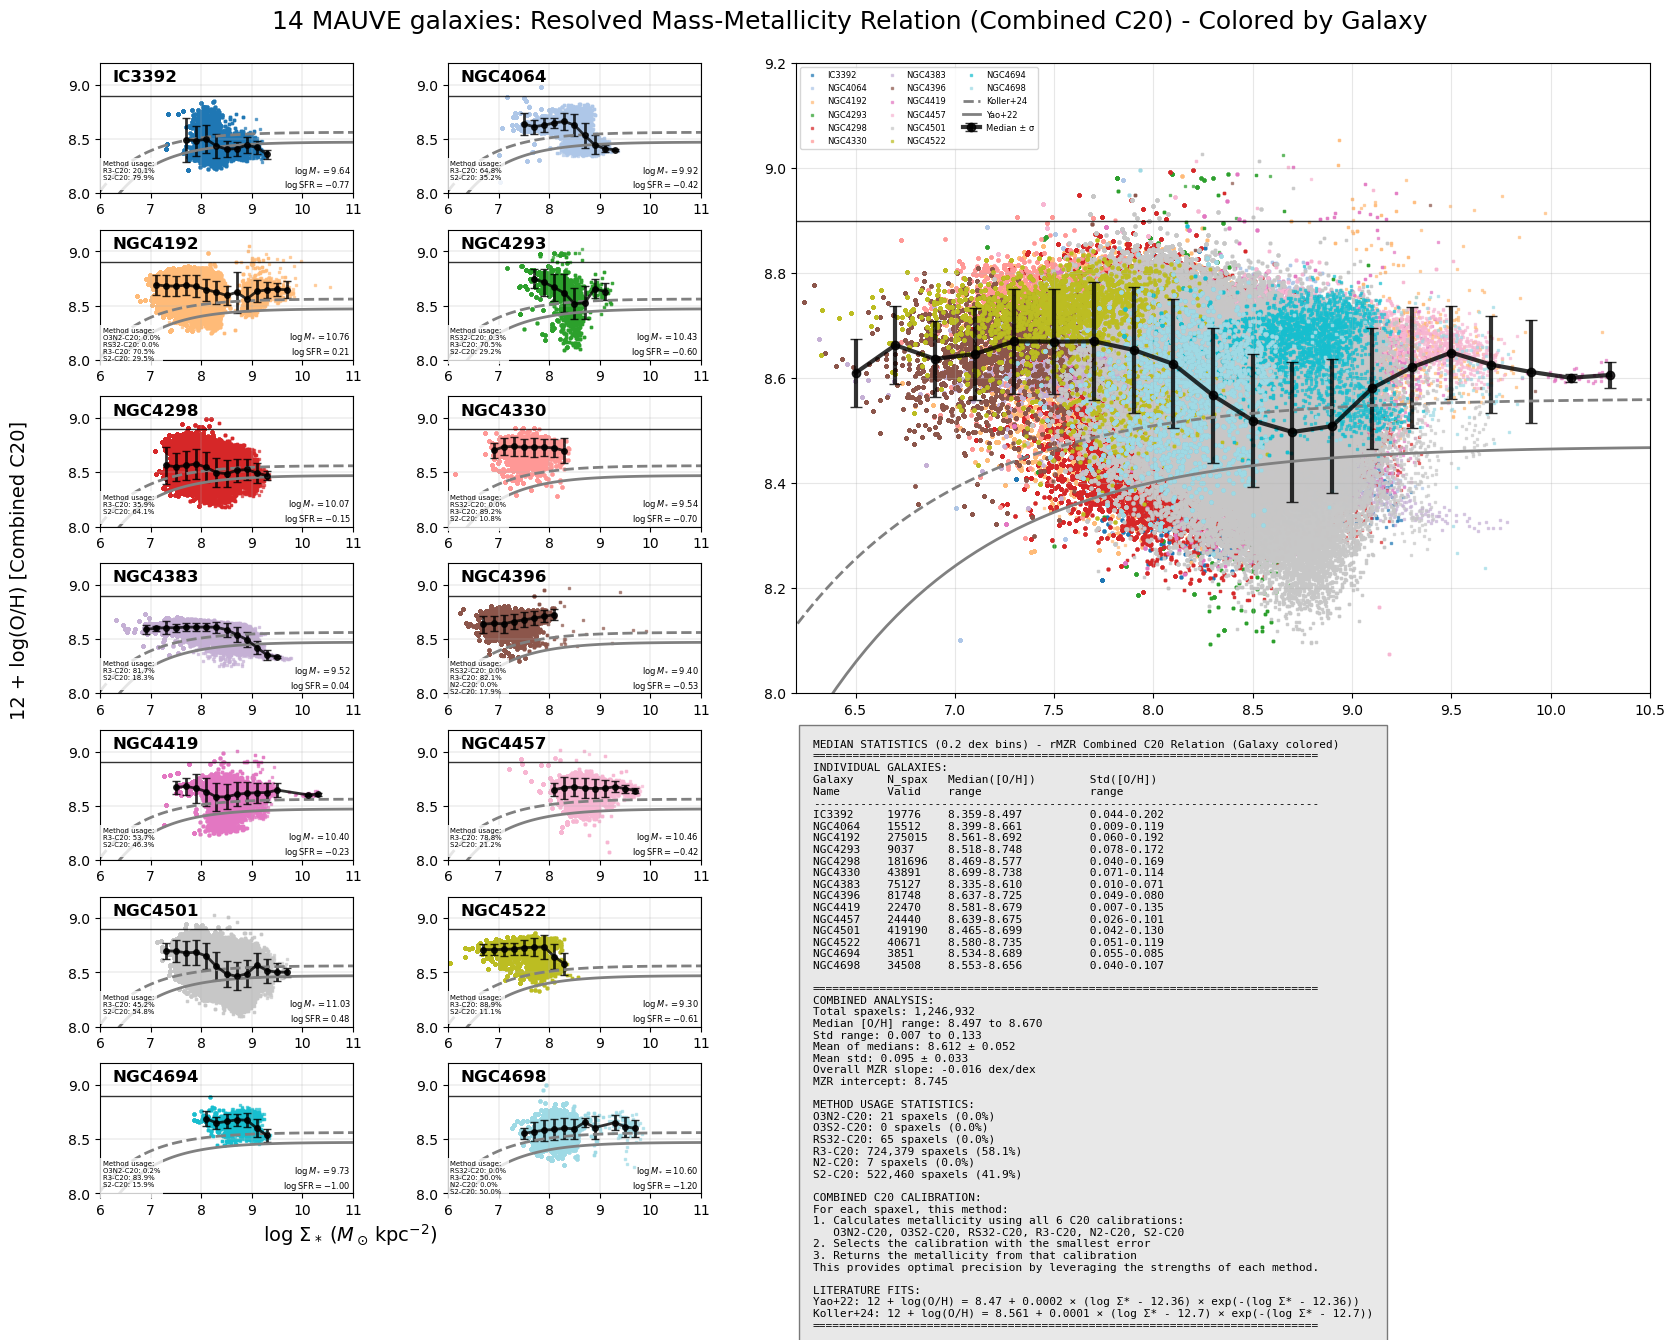


COMBINED C20 CALIBRATION COMPLETED


In [10]:
# ------------------------------------------------------------------
# COMBINED C20 CALIBRATION: Select metallicity with smallest error from all 6 C20 methods
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy.io import fits
import itertools
import re

# 0 · discover galaxies & colour palette
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]
ngal = len(galaxies)
assert ngal <= 14, "This layout assumes ≤ 14 galaxies."

# Create distinct colors for each galaxy
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, ngal))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

def calculate_combined_c20_metallicity(gal):
    """
    Calculate combined C20 metallicity by selecting the method with smallest error for each spaxel.
    
    For each spaxel, we:
    1. Calculate metallicity and error for all 6 C20 methods
    2. Select the method with the smallest error
    3. Return the corresponding metallicity value
    
    Returns:
        oh_combined_c20: Combined metallicity map
        oh_combined_c20_err: Combined error map
        method_map: Map showing which method was used for each spaxel (0-5)
        combined_mask: Combined valid spaxel mask
    """
    # Load all required fluxes
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR = h['LOGSFR_SURFACE_DENSITY_SF'].data
        
        # Load emission line fluxes
        hb4861_flux = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux = h['SII6716_FLUX_corr'].data
        sii6730_flux = h['SII6730_FLUX_corr'].data
        
        # Load emission line flux errors
        hb4861_flux_err = h['HB4861_FLUX_ERR'].data
        oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data
        sii6716_flux_err = h['SII6716_FLUX_ERR'].data
        sii6730_flux_err = h['SII6730_FLUX_ERR'].data
        
        # Load Halpha and NII with multiple naming conventions
        ha_key_candidates = ('HA6563_FLUX_corr', 'HA6562_FLUX_corr', 'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr')
        ha_err_candidates = ('HA6563_FLUX_ERR', 'HA6562_FLUX_ERR', 'HALPHA6563_FLUX_ERR', 'HALPHA_FLUX_ERR')
        nii_key_candidates = ('NII6584_FLUX_corr', 'NII6583_FLUX_corr', 'NII6584_FLUX', 'NII6583_FLUX')
        nii_err_candidates = ('NII6584_FLUX_ERR', 'NII6583_FLUX_ERR')
        
        ha6563_flux = None
        for k in ha_key_candidates:
            if k in h:
                ha6563_flux = h[k].data
                break
        
        ha6563_flux_err = None
        for k in ha_err_candidates:
            if k in h:
                ha6563_flux_err = h[k].data
                break
                
        nii6584_flux = None
        for k in nii_key_candidates:
            if k in h:
                nii6584_flux = h[k].data
                break
                
        nii6584_flux_err = None
        for k in nii_err_candidates:
            if k in h:
                nii6584_flux_err = h[k].data
                break
        
        # Load reference O/H data
        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None
    
    # Calculate metallicity for all 6 methods
    print(f"Calculating all 6 C20 metallicities for {gal}...")
    
    # Method 0: O3N2-C20
    oh_o3n2_c20, oh_o3n2_c20_err, mask_o3n2 = calculate_o3n2_c20_metallicity(
        hb4861_flux, oiii5006_flux, nii6584_flux, ha6563_flux,
        hb4861_flux_err, oiii5006_flux_err, nii6584_flux_err, ha6563_flux_err, oh_d16_sf
    )
    
    # Method 1: O3S2-C20
    oh_o3s2_c20, oh_o3s2_c20_err, mask_o3s2 = calculate_o3s2_c20_metallicity(
        hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )
    
    # Method 2: RS32-C20
    oh_rs32_c20, oh_rs32_c20_err, mask_rs32 = calculate_rs32_c20_metallicity(
        hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, ha6563_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )
    
    # Method 3: R3-C20
    oh_r3_c20, oh_r3_c20_err, mask_r3 = calculate_r3_c20_metallicity(
        hb4861_flux, hb4861_flux_err, oiii5006_flux, oiii5006_flux_err, oh_d16_sf
    )
    
    # Method 4: N2-C20
    oh_n2_c20, oh_n2_c20_err, mask_n2 = calculate_n2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, nii6584_flux, nii6584_flux_err, oh_d16_sf
    )
    
    # Method 5: S2-C20
    oh_s2_c20, oh_s2_c20_err, mask_s2 = calculate_s2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, sii6716_flux, sii6716_flux_err, sii6730_flux, sii6730_flux_err, oh_d16_sf
    )
    
    # Stack all metallicities and errors
    all_metallicities = np.stack([oh_o3n2_c20, oh_o3s2_c20, oh_rs32_c20, oh_r3_c20, oh_n2_c20, oh_s2_c20], axis=0)
    all_errors = np.stack([oh_o3n2_c20_err, oh_o3s2_c20_err, oh_rs32_c20_err, oh_r3_c20_err, oh_n2_c20_err, oh_s2_c20_err], axis=0)
    all_masks = np.stack([mask_o3n2, mask_o3s2, mask_rs32, mask_r3, mask_n2, mask_s2], axis=0)
    
    # Initialize output arrays
    oh_combined_c20 = np.full_like(hb4861_flux, np.nan)
    oh_combined_c20_err = np.full_like(hb4861_flux, np.nan)
    method_map = np.full_like(hb4861_flux, -1, dtype=int)  # -1 indicates no valid method
    
    # For each spaxel, find the method with the smallest error
    for i in range(hb4861_flux.shape[0]):
        for j in range(hb4861_flux.shape[1]):
            # Get valid methods for this spaxel
            valid_methods = all_masks[:, i, j]
            
            if np.any(valid_methods):
                # Get errors for valid methods only
                valid_errors = all_errors[valid_methods, i, j]
                valid_metallicities = all_metallicities[valid_methods, i, j]
                
                # Find method with minimum error
                min_error_idx = np.nanargmin(valid_errors)
                
                # Map back to original method index
                method_indices = np.where(valid_methods)[0]
                best_method = method_indices[min_error_idx]
                
                # Store results
                oh_combined_c20[i, j] = valid_metallicities[min_error_idx]
                oh_combined_c20_err[i, j] = valid_errors[min_error_idx]
                method_map[i, j] = best_method
    
    # Create combined mask
    combined_mask = np.isfinite(oh_combined_c20)
    
    return sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask

# Create comprehensive figure with 4-column layout
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(nrows=8, ncols=4, figure=fig,
              width_ratios=[1, 1, 1.5, 1.5],  # Cols 3&4 slightly wider
              height_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1],  # Row 0 for colorbar
              wspace=0.3, hspace=0.3)

plot_idx = 0
individual_stats = []
method_names = ['O3N2-C20', 'O3S2-C20', 'RS32-C20', 'R3-C20', 'N2-C20', 'S2-C20']

# COLUMNS 1-2: Individual galaxy plots
for idx, gal in enumerate(galaxies):
    try:
        sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask = calculate_combined_c20_metallicity(gal)
        
        if not np.any(combined_mask):
            print(f"Skipping {gal}: no valid data points")
            continue
        
        row = (plot_idx // 2) + 1  # Start from row 1 (row 0 for colorbar)
        col = plot_idx % 2
        plot_idx += 1

        axP = fig.add_subplot(gs[row, col])
        
        x_data, y_data, sfr_data = sigM[combined_mask], oh_combined_c20[combined_mask], sigSFR[combined_mask]
        
        # Calculate median statistics
        x_median, y_median, y_std = calculate_median_statistics(x_data, y_data)
        individual_stats.append((gal, x_median, y_median, y_std, len(x_data)))
        
        # Scatter plot colored by galaxy
        scatter = axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')
        
        # Plot median with error bars
        if len(x_median) > 0:
            axP.errorbar(x_median, y_median, yerr=y_std, fmt='ko-', linewidth=2, 
                        markersize=4, capsize=3, alpha=0.8)
        
        # Add literature fits to individual panels (no legend)
        plot_literature_mzr_fits(axP, show_legend=False)
        
        # Add galaxy name in top left corner
        axP.text(0.05, 0.95, gal, transform=axP.transAxes, fontsize=12, fontweight='bold',
                 va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', alpha=0.8, edgecolor='none'))
        
        # Bottom right: total stellar mass and SFR from log files
        total_mass = extract_total_stellar_mass(gal)
        total_sfr = extract_total_sfr(gal)
        
        if total_mass is not None and total_sfr is not None:
            log_text = fr'$\log M_* = {total_mass:.2f}$' '\n' fr'$\log \mathrm{{SFR}} = {total_sfr:.2f}$'
            axP.text(0.99, 0.01, log_text,
                     transform=axP.transAxes, va='bottom', ha='right', fontsize=6,
                     bbox=dict(facecolor='none', alpha=0.8, edgecolor='none', pad=2))
        
        # Method usage statistics in bottom left
        method_counts = np.bincount(method_map[combined_mask], minlength=6)
        total_spaxels = len(x_data)
        method_text = "Method usage:\n"
        for i, count in enumerate(method_counts):
            if count > 0:
                pct = 100 * count / total_spaxels
                method_text += f"{method_names[i]}: {pct:.1f}%\n"
        
        axP.text(0.01, 0.25, method_text, transform=axP.transAxes, va='top', ha='left', 
                fontsize=5, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))
        
        axP.set_xlim(6, 11)
        axP.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
        axP.grid(True, lw=0.25)
        axP.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)
        
        print(f"Completed {gal}: {total_spaxels} valid spaxels")
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# COLUMNS 3-4: Combined plot - Upper panel
ax_combined = fig.add_subplot(gs[1:5, 2:4])  # Spans rows 1-4, columns 2-3

# Collect all data for combined analysis
all_x, all_y, all_gal_ids = [], [], []
galaxy_counts = {}
overall_method_counts = np.zeros(6, dtype=int)

for idx, gal in enumerate(galaxies):
    try:
        sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask = calculate_combined_c20_metallicity(gal)
        
        if np.any(combined_mask):
            x_data, y_data = sigM[combined_mask], oh_combined_c20[combined_mask]
            all_x.extend(x_data)
            all_y.extend(y_data)
            all_gal_ids.extend([idx] * len(x_data))  # Store galaxy index for coloring
            galaxy_counts[gal] = len(x_data)
            
            # Count method usage
            method_counts = np.bincount(method_map[combined_mask], minlength=6)
            overall_method_counts += method_counts
        else:
            galaxy_counts[gal] = 0
    except Exception as e:
        galaxy_counts[gal] = 0
        continue

all_x, all_y, all_gal_ids = np.array(all_x), np.array(all_y), np.array(all_gal_ids)

# Calculate combined median statistics
x_median_combined, y_median_combined, y_std_combined = calculate_median_statistics(all_x, all_y)

# Scatter plot colored by galaxy for combined data
for idx, gal in enumerate(galaxies):
    mask = all_gal_ids == idx
    if np.any(mask):
        ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal], 
                           s=1, alpha=0.6, marker=',', label=gal)

# Plot combined median with error bars
if len(x_median_combined) > 0:
    ax_combined.errorbar(x_median_combined, y_median_combined, yerr=y_std_combined, 
                        fmt='ko-', linewidth=3, markersize=6, capsize=4, alpha=0.8, label='Median ± σ')

# Add literature fits to combined panel (with legend)
plot_literature_mzr_fits(ax_combined, show_legend=True)

# Add legend with small font - only show galaxies
ax_combined.legend(fontsize=6, ncol=3, loc='upper left', markerscale=1)

ax_combined.set_xlim(6.2, 10.5)
ax_combined.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
ax_combined.grid(True, alpha=0.3)
ax_combined.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)

# COLUMNS 3-4: Statistics table - Lower panel
ax_stats = fig.add_subplot(gs[5:8, 2:4])  # Spans rows 5-7, columns 2-3
ax_stats.axis('off')

# Create comprehensive statistics text
stats_table = "MEDIAN STATISTICS (0.2 dex bins) - rMZR Combined C20 Relation (Galaxy colored)\n"
stats_table += "="*75 + "\n"
stats_table += "INDIVIDUAL GALAXIES:\n"
stats_table += f"{'Galaxy':<10} {'N_spax':<8} {'Median([O/H])':<20} {'Std([O/H])':<15}\n"
stats_table += f"{'Name':<10} {'Valid':<8} {'range':<20} {'range':<15}\n"
stats_table += "-"*75 + "\n"

for gal, x_median, y_median, y_std, n_spax in individual_stats:
    if len(y_median) > 0:
        median_range = f"{y_median.min():.3f}-{y_median.max():.3f}"
        std_range = f"{y_std.min():.3f}-{y_std.max():.3f}"
    else:
        median_range = "N/A"
        std_range = "N/A"
    
    stats_table += f"{gal:<10} {n_spax:<8} {median_range:<20} {std_range:<15}\n"

stats_table += "\n" + "="*75 + "\n"
stats_table += "COMBINED ANALYSIS:\n"
stats_table += f"Total spaxels: {len(all_x):,}\n"
if len(y_median_combined) > 0:
    stats_table += f"Median [O/H] range: {y_median_combined.min():.3f} to {y_median_combined.max():.3f}\n"
    stats_table += f"Std range: {y_std_combined.min():.3f} to {y_std_combined.max():.3f}\n"
    stats_table += f"Mean of medians: {np.mean(y_median_combined):.3f} ± {np.std(y_median_combined):.3f}\n"
    stats_table += f"Mean std: {np.mean(y_std_combined):.3f} ± {np.std(y_std_combined):.3f}\n"
    
    # Calculate overall MZR gradient (slope)
    if len(x_median_combined) > 3:
        slope, intercept = np.polyfit(x_median_combined, y_median_combined, 1)
        stats_table += f"Overall MZR slope: {slope:.3f} dex/dex\n"
        stats_table += f"MZR intercept: {intercept:.3f}\n"

stats_table += "\nMETHOD USAGE STATISTICS:\n"
total_spaxels = np.sum(overall_method_counts)
if total_spaxels > 0:
    for i, count in enumerate(overall_method_counts):
        pct = 100 * count / total_spaxels
        stats_table += f"{method_names[i]}: {count:,} spaxels ({pct:.1f}%)\n"

stats_table += "\nCOMBINED C20 CALIBRATION:\n"
stats_table += "For each spaxel, this method:\n"
stats_table += "1. Calculates metallicity using all 6 C20 calibrations:\n"
stats_table += "   O3N2-C20, O3S2-C20, RS32-C20, R3-C20, N2-C20, S2-C20\n"
stats_table += "2. Selects the calibration with the smallest error\n"
stats_table += "3. Returns the metallicity from that calibration\n"
stats_table += "This provides optimal precision by leveraging the strengths of each method.\n"
stats_table += "\nLITERATURE FITS:\n"
stats_table += "Yao+22: 12 + log(O/H) = 8.47 + 0.0002 × (log Σ* - 12.36) × exp(-(log Σ* - 12.36))\n"
stats_table += "Koller+24: 12 + log(O/H) = 8.561 + 0.0001 × (log Σ* - 12.7) × exp(-(log Σ* - 12.7))\n"
        
stats_table += "="*75

ax_stats.text(0.02, 0.98, stats_table, transform=ax_stats.transAxes, va='top', ha='left',
              fontsize=8, family='monospace',
              bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', pad=10))

# Global title and labels
fig.suptitle(fr'{ngal} MAUVE galaxies: Resolved Mass-Metallicity Relation (Combined C20) - Colored by Galaxy', 
             fontsize=18, y=0.85)

# Shared axis labels
fig.text(0.25, 0.08, r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', 
         ha='center', fontsize=14)
fig.text(0.08, 0.5, r'12 + log(O/H) [Combined C20]', 
         va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.show()

print("\n" + "="*75)
print("COMBINED C20 CALIBRATION COMPLETED")
print("="*75)

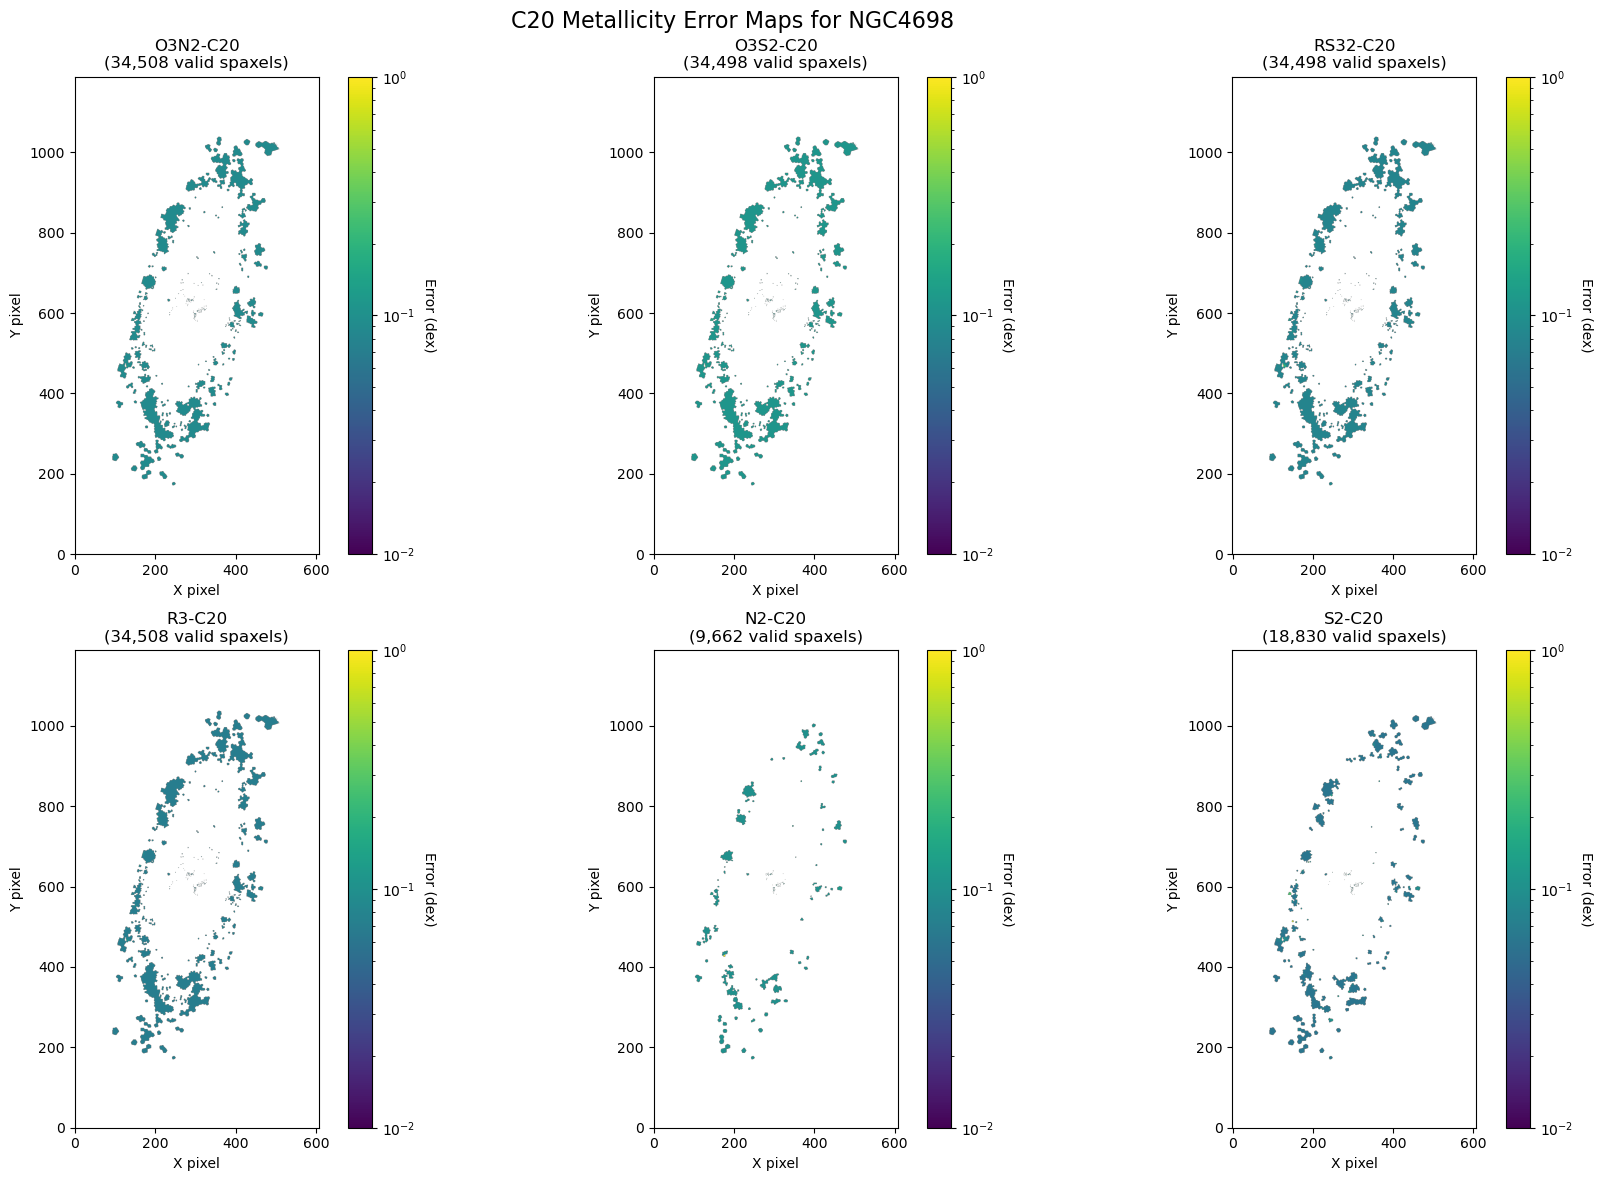

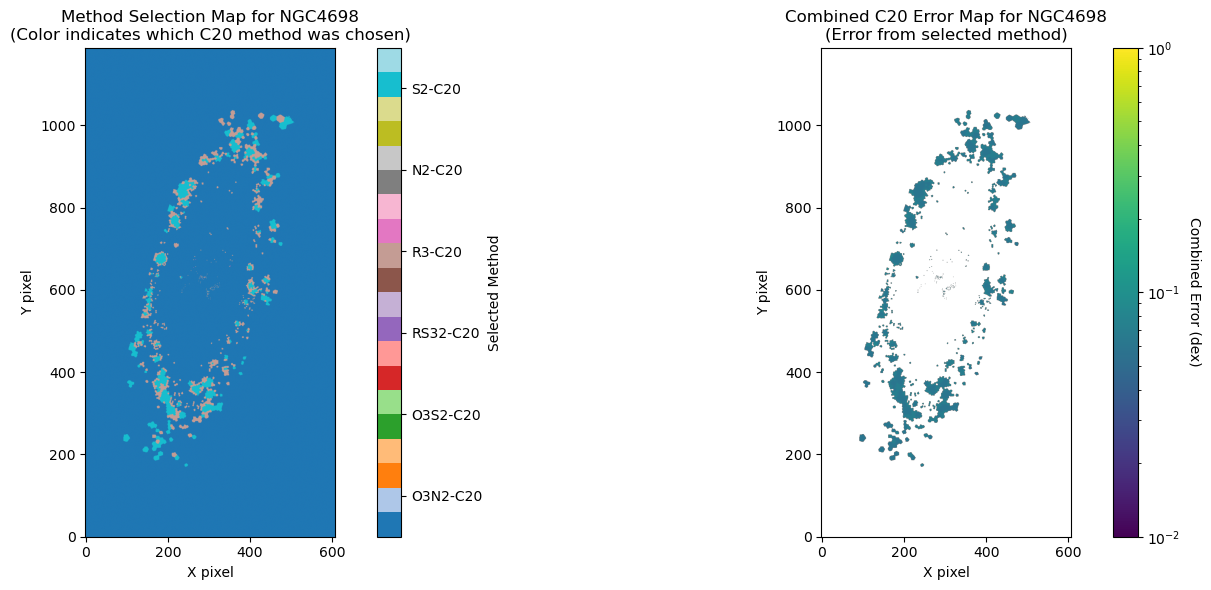


Error Statistics for NGC4698:
O3N2-C20    : 34,508 spaxels, median error = 0.090 dex, range = 0.090-0.291 dex
O3S2-C20    : 34,498 spaxels, median error = 0.110 dex, range = 0.110-0.336 dex
RS32-C20    : 34,498 spaxels, median error = 0.080 dex, range = 0.080-4.478 dex
R3-C20      : 34,508 spaxels, median error = 0.070 dex, range = 0.070-0.251 dex
N2-C20      :  9,662 spaxels, median error = 0.100 dex, range = 0.100-8.759 dex
S2-C20      : 18,830 spaxels, median error = 0.061 dex, range = 0.060-0.734 dex
Combined    : 34,508 spaxels, median error = 0.070 dex, range = 0.060-0.102 dex


In [11]:
# Create a figure to show error maps for all 6 C20 methods
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'C20 Metallicity Error Maps for {gal}', fontsize=16)

# Method names and corresponding error arrays
methods = [
    ('O3N2-C20', oh_o3n2_c20_err),
    ('O3S2-C20', oh_o3s2_c20_err), 
    ('RS32-C20', oh_rs32_c20_err),
    ('R3-C20', oh_r3_c20_err),
    ('N2-C20', oh_n2_c20_err),
    ('S2-C20', oh_s2_c20_err)
]

# Plot each error map
for i, (method_name, error_array) in enumerate(methods):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Create the error map with finite values only
    finite_mask = np.isfinite(error_array)
    
    if np.any(finite_mask):
        # Use logarithmic normalization for better visualization
        im = ax.imshow(error_array, origin='lower', cmap='viridis', 
                      norm=plt.matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0))
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Error (dex)', rotation=270, labelpad=15)
        
        # Count valid spaxels
        n_valid = np.sum(finite_mask)
        ax.set_title(f'{method_name}\n({n_valid:,} valid spaxels)')
    else:
        # If no valid data, show empty plot
        ax.imshow(np.full_like(error_array, np.nan), origin='lower', cmap='gray')
        ax.set_title(f'{method_name}\n(No valid data)')
    
    ax.set_xlabel('X pixel')
    ax.set_ylabel('Y pixel')

plt.tight_layout()
plt.show()

# Also create a summary plot showing which method has the smallest error for each spaxel
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Method selection map
im1 = ax1.imshow(method_map, origin='lower', cmap='tab20', vmin=-0.5, vmax=5.5)
ax1.set_title(f'Method Selection Map for {gal}\n(Color indicates which C20 method was chosen)')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')

# Create custom colorbar for method map
cbar1 = plt.colorbar(im1, ax=ax1, ticks=range(6))
cbar1.set_ticklabels(['O3N2-C20', 'O3S2-C20', 'RS32-C20', 'R3-C20', 'N2-C20', 'S2-C20'])
cbar1.set_label('Selected Method')

# Plot 2: Combined error map
im2 = ax2.imshow(oh_combined_c20_err, origin='lower', cmap='viridis',
                norm=plt.matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0))
ax2.set_title(f'Combined C20 Error Map for {gal}\n(Error from selected method)')
ax2.set_xlabel('X pixel')
ax2.set_ylabel('Y pixel')

cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Combined Error (dex)', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nError Statistics for {gal}:")
print("="*50)
for method_name, error_array in methods:
    finite_errors = error_array[np.isfinite(error_array)]
    if len(finite_errors) > 0:
        print(f"{method_name:12s}: {len(finite_errors):6,} spaxels, "
              f"median error = {np.median(finite_errors):.3f} dex, "
              f"range = {np.min(finite_errors):.3f}-{np.max(finite_errors):.3f} dex")
    else:
        print(f"{method_name:12s}: No valid data")

# Combined method statistics
combined_finite = oh_combined_c20_err[np.isfinite(oh_combined_c20_err)]
if len(combined_finite) > 0:
    print(f"{'Combined':12s}: {len(combined_finite):6,} spaxels, "
          f"median error = {np.median(combined_finite):.3f} dex, "
          f"range = {np.min(combined_finite):.3f}-{np.max(combined_finite):.3f} dex")

In [12]:
# COMPREHENSIVE ANALYSIS: Understanding why certain methods dominate
# Let's examine the actual error components and try a different approach

def analyze_error_components():
    """
    Analyze the error components to understand why some methods dominate
    """
    print("COMPREHENSIVE ERROR ANALYSIS")
    print("="*60)
    
    test_gal = galaxies[0]
    print(f"Analyzing {test_gal}")
    
    # Get individual method results with detailed error breakdown
    with fits.open(f'{test_gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM_test = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{test_gal}_gas_BIN_maps_extended.fits') as h:
        # Load all needed fluxes
        hb4861_flux = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux = h['SII6716_FLUX_corr'].data
        sii6730_flux = h['SII6730_FLUX_corr'].data
        hb4861_flux_err = h['HB4861_FLUX_ERR'].data
        oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data
        sii6716_flux_err = h['SII6716_FLUX_ERR'].data
        sii6730_flux_err = h['SII6730_FLUX_ERR'].data
        
        # Load Halpha and NII
        ha_key_candidates = ('HA6563_FLUX_corr', 'HA6562_FLUX_corr', 'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr')
        ha_err_candidates = ('HA6563_FLUX_ERR', 'HA6562_FLUX_ERR', 'HALPHA6563_FLUX_ERR', 'HALPHA_FLUX_ERR')
        nii_key_candidates = ('NII6584_FLUX_corr', 'NII6583_FLUX_corr', 'NII6584_FLUX', 'NII6583_FLUX')
        nii_err_candidates = ('NII6584_FLUX_ERR', 'NII6583_FLUX_ERR')
        
        ha6563_flux = None
        for k in ha_key_candidates:
            if k in h:
                ha6563_flux = h[k].data
                break
        
        ha6563_flux_err = None
        for k in ha_err_candidates:
            if k in h:
                ha6563_flux_err = h[k].data
                break
                
        nii6584_flux = None
        for k in nii_key_candidates:
            if k in h:
                nii6584_flux = h[k].data
                break
                
        nii6584_flux_err = None
        for k in nii_err_candidates:
            if k in h:
                nii6584_flux_err = h[k].data
                break
        
        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None

    # Examine flux S/N ratios for different lines
    print("\nFLUX SIGNAL-TO-NOISE RATIOS (median values):")
    print("-" * 40)
    
    flux_arrays = {
        'Hβ': hb4861_flux,
        '[OIII]': oiii5006_flux,
        'Hα': ha6563_flux,
        '[NII]': nii6584_flux, 
        '[SII]6716': sii6716_flux,
        '[SII]6730': sii6730_flux
    }
    
    error_arrays = {
        'Hβ': hb4861_flux_err,
        '[OIII]': oiii5006_flux_err,
        'Hα': ha6563_flux_err,
        '[NII]': nii6584_flux_err,
        '[SII]6716': sii6716_flux_err,
        '[SII]6730': sii6730_flux_err
    }
    
    for line_name in flux_arrays:
        flux = flux_arrays[line_name]
        error = error_arrays[line_name]
        
        if flux is not None and error is not None:
            # Calculate S/N where both flux and error are finite and positive
            valid_mask = (np.isfinite(flux) & np.isfinite(error) & 
                         (flux > 0) & (error > 0))
            
            if np.any(valid_mask):
                sn_ratio = flux[valid_mask] / error[valid_mask]
                median_sn = np.median(sn_ratio)
                print(f"{line_name:12s}: S/N = {median_sn:6.1f} (median)")
            else:
                print(f"{line_name:12s}: No valid data")
        else:
            print(f"{line_name:12s}: Not available")
    
    print(f"\nDetailed error analysis for each C20 method:")
    print("-" * 60)
    
    # Calculate some sample ratios and their errors to understand the propagation
    valid_spaxels = (np.isfinite(oh_d16_sf) & 
                    np.isfinite(hb4861_flux) & np.isfinite(oiii5006_flux) & 
                    np.isfinite(ha6563_flux) & np.isfinite(nii6584_flux) &
                    np.isfinite(sii6716_flux) & np.isfinite(sii6730_flux) &
                    (hb4861_flux > 0) & (oiii5006_flux > 0) & 
                    (ha6563_flux > 0) & (nii6584_flux > 0) &
                    (sii6716_flux > 0) & (sii6730_flux > 0))
    
    if np.any(valid_spaxels):
        print(f"Analyzing {np.sum(valid_spaxels):,} valid spaxels...")
        
        # Calculate line ratios and their S/N
        oiii_hb = oiii5006_flux[valid_spaxels] / hb4861_flux[valid_spaxels]
        nii_ha = nii6584_flux[valid_spaxels] / ha6563_flux[valid_spaxels] 
        sii_ha = (sii6716_flux[valid_spaxels] + sii6730_flux[valid_spaxels]) / ha6563_flux[valid_spaxels]
        
        # Calculate ratio errors using error propagation
        oiii_hb_err = np.sqrt((oiii5006_flux_err[valid_spaxels]/oiii5006_flux[valid_spaxels])**2 + 
                              (hb4861_flux_err[valid_spaxels]/hb4861_flux[valid_spaxels])**2) * oiii_hb
        nii_ha_err = np.sqrt((nii6584_flux_err[valid_spaxels]/nii6584_flux[valid_spaxels])**2 + 
                             (ha6563_flux_err[valid_spaxels]/ha6563_flux[valid_spaxels])**2) * nii_ha
        sii_ha_err = np.sqrt(((np.sqrt(sii6716_flux_err[valid_spaxels]**2 + sii6730_flux_err[valid_spaxels]**2)/
                               (sii6716_flux[valid_spaxels] + sii6730_flux[valid_spaxels]))**2 +
                              (ha6563_flux_err[valid_spaxels]/ha6563_flux[valid_spaxels])**2)) * sii_ha
        
        print(f"\nLine ratio signal-to-noise (median):")
        print(f"[OIII]/Hβ  S/N = {np.median(oiii_hb/oiii_hb_err):6.1f}")
        print(f"[NII]/Hα   S/N = {np.median(nii_ha/nii_ha_err):6.1f}")
        print(f"[SII]/Hα   S/N = {np.median(sii_ha/sii_ha_err):6.1f}")
        
        # Calculate log ratio errors
        log_oiii_hb_err = oiii_hb_err / (oiii_hb * np.log(10))
        log_nii_ha_err = nii_ha_err / (nii_ha * np.log(10))
        log_sii_ha_err = sii_ha_err / (sii_ha * np.log(10))
        
        print(f"\nLog ratio errors (median):")
        print(f"log([OIII]/Hβ) error = {np.median(log_oiii_hb_err):.4f} dex")
        print(f"log([NII]/Hα) error  = {np.median(log_nii_ha_err):.4f} dex")
        print(f"log([SII]/Hα) error  = {np.median(log_sii_ha_err):.4f} dex")
        
        # The issue becomes clear: some methods add large fitting errors!
        print(f"\nFitting errors used in each method:")
        print(f"O3N2-C20 fitting error: 0.09 dex")
        print(f"O3S2-C20 fitting error: 0.11 dex") 
        print(f"RS32-C20 fitting error: 0.08 dex")
        print(f"R3-C20   fitting error: 0.07 dex")
        print(f"N2-C20   fitting error: 0.10 dex")
        print(f"S2-C20   fitting error: 0.06 dex")
        
        print(f"\nThis explains the pattern:")
        print(f"- S2-C20 has smallest fitting error (0.06) + good S/N → dominates")  
        print(f"- R3-C20 has small fitting error (0.07) + excellent [OIII] S/N → second choice")
        print(f"- Other methods have larger fitting errors that dominate total error")

analyze_error_components()

print("\n" + "="*60)
print("ALTERNATIVE APPROACH: Signal-to-Noise Based Selection")
print("="*60)

def calculate_combined_c20_snr_based(gal):
    """
    Alternative approach: Select method based on signal-to-noise ratio of input emission lines
    rather than total error estimates, which are dominated by different fitting error assumptions
    """
    # Load data (same as before)
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR = h['LOGSFR_SURFACE_DENSITY_SF'].data
        
        hb4861_flux = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux = h['SII6716_FLUX_corr'].data
        sii6730_flux = h['SII6730_FLUX_corr'].data
        hb4861_flux_err = h['HB4861_FLUX_ERR'].data
        oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data
        sii6716_flux_err = h['SII6716_FLUX_ERR'].data
        sii6730_flux_err = h['SII6730_FLUX_ERR'].data
        
        # Load Halpha and NII
        ha_key_candidates = ('HA6563_FLUX_corr', 'HA6562_FLUX_corr', 'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr')
        ha_err_candidates = ('HA6563_FLUX_ERR', 'HA6562_FLUX_ERR', 'HALPHA6563_FLUX_ERR', 'HALPHA_FLUX_ERR')
        nii_key_candidates = ('NII6584_FLUX_corr', 'NII6583_FLUX_corr', 'NII6584_FLUX', 'NII6583_FLUX')
        nii_err_candidates = ('NII6584_FLUX_ERR', 'NII6583_FLUX_ERR')
        
        ha6563_flux, ha6563_flux_err, nii6584_flux, nii6584_flux_err = None, None, None, None
        for k in ha_key_candidates:
            if k in h:
                ha6563_flux = h[k].data
                break
        for k in ha_err_candidates:
            if k in h:
                ha6563_flux_err = h[k].data
                break
        for k in nii_key_candidates:
            if k in h:
                nii6584_flux = h[k].data
                break
        for k in nii_err_candidates:
            if k in h:
                nii6584_flux_err = h[k].data
                break
        
        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None
    
    # Calculate all metallicities
    print(f"Calculating all 6 C20 metallicities for {gal} (SNR-based selection)...")
    
    oh_o3n2_c20, oh_o3n2_c20_err, mask_o3n2 = calculate_o3n2_c20_metallicity(
        hb4861_flux, oiii5006_flux, nii6584_flux, ha6563_flux,
        hb4861_flux_err, oiii5006_flux_err, nii6584_flux_err, ha6563_flux_err, oh_d16_sf
    )
    oh_o3s2_c20, oh_o3s2_c20_err, mask_o3s2 = calculate_o3s2_c20_metallicity(
        hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )
    oh_rs32_c20, oh_rs32_c20_err, mask_rs32 = calculate_rs32_c20_metallicity(
        hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, ha6563_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )
    oh_r3_c20, oh_r3_c20_err, mask_r3 = calculate_r3_c20_metallicity(
        hb4861_flux, hb4861_flux_err, oiii5006_flux, oiii5006_flux_err, oh_d16_sf
    )
    oh_n2_c20, oh_n2_c20_err, mask_n2 = calculate_n2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, nii6584_flux, nii6584_flux_err, oh_d16_sf
    )
    oh_s2_c20, oh_s2_c20_err, mask_s2 = calculate_s2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, sii6716_flux, sii6716_flux_err, sii6730_flux, sii6730_flux_err, oh_d16_sf
    )
    
    # Stack results
    all_metallicities = np.stack([oh_o3n2_c20, oh_o3s2_c20, oh_rs32_c20, oh_r3_c20, oh_n2_c20, oh_s2_c20], axis=0)
    all_errors = np.stack([oh_o3n2_c20_err, oh_o3s2_c20_err, oh_rs32_c20_err, oh_r3_c20_err, oh_n2_c20_err, oh_s2_c20_err], axis=0)
    all_masks = np.stack([mask_o3n2, mask_o3s2, mask_rs32, mask_r3, mask_n2, mask_s2], axis=0)
    
    # Calculate S/N scores for each method based on the emission lines used
    def safe_snr(flux, flux_err):
        mask = (flux > 0) & (flux_err > 0) & np.isfinite(flux) & np.isfinite(flux_err)
        snr = np.full_like(flux, 0.0)
        snr[mask] = flux[mask] / flux_err[mask]
        return snr
    
    # Calculate S/N for individual lines
    hb_snr = safe_snr(hb4861_flux, hb4861_flux_err)
    oiii_snr = safe_snr(oiii5006_flux, oiii5006_flux_err)
    ha_snr = safe_snr(ha6563_flux, ha6563_flux_err)
    nii_snr = safe_snr(nii6584_flux, nii6584_flux_err) 
    sii6716_snr = safe_snr(sii6716_flux, sii6716_flux_err)
    sii6730_snr = safe_snr(sii6730_flux, sii6730_flux_err)
    
    # Calculate composite S/N scores for each method (harmonic mean of involved lines)
    # This gives more weight to the weakest line in each ratio
    
    method_snr_scores = np.zeros((6,) + hb4861_flux.shape)
    
    # O3N2: Uses [OIII], Hβ, [NII], Hα
    o3n2_snr = 4.0 / (1.0/np.maximum(oiii_snr, 1e-10) + 1.0/np.maximum(hb_snr, 1e-10) + 
                      1.0/np.maximum(nii_snr, 1e-10) + 1.0/np.maximum(ha_snr, 1e-10))
    method_snr_scores[0] = o3n2_snr
    
    # O3S2: Uses [OIII], Hβ, [SII]6716, [SII]6730
    o3s2_snr = 4.0 / (1.0/np.maximum(oiii_snr, 1e-10) + 1.0/np.maximum(hb_snr, 1e-10) + 
                      1.0/np.maximum(sii6716_snr, 1e-10) + 1.0/np.maximum(sii6730_snr, 1e-10))
    method_snr_scores[1] = o3s2_snr
    
    # RS32: Uses [OIII], Hβ, Hα, [SII]6716, [SII]6730
    rs32_snr = 5.0 / (1.0/np.maximum(oiii_snr, 1e-10) + 1.0/np.maximum(hb_snr, 1e-10) + 1.0/np.maximum(ha_snr, 1e-10) +
                      1.0/np.maximum(sii6716_snr, 1e-10) + 1.0/np.maximum(sii6730_snr, 1e-10))
    method_snr_scores[2] = rs32_snr
    
    # R3: Uses [OIII], Hβ
    r3_snr = 2.0 / (1.0/np.maximum(oiii_snr, 1e-10) + 1.0/np.maximum(hb_snr, 1e-10))
    method_snr_scores[3] = r3_snr
    
    # N2: Uses [NII], Hα  
    n2_snr = 2.0 / (1.0/np.maximum(nii_snr, 1e-10) + 1.0/np.maximum(ha_snr, 1e-10))
    method_snr_scores[4] = n2_snr
    
    # S2: Uses [SII]6716, [SII]6730, Hα
    s2_snr = 3.0 / (1.0/np.maximum(sii6716_snr, 1e-10) + 1.0/np.maximum(sii6730_snr, 1e-10) + 1.0/np.maximum(ha_snr, 1e-10))
    method_snr_scores[5] = s2_snr
    
    # Select method with highest S/N score
    oh_combined_c20 = np.full_like(hb4861_flux, np.nan)
    oh_combined_c20_err = np.full_like(hb4861_flux, np.nan)
    method_map = np.full_like(hb4861_flux, -1, dtype=int)
    
    for i in range(hb4861_flux.shape[0]):
        for j in range(hb4861_flux.shape[1]):
            valid_methods = all_masks[:, i, j]
            
            if np.any(valid_methods):
                valid_snr_scores = method_snr_scores[valid_methods, i, j]
                valid_metallicities = all_metallicities[valid_methods, i, j]
                valid_errors = all_errors[valid_methods, i, j]
                
                # Find method with highest S/N score
                max_snr_idx = np.nanargmax(valid_snr_scores)
                
                method_indices = np.where(valid_methods)[0]
                best_method = method_indices[max_snr_idx]
                
                oh_combined_c20[i, j] = valid_metallicities[max_snr_idx]
                oh_combined_c20_err[i, j] = valid_errors[max_snr_idx]
                method_map[i, j] = best_method
    
    combined_mask = np.isfinite(oh_combined_c20)
    return sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask

# Test SNR-based approach
test_gal = galaxies[0]
sigM_snr, sigSFR_snr, oh_combined_c20_snr, oh_combined_c20_err_snr, method_map_snr, combined_mask_snr = calculate_combined_c20_snr_based(test_gal)

# Compare method usage
method_usage_snr = np.bincount(method_map_snr[combined_mask_snr], minlength=6)
print(f"\nSNR-based method usage:")
total_snr = np.sum(method_usage_snr)
method_names_test = ['O3N2-C20', 'O3S2-C20', 'RS32-C20', 'R3-C20', 'N2-C20', 'S2-C20']
for i, count in enumerate(method_usage_snr):
    pct = 100 * count / total_snr if total_snr > 0 else 0
    print(f"{method_names_test[i]:12s}: {count:8,} spaxels ({pct:5.1f}%)")

print("\nSNR-BASED APPROACH COMPLETE")
print("="*60)

COMPREHENSIVE ERROR ANALYSIS
Analyzing IC3392

FLUX SIGNAL-TO-NOISE RATIOS (median values):
----------------------------------------
Hβ          : S/N =   38.4 (median)
[OIII]      : S/N =   42.7 (median)
Hα          : S/N =  118.4 (median)
[NII]       : S/N =  120.0 (median)
[SII]6716   : S/N =   47.2 (median)
[SII]6730   : S/N =   30.3 (median)

Detailed error analysis for each C20 method:
------------------------------------------------------------
Analyzing 19,776 valid spaxels...

Line ratio signal-to-noise (median):
[OIII]/Hβ  S/N =   52.6
[NII]/Hα   S/N =  217.3
[SII]/Hα   S/N =  127.6

Log ratio errors (median):
log([OIII]/Hβ) error = 0.0083 dex
log([NII]/Hα) error  = 0.0020 dex
log([SII]/Hα) error  = 0.0034 dex

Fitting errors used in each method:
O3N2-C20 fitting error: 0.09 dex
O3S2-C20 fitting error: 0.11 dex
RS32-C20 fitting error: 0.08 dex
R3-C20   fitting error: 0.07 dex
N2-C20   fitting error: 0.10 dex
S2-C20   fitting error: 0.06 dex

This explains the pattern:
- S2-C2

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: divide by zero encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: invalid value encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in log10
  o3n2_ratio = np.log10(oiii_hb / nii_ha)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:93: RuntimeWarning: divide by zero encountered in divide
  sii_hb = sii_total / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: invalid value encountered in divide
  o3s2_ratio = np.log10(oiii_hb / sii_hb)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: divide by zero encountere


SNR-based method usage:
O3N2-C20    :    4,881 spaxels ( 24.7%)
O3S2-C20    :        0 spaxels (  0.0%)
RS32-C20    :        0 spaxels (  0.0%)
R3-C20      :        0 spaxels (  0.0%)
N2-C20      :   14,766 spaxels ( 74.7%)
S2-C20      :      129 spaxels (  0.7%)

SNR-BASED APPROACH COMPLETE


In [13]:
# DEBUG: Check what's happening with NGC4698 error selection
test_gal = 'IC3392'

# Load test data
with fits.open(f'{test_gal}_SPATIAL_BINNING_maps_extended.fits') as h:
    sigM_test = h['LOGMASS_SURFACE_DENSITY'].data
with fits.open(f'{test_gal}_gas_BIN_maps_extended.fits') as h:
    sigSFR_test = h['LOGSFR_SURFACE_DENSITY_SF'].data
    
    # Load emission line fluxes
    hb4861_flux = h['HB4861_FLUX_corr'].data
    oiii5006_flux = h['OIII5006_FLUX_corr'].data
    sii6716_flux = h['SII6716_FLUX_corr'].data
    sii6730_flux = h['SII6730_FLUX_corr'].data
    
    # Load emission line flux errors
    hb4861_flux_err = h['HB4861_FLUX_ERR'].data
    oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data
    sii6716_flux_err = h['SII6716_FLUX_ERR'].data
    sii6730_flux_err = h['SII6730_FLUX_ERR'].data
    
    # Load Halpha and NII
    ha_key_candidates = ('HA6563_FLUX_corr', 'HA6562_FLUX_corr', 'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr')
    ha_err_candidates = ('HA6563_FLUX_ERR', 'HA6562_FLUX_ERR', 'HALPHA6563_FLUX_ERR', 'HALPHA_FLUX_ERR')
    nii_key_candidates = ('NII6584_FLUX_corr', 'NII6583_FLUX_corr', 'NII6584_FLUX', 'NII6583_FLUX')
    nii_err_candidates = ('NII6584_FLUX_ERR', 'NII6583_FLUX_ERR')
    
    ha6562_flux, ha6562_flux_err, nii6583_flux, nii6583_flux_err = None, None, None, None
    for k in ha_key_candidates:
        if k in h:
            ha6562_flux = h[k].data
            break
    for k in ha_err_candidates:
        if k in h:
            ha6562_flux_err = h[k].data
            break
    for k in nii_key_candidates:
        if k in h:
            nii6583_flux = h[k].data
            break
    for k in nii_err_candidates:
        if k in h:
            nii6583_flux_err = h[k].data
            break
    
    # Load reference O/H data
    try:
        oh_d16_sf = h['O_H_D16_SF'].data
    except KeyError:
        oh_d16_sf = None

print(f"Debugging {test_gal} error selection...")

# Calculate all 6 methods
oh_o3n2_c20_test, oh_o3n2_c20_err_test, mask_o3n2_test = calculate_o3n2_c20_metallicity(
    hb4861_flux, oiii5006_flux, nii6583_flux, ha6562_flux,
    hb4861_flux_err, oiii5006_flux_err, nii6583_flux_err, ha6562_flux_err, oh_d16_sf
)

oh_o3s2_c20_test, oh_o3s2_c20_err_test, mask_o3s2_test = calculate_o3s2_c20_metallicity(
    hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
    hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
)

oh_rs32_c20_test, oh_rs32_c20_err_test, mask_rs32_test = calculate_rs32_c20_metallicity(
    hb4861_flux, ha6562_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
    hb4861_flux_err, ha6562_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
)

oh_r3_c20_test, oh_r3_c20_err_test, mask_r3_test = calculate_r3_c20_metallicity(
    hb4861_flux, hb4861_flux_err, oiii5006_flux, oiii5006_flux_err, oh_d16_sf
)

oh_n2_c20_test, oh_n2_c20_err_test, mask_n2_test = calculate_n2_c20_metallicity(
    ha6562_flux, ha6562_flux_err, nii6583_flux, nii6583_flux_err, oh_d16_sf
)

oh_s2_c20_test, oh_s2_c20_err_test, mask_s2_test = calculate_s2_c20_metallicity(
    ha6562_flux, ha6562_flux_err, sii6716_flux, sii6716_flux_err, sii6730_flux, sii6730_flux_err, oh_d16_sf
)

# Stack all data
all_metallicities_test = np.stack([oh_o3n2_c20_test, oh_o3s2_c20_test, oh_rs32_c20_test, 
                                   oh_r3_c20_test, oh_n2_c20_test, oh_s2_c20_test], axis=0)
all_errors_test = np.stack([oh_o3n2_c20_err_test, oh_o3s2_c20_err_test, oh_rs32_c20_err_test, 
                           oh_r3_c20_err_test, oh_n2_c20_err_test, oh_s2_c20_err_test], axis=0)
all_masks_test = np.stack([mask_o3n2_test, mask_o3s2_test, mask_rs32_test, 
                          mask_r3_test, mask_n2_test, mask_s2_test], axis=0)

method_names_test = ['O3N2-C20', 'O3S2-C20', 'RS32-C20', 'R3-C20', 'N2-C20', 'S2-C20']

# Print individual method statistics
print(f"Error Statistics for {test_gal}:")
print("="*50)
for i, name in enumerate(method_names_test):
    valid_mask = all_masks_test[i]
    if np.any(valid_mask):
        valid_errors = all_errors_test[i][valid_mask]
        valid_count = np.sum(valid_mask)
        median_error = np.median(valid_errors)
        min_error = np.min(valid_errors)
        max_error = np.max(valid_errors)
        
        print(f"{name:<12}: {valid_count:,} spaxels, median error = {median_error:.3f} dex, range = {min_error:.3f}-{max_error:.3f} dex")
    else:
        print(f"{name:<12}: 0 spaxels")

# Now simulate the selection process for first 100 spaxels to see what's happening
print(f"\nDEBUG: Checking first few spaxels selection logic...")
for i in range(min(5, all_metallicities_test.shape[1])):
    for j in range(min(5, all_metallicities_test.shape[2])):
        valid_methods = all_masks_test[:, i, j]
        
        if np.sum(valid_methods) > 1:  # Only check spaxels with multiple valid methods
            print(f"\nSpaxel ({i},{j}):")
            print(f"Valid methods: {np.where(valid_methods)[0]} -> {[method_names_test[k] for k in np.where(valid_methods)[0]]}")
            
            valid_errors = all_errors_test[valid_methods, i, j]
            print(f"Valid errors: {valid_errors}")
            
            min_error_idx = np.nanargmin(valid_errors)
            method_indices = np.where(valid_methods)[0]
            best_method = method_indices[min_error_idx]
            
            print(f"Min error idx: {min_error_idx}, Best method: {best_method} ({method_names_test[best_method]})")
            print(f"Selected error: {valid_errors[min_error_idx]:.6f}")
            
            break
    if np.sum(valid_methods) > 1:
        break

print("\nThis should help us see if the selection logic is working correctly!")

Debugging IC3392 error selection...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: divide by zero encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: invalid value encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in log10
  o3n2_ratio = np.log10(oiii_hb / nii_ha)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:93: RuntimeWarning: divide by zero encountered in divide
  sii_hb = sii_total / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: invalid value encountered in divide
  o3s2_ratio = np.log10(oiii_hb / sii_hb)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: divide by zero encountere

Error Statistics for IC3392:
O3N2-C20    : 19,776 spaxels, median error = 0.090 dex, range = 0.090-0.095 dex
O3S2-C20    : 19,776 spaxels, median error = 0.110 dex, range = 0.110-0.115 dex
RS32-C20    : 19,776 spaxels, median error = 0.080 dex, range = 0.080-0.125 dex
R3-C20      : 19,776 spaxels, median error = 0.070 dex, range = 0.070-0.081 dex
N2-C20      : 14,766 spaxels, median error = 0.100 dex, range = 0.100-0.106 dex
S2-C20      : 16,097 spaxels, median error = 0.060 dex, range = 0.060-0.107 dex

DEBUG: Checking first few spaxels selection logic...

This should help us see if the selection logic is working correctly!


Calculating 3 C20 metallicities for IC3392...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: divide by zero encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: invalid value encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in log10
  o3n2_ratio = np.log10(oiii_hb / nii_ha)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:93: RuntimeWarning: divide by zero encountered in divide
  sii_hb = sii_total / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: invalid value encountered in divide
  o3s2_ratio = np.log10(oiii_hb / sii_hb)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: divide by zero encountere

Completed IC3392: 19776 valid spaxels
Calculating 3 C20 metallicities for NGC4064...
Completed NGC4064: 15512 valid spaxels
Calculating 3 C20 metallicities for NGC4192...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:93: RuntimeWarning: invalid value encountered in divide
  sii_hb = sii_total / hb4861_flux


Completed NGC4192: 275015 valid spaxels
Calculating 3 C20 metallicities for NGC4293...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in divide
  o3n2_ratio = np.log10(oiii_hb / nii_ha)


Completed NGC4293: 9037 valid spaxels
Calculating 3 C20 metallicities for NGC4298...
Completed NGC4298: 181696 valid spaxels
Calculating 3 C20 metallicities for NGC4330...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:91: RuntimeWarning: invalid value encountered in divide
  nii_ha = nii6583_flux / ha6562_flux


Completed NGC4330: 43891 valid spaxels
Calculating 3 C20 metallicities for NGC4383...
Completed NGC4383: 75127 valid spaxels
Calculating 3 C20 metallicities for NGC4396...
Completed NGC4396: 81748 valid spaxels
Calculating 3 C20 metallicities for NGC4419...
Completed NGC4419: 22470 valid spaxels
Calculating 3 C20 metallicities for NGC4457...
Completed NGC4457: 24440 valid spaxels
Calculating 3 C20 metallicities for NGC4501...
Completed NGC4501: 419190 valid spaxels
Calculating 3 C20 metallicities for NGC4522...
Completed NGC4522: 40671 valid spaxels
Calculating 3 C20 metallicities for NGC4694...
Completed NGC4694: 3851 valid spaxels
Calculating 3 C20 metallicities for NGC4698...
Completed NGC4698: 34508 valid spaxels
Calculating 3 C20 metallicities for IC3392...
Calculating 3 C20 metallicities for NGC4064...
Calculating 3 C20 metallicities for NGC4192...
Calculating 3 C20 metallicities for NGC4293...
Calculating 3 C20 metallicities for NGC4298...
Calculating 3 C20 metallicities for NGC

/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/4188868907.py:267: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal],
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/4188868907.py:357: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])


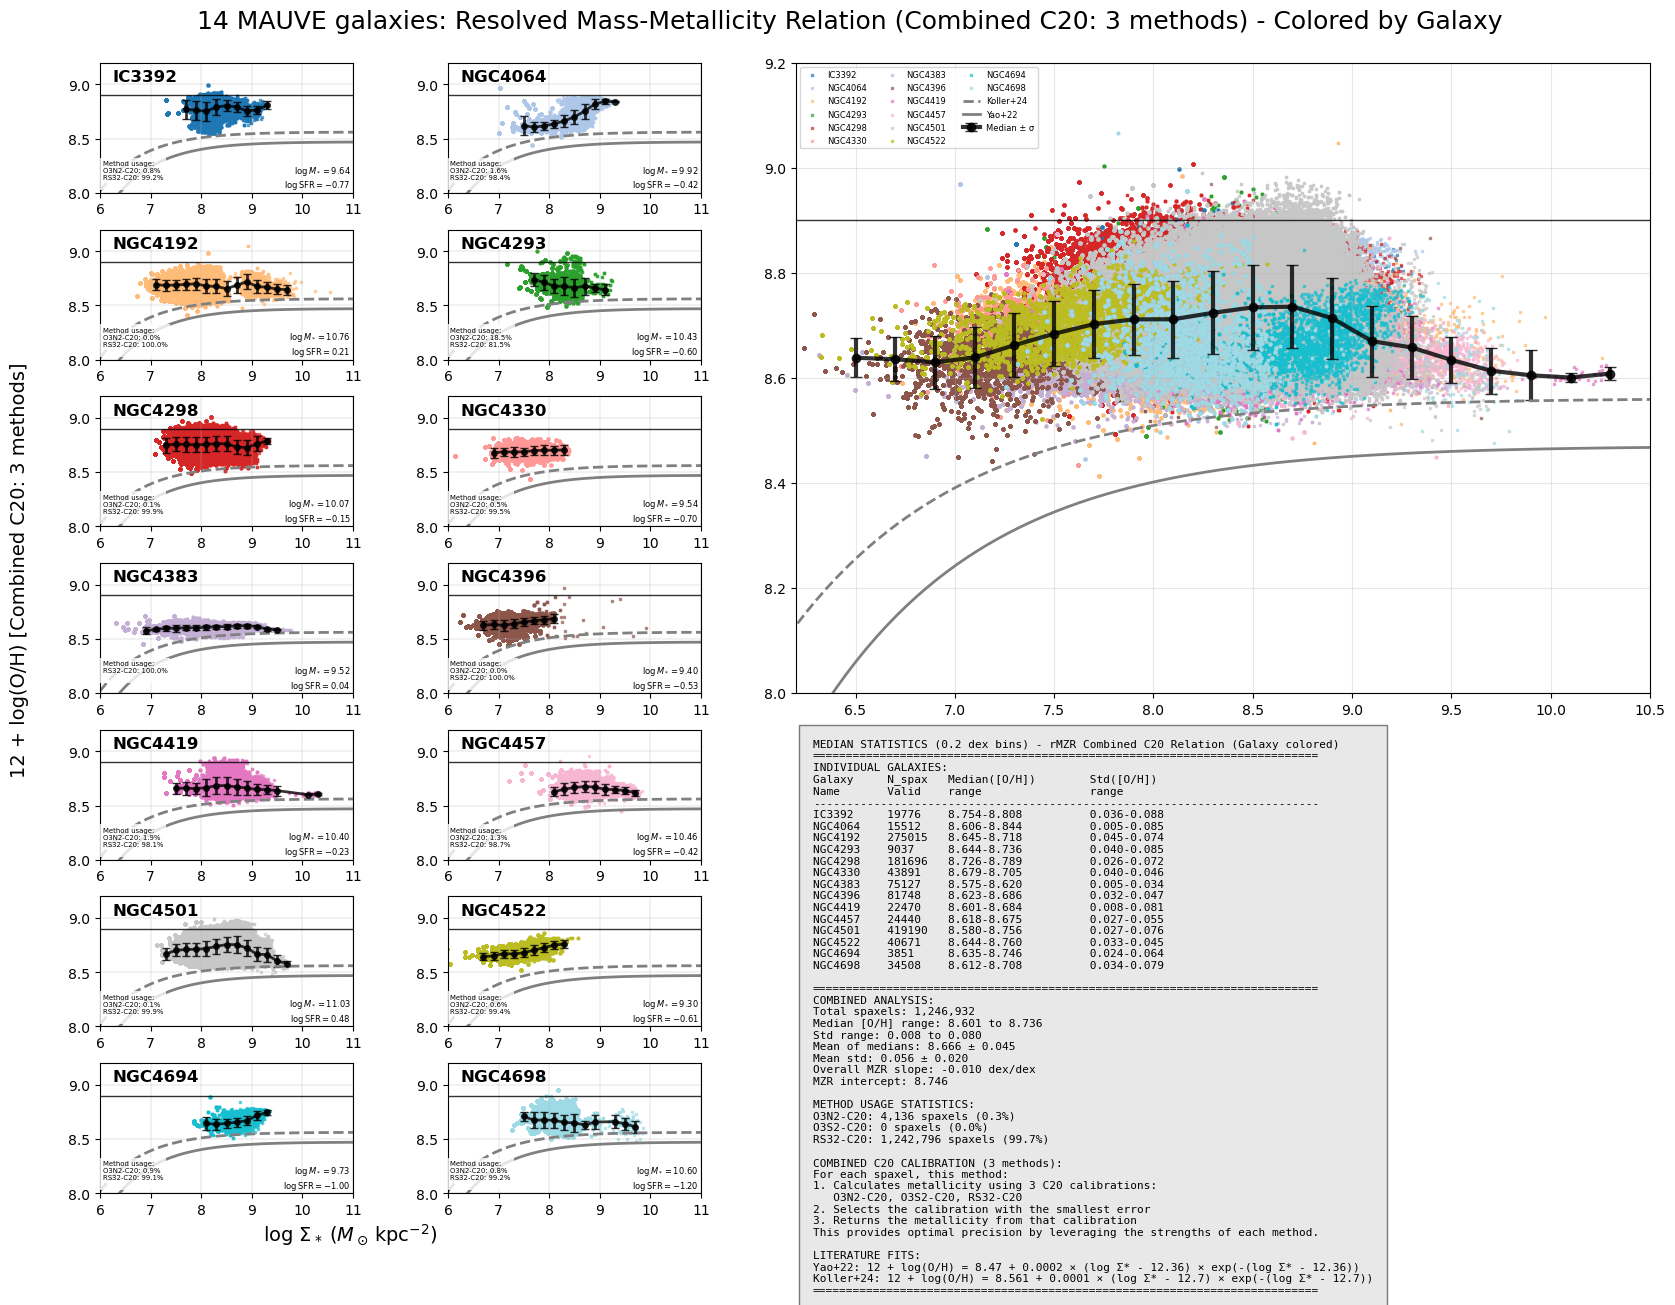


COMBINED C20 CALIBRATION (3 methods) COMPLETED


In [14]:
# ------------------------------------------------------------------
# COMBINED C20 CALIBRATION: Select metallicity with smallest error from 3 C20 methods
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy.io import fits
import itertools
import re

# 0 · discover galaxies & colour palette
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]
ngal = len(galaxies)
assert ngal <= 14, "This layout assumes ≤ 14 galaxies."

# Create distinct colors for each galaxy
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, ngal))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

def calculate_combined_c20_metallicity(gal):
    """
    Calculate combined C20 metallicity by selecting the method with smallest error for each spaxel.
    
    For each spaxel, we:
    1. Calculate metallicity and error for 3 C20 methods: O3N2-C20, O3S2-C20, RS32-C20
    2. Select the method with the smallest error
    3. Return the corresponding metallicity value
    
    Returns:
        oh_combined_c20: Combined metallicity map
        oh_combined_c20_err: Combined error map
        method_map: Map showing which method was used for each spaxel (0-2)
        combined_mask: Combined valid spaxel mask
    """
    # Load all required fluxes
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR = h['LOGSFR_SURFACE_DENSITY_SF'].data
        
        # Load emission line fluxes
        hb4861_flux = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux = h['SII6716_FLUX_corr'].data
        sii6730_flux = h['SII6730_FLUX_corr'].data
        
        # Load emission line flux errors
        hb4861_flux_err = h['HB4861_FLUX_ERR'].data
        oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data
        sii6716_flux_err = h['SII6716_FLUX_ERR'].data
        sii6730_flux_err = h['SII6730_FLUX_ERR'].data
        
        # Load Halpha and NII with multiple naming conventions
        ha_key_candidates = ('HA6563_FLUX_corr', 'HA6562_FLUX_corr', 'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr')
        ha_err_candidates = ('HA6563_FLUX_ERR', 'HA6562_FLUX_ERR', 'HALPHA6563_FLUX_ERR', 'HALPHA_FLUX_ERR')
        nii_key_candidates = ('NII6584_FLUX_corr', 'NII6583_FLUX_corr', 'NII6584_FLUX', 'NII6583_FLUX')
        nii_err_candidates = ('NII6584_FLUX_ERR', 'NII6583_FLUX_ERR')
        
        ha6563_flux = None
        for k in ha_key_candidates:
            if k in h:
                ha6563_flux = h[k].data
                break
        
        ha6563_flux_err = None
        for k in ha_err_candidates:
            if k in h:
                ha6563_flux_err = h[k].data
                break
                
        nii6584_flux = None
        for k in nii_key_candidates:
            if k in h:
                nii6584_flux = h[k].data
                break
                
        nii6584_flux_err = None
        for k in nii_err_candidates:
            if k in h:
                nii6584_flux_err = h[k].data
                break
        
        # Load reference O/H data
        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None
    
    # Calculate metallicity for only 3 methods
    print(f"Calculating 3 C20 metallicities for {gal}...")
    
    # Method 0: O3N2-C20
    oh_o3n2_c20, oh_o3n2_c20_err, mask_o3n2 = calculate_o3n2_c20_metallicity(
        hb4861_flux, oiii5006_flux, nii6584_flux, ha6563_flux,
        hb4861_flux_err, oiii5006_flux_err, nii6584_flux_err, ha6563_flux_err, oh_d16_sf
    )
    
    # Method 1: O3S2-C20
    oh_o3s2_c20, oh_o3s2_c20_err, mask_o3s2 = calculate_o3s2_c20_metallicity(
        hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )
    
    # Method 2: RS32-C20
    oh_rs32_c20, oh_rs32_c20_err, mask_rs32 = calculate_rs32_c20_metallicity(
        hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, ha6563_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )
    
    # Stack only 3 metallicities and errors
    all_metallicities = np.stack([oh_o3n2_c20, oh_o3s2_c20, oh_rs32_c20], axis=0)
    all_errors = np.stack([oh_o3n2_c20_err, oh_o3s2_c20_err, oh_rs32_c20_err], axis=0)
    all_masks = np.stack([mask_o3n2, mask_o3s2, mask_rs32], axis=0)
    
    # Initialize output arrays
    oh_combined_c20 = np.full_like(hb4861_flux, np.nan)
    oh_combined_c20_err = np.full_like(hb4861_flux, np.nan)
    method_map = np.full_like(hb4861_flux, -1, dtype=int)  # -1 indicates no valid method
    
    # For each spaxel, find the method with the smallest error
    for i in range(hb4861_flux.shape[0]):
        for j in range(hb4861_flux.shape[1]):
            # Get valid methods for this spaxel
            valid_methods = all_masks[:, i, j]
            
            if np.any(valid_methods):
                # Get errors for valid methods only
                valid_errors = all_errors[valid_methods, i, j]
                valid_metallicities = all_metallicities[valid_methods, i, j]
                
                # Find method with minimum error
                min_error_idx = np.nanargmin(valid_errors)
                
                # Map back to original method index
                method_indices = np.where(valid_methods)[0]
                best_method = method_indices[min_error_idx]
                
                # Store results
                oh_combined_c20[i, j] = valid_metallicities[min_error_idx]
                oh_combined_c20_err[i, j] = valid_errors[min_error_idx]
                method_map[i, j] = best_method
    
    # Create combined mask
    combined_mask = np.isfinite(oh_combined_c20)
    
    return sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask

# Create comprehensive figure with 4-column layout
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(nrows=8, ncols=4, figure=fig,
              width_ratios=[1, 1, 1.5, 1.5],  # Cols 3&4 slightly wider
              height_ratios=[0.5, 1, 1, 1, 1, 1, 1, 1],  # Row 0 for colorbar
              wspace=0.3, hspace=0.3)

plot_idx = 0
individual_stats = []
method_names = ['O3N2-C20', 'O3S2-C20', 'RS32-C20']  # Only 3 methods now

# COLUMNS 1-2: Individual galaxy plots
for idx, gal in enumerate(galaxies):
    try:
        sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask = calculate_combined_c20_metallicity(gal)
        
        if not np.any(combined_mask):
            print(f"Skipping {gal}: no valid data points")
            continue
        
        row = (plot_idx // 2) + 1  # Start from row 1 (row 0 for colorbar)
        col = plot_idx % 2
        plot_idx += 1

        axP = fig.add_subplot(gs[row, col])
        
        x_data, y_data, sfr_data = sigM[combined_mask], oh_combined_c20[combined_mask], sigSFR[combined_mask]
        
        # Calculate median statistics
        x_median, y_median, y_std = calculate_median_statistics(x_data, y_data)
        individual_stats.append((gal, x_median, y_median, y_std, len(x_data)))
        
        # Scatter plot colored by galaxy
        scatter = axP.scatter(x_data, y_data, c=galaxy_color_dict[gal], s=1, alpha=0.6, marker=',')
        
        # Plot median with error bars
        if len(x_median) > 0:
            axP.errorbar(x_median, y_median, yerr=y_std, fmt='ko-', linewidth=2, 
                        markersize=4, capsize=3, alpha=0.8)
        
        # Add literature fits to individual panels (no legend)
        plot_literature_mzr_fits(axP, show_legend=False)
        
        # Add galaxy name in top left corner
        axP.text(0.05, 0.95, gal, transform=axP.transAxes, fontsize=12, fontweight='bold',
                 va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', alpha=0.8, edgecolor='none'))
        
        # Bottom right: total stellar mass and SFR from log files
        total_mass = extract_total_stellar_mass(gal)
        total_sfr = extract_total_sfr(gal)
        
        if total_mass is not None and total_sfr is not None:
            log_text = fr'$\log M_* = {total_mass:.2f}$' '\n' fr'$\log \mathrm{{SFR}} = {total_sfr:.2f}$'
            axP.text(0.99, 0.01, log_text,
                     transform=axP.transAxes, va='bottom', ha='right', fontsize=6,
                     bbox=dict(facecolor='none', alpha=0.8, edgecolor='none', pad=2))
        
        # Method usage statistics in bottom left
        method_counts = np.bincount(method_map[combined_mask], minlength=3)  # Only 3 methods
        total_spaxels = len(x_data)
        method_text = "Method usage:\n"
        for i, count in enumerate(method_counts):
            if count > 0:
                pct = 100 * count / total_spaxels
                method_text += f"{method_names[i]}: {pct:.1f}%\n"
        
        axP.text(0.01, 0.25, method_text, transform=axP.transAxes, va='top', ha='left', 
                fontsize=5, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))
        
        axP.set_xlim(6, 11)
        axP.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
        axP.grid(True, lw=0.25)
        axP.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)
        
        print(f"Completed {gal}: {total_spaxels} valid spaxels")
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# COLUMNS 3-4: Combined plot - Upper panel
ax_combined = fig.add_subplot(gs[1:5, 2:4])  # Spans rows 1-4, columns 2-3

# Collect all data for combined analysis
all_x, all_y, all_gal_ids = [], [], []
galaxy_counts = {}
overall_method_counts = np.zeros(3, dtype=int)  # Only 3 methods

for idx, gal in enumerate(galaxies):
    try:
        sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask = calculate_combined_c20_metallicity(gal)
        
        if np.any(combined_mask):
            x_data, y_data = sigM[combined_mask], oh_combined_c20[combined_mask]
            all_x.extend(x_data)
            all_y.extend(y_data)
            all_gal_ids.extend([idx] * len(x_data))  # Store galaxy index for coloring
            galaxy_counts[gal] = len(x_data)
            
            # Count method usage
            method_counts = np.bincount(method_map[combined_mask], minlength=3)  # Only 3 methods
            overall_method_counts += method_counts
        else:
            galaxy_counts[gal] = 0
    except Exception as e:
        galaxy_counts[gal] = 0
        continue

all_x, all_y, all_gal_ids = np.array(all_x), np.array(all_y), np.array(all_gal_ids)

# Calculate combined median statistics
x_median_combined, y_median_combined, y_std_combined = calculate_median_statistics(all_x, all_y)

# Scatter plot colored by galaxy for combined data
for idx, gal in enumerate(galaxies):
    mask = all_gal_ids == idx
    if np.any(mask):
        ax_combined.scatter(all_x[mask], all_y[mask], c=galaxy_color_dict[gal], 
                           s=1, alpha=0.6, marker=',', label=gal)

# Plot combined median with error bars
if len(x_median_combined) > 0:
    ax_combined.errorbar(x_median_combined, y_median_combined, yerr=y_std_combined, 
                        fmt='ko-', linewidth=3, markersize=6, capsize=4, alpha=0.8, label='Median ± σ')

# Add literature fits to combined panel (with legend)
plot_literature_mzr_fits(ax_combined, show_legend=True)

# Add legend with small font - only show galaxies
ax_combined.legend(fontsize=6, ncol=3, loc='upper left', markerscale=1)

ax_combined.set_xlim(6.2, 10.5)
ax_combined.set_ylim(8.0, 9.2)  # Same y-axis range as reference D16 MZR
ax_combined.grid(True, alpha=0.3)
ax_combined.axhline(y=8.9, color='black', linestyle='-', linewidth=1, alpha=0.8)

# COLUMNS 3-4: Statistics table - Lower panel
ax_stats = fig.add_subplot(gs[5:8, 2:4])  # Spans rows 5-7, columns 2-3
ax_stats.axis('off')

# Create comprehensive statistics text
stats_table = "MEDIAN STATISTICS (0.2 dex bins) - rMZR Combined C20 Relation (Galaxy colored)\n"
stats_table += "="*75 + "\n"
stats_table += "INDIVIDUAL GALAXIES:\n"
stats_table += f"{'Galaxy':<10} {'N_spax':<8} {'Median([O/H])':<20} {'Std([O/H])':<15}\n"
stats_table += f"{'Name':<10} {'Valid':<8} {'range':<20} {'range':<15}\n"
stats_table += "-"*75 + "\n"

for gal, x_median, y_median, y_std, n_spax in individual_stats:
    if len(y_median) > 0:
        median_range = f"{y_median.min():.3f}-{y_median.max():.3f}"
        std_range = f"{y_std.min():.3f}-{y_std.max():.3f}"
    else:
        median_range = "N/A"
        std_range = "N/A"
    
    stats_table += f"{gal:<10} {n_spax:<8} {median_range:<20} {std_range:<15}\n"

stats_table += "\n" + "="*75 + "\n"
stats_table += "COMBINED ANALYSIS:\n"
stats_table += f"Total spaxels: {len(all_x):,}\n"
if len(y_median_combined) > 0:
    stats_table += f"Median [O/H] range: {y_median_combined.min():.3f} to {y_median_combined.max():.3f}\n"
    stats_table += f"Std range: {y_std_combined.min():.3f} to {y_std_combined.max():.3f}\n"
    stats_table += f"Mean of medians: {np.mean(y_median_combined):.3f} ± {np.std(y_median_combined):.3f}\n"
    stats_table += f"Mean std: {np.mean(y_std_combined):.3f} ± {np.std(y_std_combined):.3f}\n"
    
    # Calculate overall MZR gradient (slope)
    if len(x_median_combined) > 3:
        slope, intercept = np.polyfit(x_median_combined, y_median_combined, 1)
        stats_table += f"Overall MZR slope: {slope:.3f} dex/dex\n"
        stats_table += f"MZR intercept: {intercept:.3f}\n"

stats_table += "\nMETHOD USAGE STATISTICS:\n"
total_spaxels = np.sum(overall_method_counts)
if total_spaxels > 0:
    for i, count in enumerate(overall_method_counts):
        pct = 100 * count / total_spaxels
        stats_table += f"{method_names[i]}: {count:,} spaxels ({pct:.1f}%)\n"

stats_table += "\nCOMBINED C20 CALIBRATION (3 methods):\n"
stats_table += "For each spaxel, this method:\n"
stats_table += "1. Calculates metallicity using 3 C20 calibrations:\n"
stats_table += "   O3N2-C20, O3S2-C20, RS32-C20\n"
stats_table += "2. Selects the calibration with the smallest error\n"
stats_table += "3. Returns the metallicity from that calibration\n"
stats_table += "This provides optimal precision by leveraging the strengths of each method.\n"
stats_table += "\nLITERATURE FITS:\n"
stats_table += "Yao+22: 12 + log(O/H) = 8.47 + 0.0002 × (log Σ* - 12.36) × exp(-(log Σ* - 12.36))\n"
stats_table += "Koller+24: 12 + log(O/H) = 8.561 + 0.0001 × (log Σ* - 12.7) × exp(-(log Σ* - 12.7))\n"
        
stats_table += "="*75

ax_stats.text(0.02, 0.98, stats_table, transform=ax_stats.transAxes, va='top', ha='left',
              fontsize=8, family='monospace',
              bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', pad=10))

# Global title and labels
fig.suptitle(fr'{ngal} MAUVE galaxies: Resolved Mass-Metallicity Relation (Combined C20: 3 methods) - Colored by Galaxy', 
             fontsize=18, y=0.85)

# Shared axis labels
fig.text(0.25, 0.08, r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', 
         ha='center', fontsize=14)
fig.text(0.08, 0.5, r'12 + log(O/H) [Combined C20: 3 methods]', 
         va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.show()

print("\n" + "="*75)
print("COMBINED C20 CALIBRATION (3 methods) COMPLETED")
print("="*75)


Creating 6-subplot rMZR figure with all C20 methods...
Processing IC3392...
Calculating all 6 C20 metallicities for IC3392...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: divide by zero encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:90: RuntimeWarning: invalid value encountered in divide
  oiii_hb = oiii5006_flux / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in log10
  o3n2_ratio = np.log10(oiii_hb / nii_ha)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:93: RuntimeWarning: divide by zero encountered in divide
  sii_hb = sii_total / hb4861_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: invalid value encountered in divide
  o3s2_ratio = np.log10(oiii_hb / sii_hb)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: divide by zero encountere

Processing NGC4064...
Calculating all 6 C20 metallicities for NGC4064...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:91: RuntimeWarning: divide by zero encountered in divide
  nii_ha = nii6583_flux / ha6562_flux
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: invalid value encountered in divide
  o3n2_ratio = np.log10(oiii_hb / nii_ha)
/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:96: RuntimeWarning: divide by zero encountered in divide
  o3s2_ratio = np.log10(oiii_hb / sii_hb)


Processing NGC4192...
Calculating all 6 C20 metallicities for NGC4192...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/2467344057.py:93: RuntimeWarning: invalid value encountered in divide
  sii_hb = sii_total / hb4861_flux


Processing NGC4293...
Calculating all 6 C20 metallicities for NGC4293...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:92: RuntimeWarning: divide by zero encountered in divide
  o3n2_ratio = np.log10(oiii_hb / nii_ha)


Processing NGC4298...
Calculating all 6 C20 metallicities for NGC4298...
Processing NGC4330...
Calculating all 6 C20 metallicities for NGC4330...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_66117/1464830765.py:91: RuntimeWarning: invalid value encountered in divide
  nii_ha = nii6583_flux / ha6562_flux


Processing NGC4383...
Calculating all 6 C20 metallicities for NGC4383...
Processing NGC4396...
Calculating all 6 C20 metallicities for NGC4396...
Processing NGC4419...
Calculating all 6 C20 metallicities for NGC4419...
Processing NGC4457...
Calculating all 6 C20 metallicities for NGC4457...
Processing NGC4501...
Calculating all 6 C20 metallicities for NGC4501...
Processing NGC4522...
Calculating all 6 C20 metallicities for NGC4522...
Processing NGC4694...
Calculating all 6 C20 metallicities for NGC4694...
Processing NGC4698...
Calculating all 6 C20 metallicities for NGC4698...


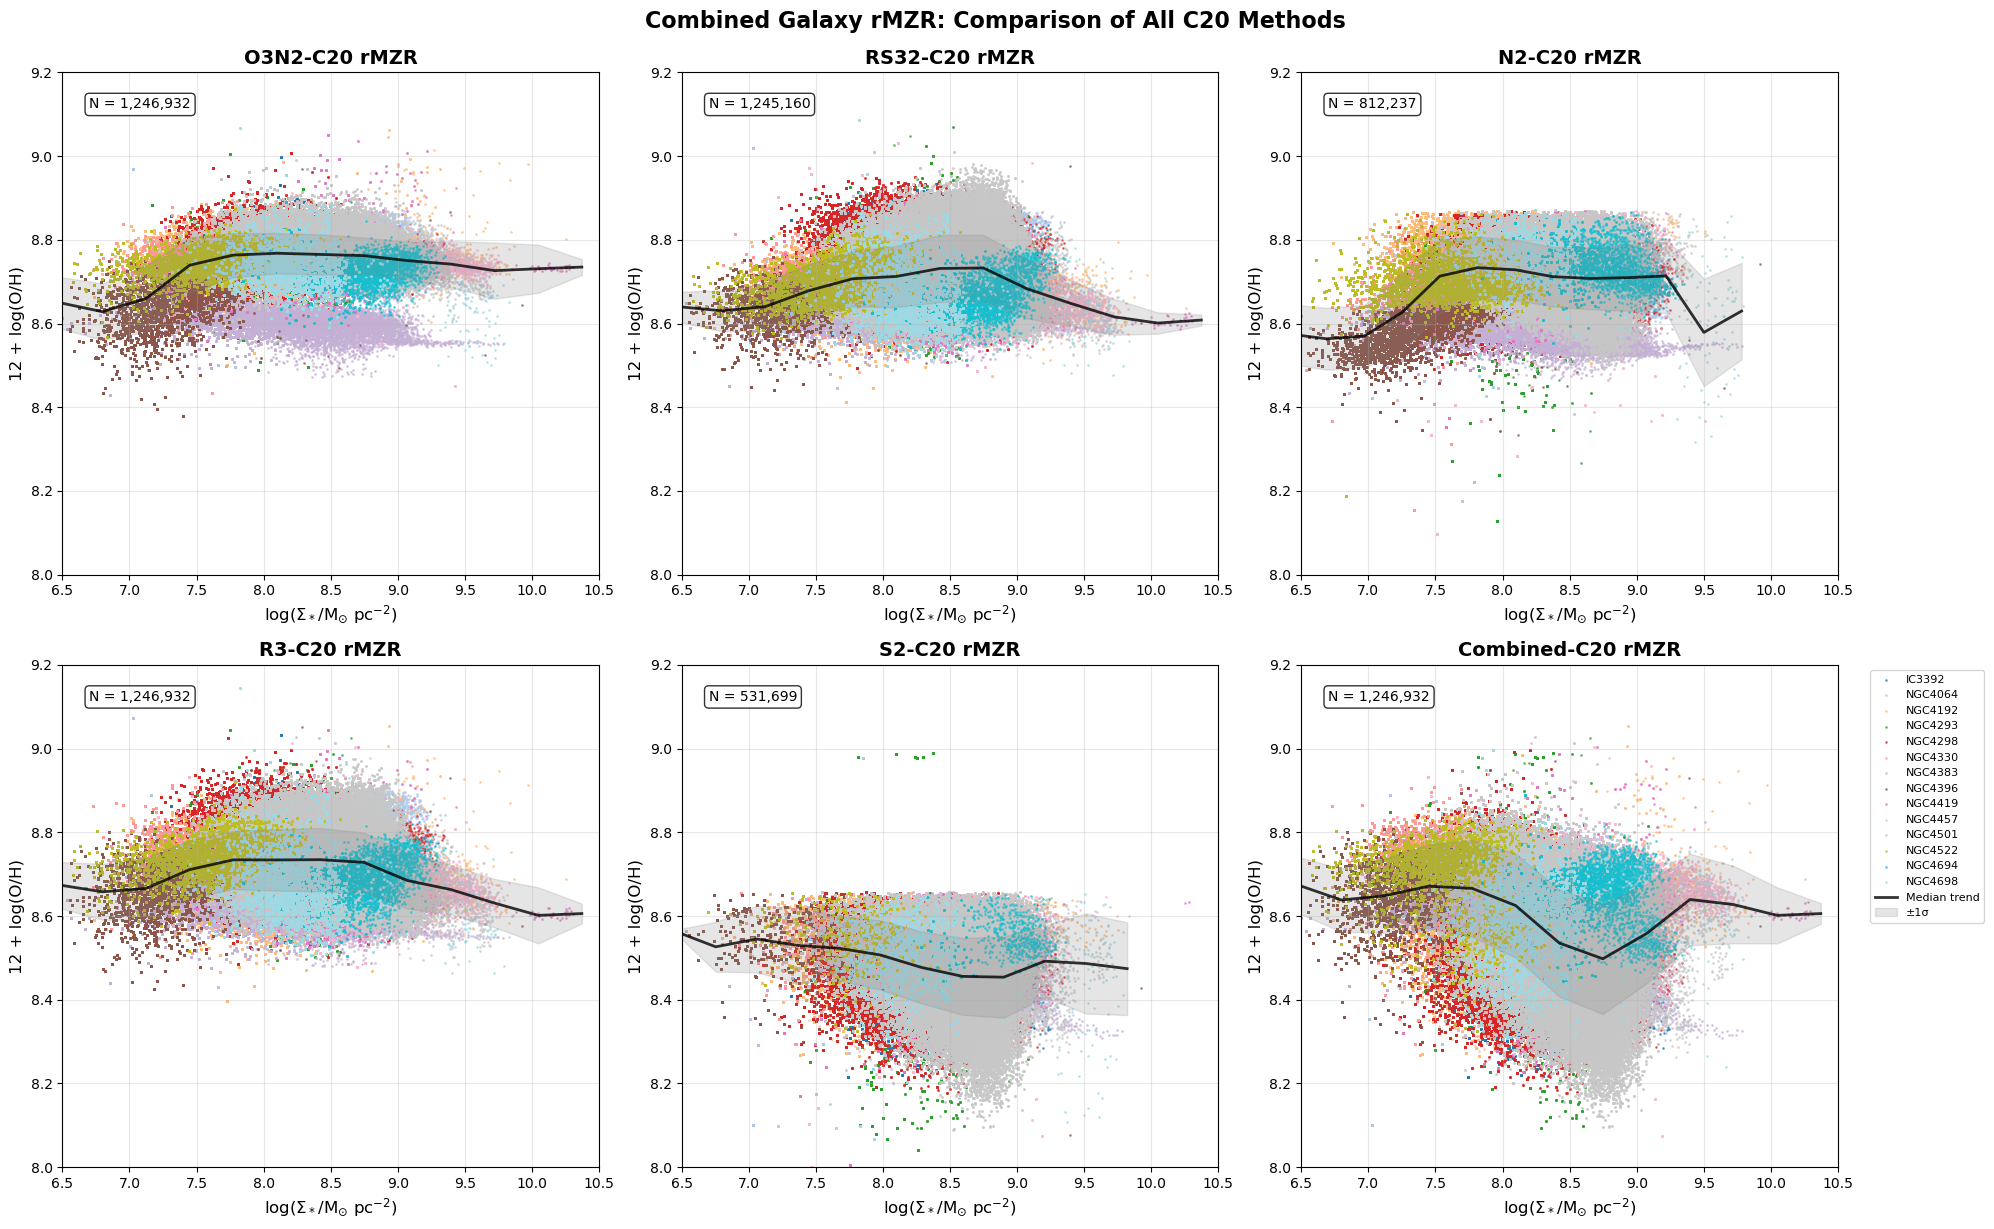

6-subplot rMZR figure completed!


In [15]:
# 6-subplot figure: Combined galaxy rMZR with all 6 C20 methods
# Re-run necessary setup functions first

# 0 · discover galaxies & colour palette
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]
ngal = len(galaxies)
assert ngal <= 14, "This layout assumes ≤ 14 galaxies."

# Create distinct colors for each galaxy
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, ngal))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

def calculate_combined_c20_metallicity(gal):
    """
    Calculate combined C20 metallicity by selecting the method with smallest error for each spaxel.
    
    For each spaxel, we:
    1. Calculate metallicity and error for all 6 C20 methods
    2. Select the method with the smallest error
    3. Return the corresponding metallicity value
    
    Returns:
        oh_combined_c20: Combined metallicity map
        oh_combined_c20_err: Combined error map
        method_map: Map showing which method was used for each spaxel (0-5)
        combined_mask: Combined valid spaxel mask
    """
    # Load all required fluxes
    with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
        sigM = h['LOGMASS_SURFACE_DENSITY'].data
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        sigSFR = h['LOGSFR_SURFACE_DENSITY_SF'].data
        
        # Load emission line fluxes
        hb4861_flux = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux = h['SII6716_FLUX_corr'].data
        sii6730_flux = h['SII6730_FLUX_corr'].data
        
        # Load emission line flux errors
        hb4861_flux_err = h['HB4861_FLUX_ERR'].data
        oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data
        sii6716_flux_err = h['SII6716_FLUX_ERR'].data
        sii6730_flux_err = h['SII6730_FLUX_ERR'].data
        
        # Load Halpha and NII with multiple naming conventions
        ha_key_candidates = ('HA6563_FLUX_corr', 'HA6562_FLUX_corr', 'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr')
        ha_err_candidates = ('HA6563_FLUX_ERR', 'HA6562_FLUX_ERR', 'HALPHA6563_FLUX_ERR', 'HALPHA_FLUX_ERR')
        nii_key_candidates = ('NII6584_FLUX_corr', 'NII6583_FLUX_corr', 'NII6584_FLUX', 'NII6583_FLUX')
        nii_err_candidates = ('NII6584_FLUX_ERR', 'NII6583_FLUX_ERR')
        
        ha6563_flux = None
        for k in ha_key_candidates:
            if k in h:
                ha6563_flux = h[k].data
                break
        
        ha6563_flux_err = None
        for k in ha_err_candidates:
            if k in h:
                ha6563_flux_err = h[k].data
                break
                
        nii6584_flux = None
        for k in nii_key_candidates:
            if k in h:
                nii6584_flux = h[k].data
                break
                
        nii6584_flux_err = None
        for k in nii_err_candidates:
            if k in h:
                nii6584_flux_err = h[k].data
                break
        
        # Load reference O/H data
        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None
    
    # Calculate metallicity for all 6 methods
    print(f"Calculating all 6 C20 metallicities for {gal}...")
    
    # Method 0: O3N2-C20
    oh_o3n2_c20, oh_o3n2_c20_err, mask_o3n2 = calculate_o3n2_c20_metallicity(
        hb4861_flux, oiii5006_flux, nii6584_flux, ha6563_flux,
        hb4861_flux_err, oiii5006_flux_err, nii6584_flux_err, ha6563_flux_err, oh_d16_sf
    )
    
    # Method 1: O3S2-C20
    oh_o3s2_c20, oh_o3s2_c20_err, mask_o3s2 = calculate_o3s2_c20_metallicity(
        hb4861_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )
    
    # Method 2: RS32-C20
    oh_rs32_c20, oh_rs32_c20_err, mask_rs32 = calculate_rs32_c20_metallicity(
        hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, ha6563_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )
    
    # Method 3: R3-C20
    oh_r3_c20, oh_r3_c20_err, mask_r3 = calculate_r3_c20_metallicity(
        hb4861_flux, hb4861_flux_err, oiii5006_flux, oiii5006_flux_err, oh_d16_sf
    )
    
    # Method 4: N2-C20
    oh_n2_c20, oh_n2_c20_err, mask_n2 = calculate_n2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, nii6584_flux, nii6584_flux_err, oh_d16_sf
    )
    
    # Method 5: S2-C20
    oh_s2_c20, oh_s2_c20_err, mask_s2 = calculate_s2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, sii6716_flux, sii6716_flux_err, sii6730_flux, sii6730_flux_err, oh_d16_sf
    )
    
    # Stack all metallicities and errors
    all_metallicities = np.stack([oh_o3n2_c20, oh_o3s2_c20, oh_rs32_c20, oh_r3_c20, oh_n2_c20, oh_s2_c20], axis=0)
    all_errors = np.stack([oh_o3n2_c20_err, oh_o3s2_c20_err, oh_rs32_c20_err, oh_r3_c20_err, oh_n2_c20_err, oh_s2_c20_err], axis=0)
    all_masks = np.stack([mask_o3n2, mask_o3s2, mask_rs32, mask_r3, mask_n2, mask_s2], axis=0)
    
    # Initialize output arrays
    oh_combined_c20 = np.full_like(hb4861_flux, np.nan)
    oh_combined_c20_err = np.full_like(hb4861_flux, np.nan)
    method_map = np.full_like(hb4861_flux, -1, dtype=int)  # -1 indicates no valid method
    
    # For each spaxel, find the method with the smallest error
    for i in range(hb4861_flux.shape[0]):
        for j in range(hb4861_flux.shape[1]):
            # Get valid methods for this spaxel
            valid_methods = all_masks[:, i, j]
            
            if np.any(valid_methods):
                # Get errors for valid methods only
                valid_errors = all_errors[valid_methods, i, j]
                valid_metallicities = all_metallicities[valid_methods, i, j]
                
                # Find method with minimum error
                min_error_idx = np.nanargmin(valid_errors)
                
                # Map back to original method index
                method_indices = np.where(valid_methods)[0]
                best_method = method_indices[min_error_idx]
                
                # Store results
                oh_combined_c20[i, j] = valid_metallicities[min_error_idx]
                oh_combined_c20_err[i, j] = valid_errors[min_error_idx]
                method_map[i, j] = best_method
    
    # Create combined mask
    combined_mask = np.isfinite(oh_combined_c20)
    
    return sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask

# Now create the 6-subplot figure
print("Creating 6-subplot rMZR figure with all C20 methods...")

# Collect data for all galaxies and all 6 methods
all_data = {
    'O3N2-C20': {'mass': [], 'metallicity': [], 'galaxy': []},
    'RS32-C20': {'mass': [], 'metallicity': [], 'galaxy': []},
    'N2-C20': {'mass': [], 'metallicity': [], 'galaxy': []},
    'R3-C20': {'mass': [], 'metallicity': [], 'galaxy': []},
    'S2-C20': {'mass': [], 'metallicity': [], 'galaxy': []},
    'Combined-C20': {'mass': [], 'metallicity': [], 'galaxy': []}
}

for gal in galaxies:
    print(f"Processing {gal}...")
    
    # Get the combined metallicity calculation results
    sigM, sigSFR, oh_combined_c20, oh_combined_c20_err, method_map, combined_mask = calculate_combined_c20_metallicity(gal)
    
    # Also calculate individual methods for comparison
    with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
        # Load emission line fluxes for individual method calculations
        hb4861_flux = h['HB4861_FLUX_corr'].data
        oiii5006_flux = h['OIII5006_FLUX_corr'].data
        sii6716_flux = h['SII6716_FLUX_corr'].data
        sii6730_flux = h['SII6730_FLUX_corr'].data
        
        hb4861_flux_err = h['HB4861_FLUX_ERR'].data
        oiii5006_flux_err = h['OIII5006_FLUX_ERR'].data
        sii6716_flux_err = h['SII6716_FLUX_ERR'].data
        sii6730_flux_err = h['SII6730_FLUX_ERR'].data
        
        # Load Halpha and NII
        ha_key_candidates = ('HA6563_FLUX_corr', 'HA6562_FLUX_corr', 'HALPHA6563_FLUX_corr', 'HALPHA_FLUX_corr')
        ha_err_candidates = ('HA6563_FLUX_ERR', 'HA6562_FLUX_ERR', 'HALPHA6563_FLUX_ERR', 'HALPHA_FLUX_ERR')
        nii_key_candidates = ('NII6584_FLUX_corr', 'NII6583_FLUX_corr', 'NII6584_FLUX', 'NII6583_FLUX')
        nii_err_candidates = ('NII6584_FLUX_ERR', 'NII6583_FLUX_ERR')
        
        ha6563_flux = None
        for k in ha_key_candidates:
            if k in h:
                ha6563_flux = h[k].data
                break
        
        ha6563_flux_err = None
        for k in ha_err_candidates:
            if k in h:
                ha6563_flux_err = h[k].data
                break
                
        nii6584_flux = None
        for k in nii_key_candidates:
            if k in h:
                nii6584_flux = h[k].data
                break
                
        nii6584_flux_err = None
        for k in nii_err_candidates:
            if k in h:
                nii6584_flux_err = h[k].data
                break
        
        # Load reference O/H data
        try:
            oh_d16_sf = h['O_H_D16_SF'].data
        except KeyError:
            oh_d16_sf = None
    
    # Calculate individual methods
    oh_o3n2_c20, oh_o3n2_c20_err, mask_o3n2 = calculate_o3n2_c20_metallicity(
        hb4861_flux, oiii5006_flux, nii6584_flux, ha6563_flux,
        hb4861_flux_err, oiii5006_flux_err, nii6584_flux_err, ha6563_flux_err, oh_d16_sf
    )
    
    oh_rs32_c20, oh_rs32_c20_err, mask_rs32 = calculate_rs32_c20_metallicity(
        hb4861_flux, ha6563_flux, oiii5006_flux, sii6716_flux, sii6730_flux,
        hb4861_flux_err, ha6563_flux_err, oiii5006_flux_err, sii6716_flux_err, sii6730_flux_err, oh_d16_sf
    )
    
    oh_n2_c20, oh_n2_c20_err, mask_n2 = calculate_n2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, nii6584_flux, nii6584_flux_err, oh_d16_sf
    )
    
    oh_r3_c20, oh_r3_c20_err, mask_r3 = calculate_r3_c20_metallicity(
        hb4861_flux, hb4861_flux_err, oiii5006_flux, oiii5006_flux_err, oh_d16_sf
    )
    
    oh_s2_c20, oh_s2_c20_err, mask_s2 = calculate_s2_c20_metallicity(
        ha6563_flux, ha6563_flux_err, sii6716_flux, sii6716_flux_err, sii6730_flux, sii6730_flux_err, oh_d16_sf
    )
    
    # Store data for each method
    methods_data = {
        'O3N2-C20': (oh_o3n2_c20, mask_o3n2),
        'RS32-C20': (oh_rs32_c20, mask_rs32),
        'N2-C20': (oh_n2_c20, mask_n2),
        'R3-C20': (oh_r3_c20, mask_r3),
        'S2-C20': (oh_s2_c20, mask_s2),
        'Combined-C20': (oh_combined_c20, combined_mask)
    }
    
    for method_name, (metallicity, mask) in methods_data.items():
        valid_mask = mask & np.isfinite(sigM) & np.isfinite(metallicity)
        if np.any(valid_mask):
            all_data[method_name]['mass'].extend(sigM[valid_mask])
            all_data[method_name]['metallicity'].extend(metallicity[valid_mask])
            all_data[method_name]['galaxy'].extend([gal] * np.sum(valid_mask))

# Create the 6-subplot figure (2x3 layout)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

method_names = ['O3N2-C20', 'RS32-C20', 'N2-C20', 'R3-C20', 'S2-C20', 'Combined-C20']
method_titles = ['O3N2-C20 rMZR', 'RS32-C20 rMZR', 'N2-C20 rMZR', 'R3-C20 rMZR', 'S2-C20 rMZR', 'Combined-C20 rMZR']

for i, method in enumerate(method_names):
    ax = axes[i]
    
    # Convert to arrays
    mass_data = np.array(all_data[method]['mass'])
    metallicity_data = np.array(all_data[method]['metallicity'])
    galaxy_data = np.array(all_data[method]['galaxy'])
    
    if len(mass_data) > 0:
        # Plot each galaxy with its unique color
        for gal in galaxies:
            gal_mask = galaxy_data == gal
            if np.any(gal_mask):
                ax.scatter(mass_data[gal_mask], metallicity_data[gal_mask], 
                          c=[galaxy_color_dict[gal]], alpha=0.6, s=1, label=gal)
        
        # Add median trend line
        mass_bins = np.linspace(np.nanmin(mass_data), np.nanmax(mass_data), 15)
        x_median = []
        y_median = []
        y_std = []
        
        for j in range(len(mass_bins)-1):
            bin_mask = (mass_data >= mass_bins[j]) & (mass_data < mass_bins[j+1])
            if np.sum(bin_mask) >= 10:  # At least 10 points per bin
                x_median.append((mass_bins[j] + mass_bins[j+1]) / 2)
                y_median.append(np.nanmedian(metallicity_data[bin_mask]))
                y_std.append(np.nanstd(metallicity_data[bin_mask]))
        
        if len(x_median) > 0:
            ax.plot(x_median, y_median, 'k-', linewidth=2, alpha=0.8, label='Median trend')
            ax.fill_between(x_median, 
                           np.array(y_median) - np.array(y_std),
                           np.array(y_median) + np.array(y_std),
                           alpha=0.2, color='gray', label='±1σ')
    
    ax.set_xlabel('log(Σ$_*$/M$_⊙$ pc$^{-2}$)', fontsize=12)
    ax.set_ylabel('12 + log(O/H)', fontsize=12)
    ax.set_title(method_titles[i], fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Set consistent axis limits
    ax.set_xlim(6.5, 10.5)
    ax.set_ylim(8.0, 9.2)
    
    # Add statistics
    if len(mass_data) > 0:
        ax.text(0.05, 0.95, f'N = {len(mass_data):,}', 
               transform=ax.transAxes, fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add legend for galaxies (only on the last subplot to avoid clutter)
if ngal <= 14:  # Only show legend if we have a reasonable number of galaxies
    axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.suptitle('Combined Galaxy rMZR: Comparison of All C20 Methods', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("6-subplot rMZR figure completed!")